In [1]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence
from read_ini import read_ini
conf =read_ini("C:/Users/alexander.vasilyev/pomdp-baselines-main/configfile.ini")

C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
C:\Users\alexander.vasilyev\pomdp-baselines-main\utils\logger.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Set
C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [2]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env = gym.make(conf["env_name"])
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name=conf["algo_name"],
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            embed=True,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            radii=40,
            embed=True,
            activation = conf["activation"],
        ).to(ptu.device)
    
print(agent)
lr=float(conf["lr"])
encoder=conf["encoder"]
num_updates_per_iter = int(conf["num_updates_per_iter"])  # training frequency
sampled_seq_len = int(conf["sampled_seq_len"])  # context length
buffer_size = int(float(conf["buffer_size"]))
batch_size = int(conf["batch_size"])
dropout_rate=float(conf["dropout_rate"])
num_iters = int(conf["num_iters"])
num_init_rollouts_pool = int(conf["num_init_rollouts_pool"])
num_rollouts_per_iter = int(conf["num_rollouts_per_iter"])
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)


ModelFreeOffPolicy_Separate_RNN(
  (critic): Critic_RNN(
    (observ_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=32, bias=True)
    )
    (action_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (reward_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=8, bias=True)
    )
    (rnn): NeuralCDE(
      (func): CDEFunc(
        (linear0): Linear(in_features=72, out_features=72, bias=True)
        (linear1): Linear(in_features=72, out_features=72, bias=True)
        (linear2): Linear(in_features=72, out_features=3528, bias=True)
      )
      (initial): Linear(in_features=49, out_features=72, bias=True)
      (readout): Linear(in_features=72, out_features=72, bias=True)
    )
    (current_shortcut_embedder): FeatureExtractor(
      (fc): Linear(in_features=2, out_features=48, bias=True)
    )
    (qf1): FlattenMlp(
      (fc0): Linear(in_features=120, out_features=128, bias=True)
   

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

## Define key functions: collect rollouts and policy update

In [3]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
 
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
    
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)

    ncde_row=torch.cat((time_tensor,act_row,obs_row,rew_row),1)
    ncde_row=ncde_row[None,:]
    
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        print(env.reset())
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,init)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list = (
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row, prev_internal_state=internal_state, obs=obs,  deterministic=deterministic)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
            
            if not markov:
                if encoder == "ncde":
   
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,init)
            
            #switch on/off dropouts
            #drop_trigger=rnd.uniform(0,1)
            #if drop_trigger<dropout_rate:
            #    next_obs=cp.deepcopy(obs)
            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [4]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=buffer_size,
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=False, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 10
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
    "z": [],
}
epoch=0
lambda_pat = 0.65

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    #train_stats = update(int(num_updates_per_iter * env_steps))
    factor= lambda_pat **(epoch )
    #train_stats = update(int(num_updates_per_iter * env_steps))
    train_stats = update(25, lr)
    
    epoch += 1
    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns, std_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        learning_curve["z"].append(std_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
[-0.9953948]


C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Mode: Train env_steps 200 total rewards -1570.046748161316 total energy tensor([[6.6871e-05]])
[0.23094335]
Mode: Train env_steps 200 total rewards -957.7108780145645 total energy tensor([[0.0007]])
[-0.55273527]
Mode: Train env_steps 200 total rewards -1391.0569982528687 total energy tensor([[0.0003]])
[-0.8675668]
Mode: Train env_steps 200 total rewards -1191.461077928543 total energy tensor([[0.0004]])
[-0.3151585]
Mode: Train env_steps 200 total rewards -1307.7665836811066 total energy tensor([[0.0004]])
[0.05086967]
Mode: Train env_steps 200 total rewards -1831.725305557251 total energy tensor([[3.5283e-05]])
[0.80072767]
Mode: Train env_steps 200 total rewards -1324.2787919044495 total energy tensor([[0.0003]])
[-0.27755544]
Mode: Train env_steps 200 total rewards -630.769354712218 total energy tensor([[0.0002]])
[0.56966573]
Mode: Train env_steps 200 total rewards -1451.595944404602 total energy tensor([[0.0002]])
[0.3534958]
Mode: Train env_steps 200 total rewards -970.44227367

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\alexander.vasilyev\pomdp-baselines-main\torchkit\pytorch_utils.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if v.dtype == np.bool:
100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


[-0.6530923]
Mode: Train env_steps 200 total rewards -1292.5857775211334 total energy tensor([[186.6316]])
[-0.07260388]
Mode: Train env_steps 200 total rewards -1534.510039806366 total energy tensor([[188.9306]])
[-0.264491]
Mode: Train env_steps 200 total rewards -1468.8469953536987 total energy tensor([[191.1458]])
[-0.20494787]
Mode: Train env_steps 200 total rewards -1610.4021558761597 total energy tensor([[192.5283]])
[-0.79145616]
Mode: Train env_steps 200 total rewards -1419.9829085469246 total energy tensor([[190.8808]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.1764962]
Mode: Train env_steps 200 total rewards -1600.8015027046204 total energy tensor([[32.5889]])
[0.3663391]
Mode: Train env_steps 200 total rewards -1683.8662447929382 total energy tensor([[29.5105]])
[0.2694646]
Mode: Train env_steps 200 total rewards -1397.6177160441875 total energy tensor([[65.6285]])
[-0.55143595]
Mode: Train env_steps 200 total rewards -1400.397753417492 total energy tensor([[65.9454]])
[-0.8337831]
Mode: Train env_steps 200 total rewards -1566.1663113832474 total energy tensor([[34.1099]])


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[0.35029215]
Mode: Train env_steps 200 total rewards -1250.751866042614 total energy tensor([[150.8866]])
[0.5181941]
Mode: Train env_steps 200 total rewards -1526.6400017738342 total energy tensor([[172.9350]])
[-0.28004476]
Mode: Train env_steps 200 total rewards -1616.065242946148 total energy tensor([[172.1550]])
[0.35532135]
Mode: Train env_steps 200 total rewards -1528.3379611968994 total energy tensor([[176.6349]])
[-0.6493892]
Mode: Train env_steps 200 total rewards -1606.5569690465927 total energy tensor([[171.7289]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.6333513]
Mode: Test env_steps 200 total rewards -1591.1226505019004 total energy tensor([[193.2074]])
[-0.6520536]
Mode: Test env_steps 200 total rewards -1194.9621276855469 total energy tensor([[150.1358]])
[-0.6058455]
Mode: Test env_steps 200 total rewards -1308.9288175106049 total energy tensor([[156.8155]])
[-0.3227725]
Mode: Test env_steps 200 total rewards -1632.9329324960709 total energy tensor([[195.0854]])
[-0.7857761]
Mode: Test env_steps 200 total rewards -1357.5720357894897 total energy tensor([[161.8741]])
[-0.5482783]
Mode: Test env_steps 200 total rewards -1516.1718697547913 total energy tensor([[185.9533]])
[-0.3075142]
Mode: Test env_steps 200 total rewards -1668.3143776655197 total energy tensor([[196.3662]])
[0.00319802]
Mode: Test env_steps 200 total rewards -1196.0265407562256 total energy tensor([[150.9898]])
[-0.43020102]
Mode: Test env_steps 200 total rewards -1660.0613567829132 total energy tensor([[195.8461]])
[0.35809192]
Mode: Test env_steps 200 total re

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.80033517]
Mode: Train env_steps 200 total rewards -1660.9731088876724 total energy tensor([[197.6273]])
[-0.6060469]
Mode: Train env_steps 200 total rewards -1613.774273097515 total energy tensor([[196.2608]])
[0.40612775]
Mode: Train env_steps 200 total rewards -1311.463769197464 total energy tensor([[155.8935]])
[-0.13136658]
Mode: Train env_steps 200 total rewards -1680.4451575279236 total energy tensor([[198.2163]])
[0.10135972]
Mode: Train env_steps 200 total rewards -1349.4951484203339 total energy tensor([[160.0383]])


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


[0.01462566]
Mode: Train env_steps 200 total rewards -1608.5683520082384 total energy tensor([[196.2491]])
[0.58045775]
Mode: Train env_steps 200 total rewards -1663.5084693431854 total energy tensor([[196.8876]])
[-0.78630817]
Mode: Train env_steps 200 total rewards -1658.2521106600761 total energy tensor([[197.8923]])
[0.80784464]
Mode: Train env_steps 200 total rewards -1656.1515065729618 total energy tensor([[198.2703]])
[0.47359356]
Mode: Train env_steps 200 total rewards -1627.8462223410606 total energy tensor([[197.1793]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[-0.77472633]
Mode: Train env_steps 200 total rewards -1653.83756005764 total energy tensor([[197.5097]])
[-0.6253975]
Mode: Train env_steps 200 total rewards -1201.3327702730894 total energy tensor([[124.5586]])
[-0.51630944]
Mode: Train env_steps 200 total rewards -1458.6578917503357 total energy tensor([[151.4948]])
[-0.81158847]
Mode: Train env_steps 200 total rewards -1492.6535477638245 total energy tensor([[146.1502]])
[-0.79867697]
Mode: Train env_steps 200 total rewards -1502.6089973449707 total energy tensor([[191.3912]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[-0.98014677]
Mode: Train env_steps 200 total rewards -1314.1471347212791 total energy tensor([[129.9218]])
[-0.16630927]
Mode: Train env_steps 200 total rewards -1642.1675062775612 total energy tensor([[196.4019]])
[0.49864072]
Mode: Train env_steps 200 total rewards -1621.7061980701983 total energy tensor([[197.3051]])
[-0.52736425]
Mode: Train env_steps 200 total rewards -1523.3434495925903 total energy tensor([[185.2525]])
[-0.7763645]
Mode: Train env_steps 200 total rewards -1467.2688605338335 total energy tensor([[193.0328]])


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[-0.39615124]
Mode: Test env_steps 200 total rewards -1620.969302892685 total energy tensor([[195.7810]])
[-0.3135149]
Mode: Test env_steps 200 total rewards -1389.6021480560303 total energy tensor([[139.4613]])
[0.80440015]
Mode: Test env_steps 200 total rewards -1530.8164944648743 total energy tensor([[178.2107]])
[-0.17901708]
Mode: Test env_steps 200 total rewards -1603.2320405766368 total energy tensor([[196.9255]])
[0.57314587]
Mode: Test env_steps 200 total rewards -1654.0726263523102 total energy tensor([[198.7420]])
[-0.19431175]
Mode: Test env_steps 200 total rewards -1540.9245352745056 total energy tensor([[175.3083]])
[-0.574566]
Mode: Test env_steps 200 total rewards -1493.801738023758 total energy tensor([[151.4586]])
[-0.13677183]
Mode: Test env_steps 200 total rewards -1532.7721481323242 total energy tensor([[178.3710]])
[0.3072443]
Mode: Test env_steps 200 total rewards -1103.506862707436 total energy tensor([[143.3534]])
[-0.06332374]
Mode: Test env_steps 200 total re

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


[0.17232378]
Mode: Train env_steps 200 total rewards -1214.0089320540428 total energy tensor([[148.9593]])
[-0.74649876]
Mode: Train env_steps 200 total rewards -1237.4409682750702 total energy tensor([[152.2354]])
[-0.6065079]
Mode: Train env_steps 200 total rewards -1595.222753237933 total energy tensor([[195.8528]])
[0.07025519]
Mode: Train env_steps 200 total rewards -1667.9964027404785 total energy tensor([[198.5607]])
[-0.33184913]
Mode: Train env_steps 200 total rewards -1612.9413672685623 total energy tensor([[196.7578]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[-0.73481977]
Mode: Train env_steps 200 total rewards -1641.7465392947197 total energy tensor([[197.6133]])
[-0.9958827]
Mode: Train env_steps 200 total rewards -1511.5794820785522 total energy tensor([[182.6547]])
[0.64565325]
Mode: Train env_steps 200 total rewards -1565.0847837924957 total energy tensor([[194.2355]])
[0.8217423]
Mode: Train env_steps 200 total rewards -1199.872122168541 total energy tensor([[157.0074]])
[0.9914251]
Mode: Train env_steps 200 total rewards -1676.6251014471054 total energy tensor([[197.4674]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[0.54054445]
Mode: Train env_steps 200 total rewards -1614.507150888443 total energy tensor([[196.8488]])
[-0.7627825]
Mode: Train env_steps 200 total rewards -1209.9574131071568 total energy tensor([[141.3745]])
[-0.42021376]
Mode: Train env_steps 200 total rewards -1362.4289116859436 total energy tensor([[154.1973]])
[-0.74000233]
Mode: Train env_steps 200 total rewards -1510.93989944458 total energy tensor([[176.5977]])
[-0.0577843]
Mode: Train env_steps 200 total rewards -1377.1131842136383 total energy tensor([[156.1472]])


100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


[0.9887144]
Mode: Train env_steps 200 total rewards -1075.496035888791 total energy tensor([[136.3950]])
[-0.46115187]
Mode: Train env_steps 200 total rewards -1557.528829306364 total energy tensor([[194.4334]])
[0.4036603]
Mode: Train env_steps 200 total rewards -1331.8211908340454 total energy tensor([[150.6517]])
[0.74670345]
Mode: Train env_steps 200 total rewards -1169.6124024391174 total energy tensor([[139.5017]])
[0.9532278]
Mode: Train env_steps 200 total rewards -1653.5644142627716 total energy tensor([[198.1378]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.48841473]
Mode: Test env_steps 200 total rewards -1269.8523055315018 total energy tensor([[152.9609]])
[-0.26954827]
Mode: Test env_steps 200 total rewards -1619.4166123569012 total energy tensor([[197.2328]])
[0.763569]
Mode: Test env_steps 200 total rewards -1453.3111608028412 total energy tensor([[152.2433]])
[-0.4140864]
Mode: Test env_steps 200 total rewards -1406.0227522850037 total energy tensor([[162.9699]])
[0.9197889]
Mode: Test env_steps 200 total rewards -1382.1915171146393 total energy tensor([[153.0947]])
[-0.46773684]
Mode: Test env_steps 200 total rewards -1455.5512926578522 total energy tensor([[152.2543]])
[0.74880385]
Mode: Test env_steps 200 total rewards -1668.4558839797974 total energy tensor([[198.2076]])
[0.30016196]
Mode: Test env_steps 200 total rewards -1464.3541204929352 total energy tensor([[150.9615]])
[-0.8093361]
Mode: Test env_steps 200 total rewards -1351.3670094013214 total energy tensor([[155.4343]])
[-0.82784605]
Mode: Test env_steps 200 total r

100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.37617218]
Mode: Train env_steps 200 total rewards -1634.2962954193354 total energy tensor([[197.8594]])
[0.90931964]
Mode: Train env_steps 200 total rewards -1643.6109041571617 total energy tensor([[197.0889]])
[-0.595823]
Mode: Train env_steps 200 total rewards -1479.6533434391022 total energy tensor([[146.7735]])
[-0.2559869]
Mode: Train env_steps 200 total rewards -1666.2955662608147 total energy tensor([[198.2735]])
[0.6660296]
Mode: Train env_steps 200 total rewards -1651.054469794035 total energy tensor([[198.2557]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.71436155]
Mode: Train env_steps 200 total rewards -1179.3437259793282 total energy tensor([[140.6127]])
[-0.05427961]
Mode: Train env_steps 200 total rewards -1687.7663143873215 total energy tensor([[198.5286]])
[0.7248283]
Mode: Train env_steps 200 total rewards -1430.7561786174774 total energy tensor([[135.3645]])
[0.5194244]
Mode: Train env_steps 200 total rewards -1514.8557510375977 total energy tensor([[160.6187]])
[-0.14715646]
Mode: Train env_steps 200 total rewards -1359.7426879405975 total energy tensor([[138.4543]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.8151505]
Mode: Train env_steps 200 total rewards -1475.5719527453184 total energy tensor([[185.4223]])
[-0.08570853]
Mode: Train env_steps 200 total rewards -1488.0073370933533 total energy tensor([[133.5710]])
[0.39713612]
Mode: Train env_steps 200 total rewards -1582.1451513171196 total energy tensor([[197.0900]])
[-0.20184551]
Mode: Train env_steps 200 total rewards -1414.223392009735 total energy tensor([[138.5287]])
[0.4304767]
Mode: Train env_steps 200 total rewards -1555.7878007888794 total energy tensor([[124.2379]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.13090466]
Mode: Train env_steps 200 total rewards -1489.2742176055908 total energy tensor([[130.6584]])
[-0.8263749]
Mode: Train env_steps 200 total rewards -1470.3203933238983 total energy tensor([[136.7842]])
[0.49241814]
Mode: Train env_steps 200 total rewards -1422.9390943050385 total energy tensor([[140.4934]])
[0.19625297]
Mode: Train env_steps 200 total rewards -1393.7790410518646 total energy tensor([[140.6498]])
[-0.15007113]
Mode: Train env_steps 200 total rewards -1659.266262292862 total energy tensor([[198.4531]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.42558375]
Mode: Test env_steps 200 total rewards -1567.8286480903625 total energy tensor([[73.0550]])
[0.7135994]
Mode: Test env_steps 200 total rewards -1634.1204015016556 total energy tensor([[198.4404]])
[-0.70155895]
Mode: Test env_steps 200 total rewards -1639.7544022649527 total energy tensor([[198.3839]])
[0.557777]
Mode: Test env_steps 200 total rewards -1529.8269958496094 total energy tensor([[85.1752]])
[0.9978542]
Mode: Test env_steps 200 total rewards -1561.2494359016418 total energy tensor([[98.0612]])
[-0.89666015]
Mode: Test env_steps 200 total rewards -1665.5139396190643 total energy tensor([[198.6536]])
[-0.57927865]
Mode: Test env_steps 200 total rewards -1063.539028301835 total energy tensor([[132.1996]])
[0.5347754]
Mode: Test env_steps 200 total rewards -1560.529513835907 total energy tensor([[82.0869]])
[0.90398246]
Mode: Test env_steps 200 total rewards -1591.4141974300146 total energy tensor([[195.6168]])
[0.21964037]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.8161433]
Mode: Train env_steps 200 total rewards -1080.7843383550644 total energy tensor([[147.7792]])
[-0.09066819]
Mode: Train env_steps 200 total rewards -1559.360613822937 total energy tensor([[133.6475]])
[0.43093368]
Mode: Train env_steps 200 total rewards -965.4346897006035 total energy tensor([[143.3597]])
[0.16481566]
Mode: Train env_steps 200 total rewards -1416.1400382518768 total energy tensor([[155.6147]])
[0.6171744]
Mode: Train env_steps 200 total rewards -1606.4332913160324 total energy tensor([[198.4424]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.5234953]
Mode: Train env_steps 200 total rewards -1292.640330672264 total energy tensor([[148.4431]])
[-0.16127905]
Mode: Train env_steps 200 total rewards -1596.9458253830671 total energy tensor([[196.0781]])
[-0.7692602]
Mode: Train env_steps 200 total rewards -1529.7884430885315 total energy tensor([[150.1188]])
[-0.1513886]
Mode: Train env_steps 200 total rewards -1632.9202704429626 total energy tensor([[196.0091]])
[-0.5706148]
Mode: Train env_steps 200 total rewards -1402.2752766609192 total energy tensor([[144.2415]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.03332519]
Mode: Train env_steps 200 total rewards -1443.4753391742706 total energy tensor([[128.4075]])
[-0.02085755]
Mode: Train env_steps 200 total rewards -1558.9102549552917 total energy tensor([[93.1461]])
[-0.6067226]
Mode: Train env_steps 200 total rewards -1556.263222694397 total energy tensor([[96.5679]])
[-0.77872485]
Mode: Train env_steps 200 total rewards -1667.9735379219055 total energy tensor([[198.5100]])
[-0.40144232]
Mode: Train env_steps 200 total rewards -1540.8821258544922 total energy tensor([[110.4952]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.00286688]
Mode: Train env_steps 200 total rewards -1527.4438523948193 total energy tensor([[187.0760]])
[-0.5593529]
Mode: Train env_steps 200 total rewards -1575.0267701148987 total energy tensor([[82.5706]])
[-0.6983604]
Mode: Train env_steps 200 total rewards -1643.8118959516287 total energy tensor([[198.6110]])
[-0.5896251]
Mode: Train env_steps 200 total rewards -1626.9395961761475 total energy tensor([[197.4593]])
[0.5009804]
Mode: Train env_steps 200 total rewards -1557.5580531656742 total energy tensor([[194.6254]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.28020445]
Mode: Test env_steps 200 total rewards -1654.2448801994324 total energy tensor([[196.2813]])
[-0.4166649]
Mode: Test env_steps 200 total rewards -1617.466546535492 total energy tensor([[196.2079]])
[0.8640165]
Mode: Test env_steps 200 total rewards -1434.6545827388763 total energy tensor([[106.0474]])
[0.24295908]
Mode: Test env_steps 200 total rewards -1206.4899674654007 total energy tensor([[137.7142]])
[-0.03731411]
Mode: Test env_steps 200 total rewards -1654.763708114624 total energy tensor([[197.9906]])
[0.6838145]
Mode: Test env_steps 200 total rewards -1527.341768503189 total energy tensor([[186.2759]])
[-0.29936093]
Mode: Test env_steps 200 total rewards -1636.3502083793283 total energy tensor([[198.6444]])
[0.15354222]
Mode: Test env_steps 200 total rewards -1654.4954957962036 total energy tensor([[198.1322]])
[0.73334736]
Mode: Test env_steps 200 total rewards -1575.605411529541 total energy tensor([[64.4815]])
[-0.69080186]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.3856272]
Mode: Train env_steps 200 total rewards -1546.932912349701 total energy tensor([[188.3894]])
[0.94032335]
Mode: Train env_steps 200 total rewards -1675.012769460678 total energy tensor([[198.1418]])
[-0.4005443]
Mode: Train env_steps 200 total rewards -1658.2944753170013 total energy tensor([[197.0316]])
[-0.31921673]
Mode: Train env_steps 200 total rewards -1626.9029843956232 total energy tensor([[196.9459]])
[0.49886644]
Mode: Train env_steps 200 total rewards -1275.4114274978638 total energy tensor([[143.1814]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.42943108]
Mode: Train env_steps 200 total rewards -1595.5994859337807 total energy tensor([[198.6341]])
[0.9833914]
Mode: Train env_steps 200 total rewards -1525.3437778949738 total energy tensor([[95.0001]])
[0.8769261]
Mode: Train env_steps 200 total rewards -1554.9462280273438 total energy tensor([[195.2823]])
[0.6121928]
Mode: Train env_steps 200 total rewards -1476.8272704705596 total energy tensor([[177.8099]])
[0.01624557]
Mode: Train env_steps 200 total rewards -1552.7641406059265 total energy tensor([[91.8775]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.9911597]
Mode: Train env_steps 200 total rewards -1666.1428331136703 total energy tensor([[197.5646]])
[-0.77911377]
Mode: Train env_steps 200 total rewards -1372.383288860321 total energy tensor([[132.8015]])
[-0.767282]
Mode: Train env_steps 200 total rewards -1564.9293203353882 total energy tensor([[66.3673]])
[0.01610684]
Mode: Train env_steps 200 total rewards -1252.9928743839264 total energy tensor([[144.9239]])
[0.5204888]
Mode: Train env_steps 200 total rewards -1558.5962917804718 total energy tensor([[83.0015]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.09807338]
Mode: Train env_steps 200 total rewards -1492.746832370758 total energy tensor([[85.9857]])
[0.66831607]
Mode: Train env_steps 200 total rewards -1614.2336931228638 total energy tensor([[62.0060]])
[-0.0147096]
Mode: Train env_steps 200 total rewards -1596.6573104858398 total energy tensor([[75.6174]])
[0.41357175]
Mode: Train env_steps 200 total rewards -1631.9696106910706 total energy tensor([[60.3110]])
[0.51490605]
Mode: Train env_steps 200 total rewards -1523.1902776136994 total energy tensor([[181.4191]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.9041246]
Mode: Test env_steps 200 total rewards -1538.6188448369503 total energy tensor([[183.8882]])
[0.8792343]
Mode: Test env_steps 200 total rewards -1568.6687900424004 total energy tensor([[194.0315]])
[-0.28801107]
Mode: Test env_steps 200 total rewards -1566.1728739738464 total energy tensor([[70.7321]])
[0.5481155]
Mode: Test env_steps 200 total rewards -1578.2023842334747 total energy tensor([[61.8641]])
[0.61569566]
Mode: Test env_steps 200 total rewards -1598.832320690155 total energy tensor([[56.3246]])
[-0.18144964]
Mode: Test env_steps 200 total rewards -1638.2242119461298 total energy tensor([[198.4756]])
[-0.628173]
Mode: Test env_steps 200 total rewards -1566.9826867580414 total energy tensor([[73.2172]])
[0.8194282]
Mode: Test env_steps 200 total rewards -1567.5499427318573 total energy tensor([[74.4501]])
[0.04724132]
Mode: Test env_steps 200 total rewards -1597.5296577364206 total energy tensor([[194.7876]])
[-0.7446099]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.78177166]
Mode: Train env_steps 200 total rewards -1677.0982981920242 total energy tensor([[198.0173]])
[0.78418964]
Mode: Train env_steps 200 total rewards -1613.225326538086 total energy tensor([[197.1135]])
[-0.37393293]
Mode: Train env_steps 200 total rewards -1665.9088027477264 total energy tensor([[198.6102]])
[0.9030602]
Mode: Train env_steps 200 total rewards -1633.8494119644165 total energy tensor([[195.1508]])
[0.38347748]
Mode: Train env_steps 200 total rewards -1633.9721720293164 total energy tensor([[198.3760]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.98839873]
Mode: Train env_steps 200 total rewards -1536.892957881093 total energy tensor([[184.3905]])
[-0.50369275]
Mode: Train env_steps 200 total rewards -1656.8013538122177 total energy tensor([[195.7839]])
[0.685719]
Mode: Train env_steps 200 total rewards -1542.6366267204285 total energy tensor([[77.0677]])
[-0.09537721]
Mode: Train env_steps 200 total rewards -1549.907109260559 total energy tensor([[64.6136]])
[0.43800482]
Mode: Train env_steps 200 total rewards -1559.1318809986115 total energy tensor([[74.7681]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.07768435]
Mode: Train env_steps 200 total rewards -1576.957466519052 total energy tensor([[191.1309]])
[0.6870245]
Mode: Train env_steps 200 total rewards -1446.5269658714533 total energy tensor([[188.1698]])
[-0.4399454]
Mode: Train env_steps 200 total rewards -1443.4274179935455 total energy tensor([[107.8594]])
[-0.4271126]
Mode: Train env_steps 200 total rewards -1540.1446581482887 total energy tensor([[186.7363]])
[-0.24506393]
Mode: Train env_steps 200 total rewards -1233.103278875351 total energy tensor([[136.1985]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.6138394]
Mode: Train env_steps 200 total rewards -1538.0764315128326 total energy tensor([[187.1974]])
[0.73856425]
Mode: Train env_steps 200 total rewards -1608.9769699424505 total energy tensor([[194.1974]])
[0.96653694]
Mode: Train env_steps 200 total rewards -1501.3057940006256 total energy tensor([[92.7151]])
[0.20950511]
Mode: Train env_steps 200 total rewards -1588.48961353302 total energy tensor([[71.8891]])
[0.78311414]
Mode: Train env_steps 200 total rewards -1521.0589163303375 total energy tensor([[87.0455]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.86083174]
Mode: Test env_steps 200 total rewards -1138.145599424839 total energy tensor([[142.1244]])
[-0.21929088]
Mode: Test env_steps 200 total rewards -1526.717734694481 total energy tensor([[186.8364]])
[0.04066423]
Mode: Test env_steps 200 total rewards -1519.0925006866455 total energy tensor([[86.6124]])
[-0.18057357]
Mode: Test env_steps 200 total rewards -1561.6529450416565 total energy tensor([[66.4409]])
[-0.6196866]
Mode: Test env_steps 200 total rewards -1639.9495553076267 total energy tensor([[197.2361]])
[-0.01935134]
Mode: Test env_steps 200 total rewards -1682.577967762947 total energy tensor([[197.4857]])
[-0.81951576]
Mode: Test env_steps 200 total rewards -1451.250117778778 total energy tensor([[101.2914]])
[0.14069992]
Mode: Test env_steps 200 total rewards -1667.3141859173775 total energy tensor([[197.1916]])
[0.8340039]
Mode: Test env_steps 200 total rewards -1550.492149591446 total energy tensor([[83.7120]])
[-0.6181782]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.50178194]
Mode: Train env_steps 200 total rewards -1467.551929473877 total energy tensor([[94.0385]])
[-0.7382835]
Mode: Train env_steps 200 total rewards -1594.0507360696793 total energy tensor([[195.8488]])
[-0.44977418]
Mode: Train env_steps 200 total rewards -1550.3143310546875 total energy tensor([[60.0260]])
[-0.26234254]
Mode: Train env_steps 200 total rewards -1457.4538180828094 total energy tensor([[93.7283]])
[-0.00073658]
Mode: Train env_steps 200 total rewards -1577.5200691223145 total energy tensor([[44.5420]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.71542245]
Mode: Train env_steps 200 total rewards -1628.273680984974 total energy tensor([[195.7780]])
[-0.21030797]
Mode: Train env_steps 200 total rewards -1602.5666335001588 total energy tensor([[193.5739]])
[-0.29530412]
Mode: Train env_steps 200 total rewards -1569.7064616680145 total energy tensor([[77.7686]])
[-0.31945997]
Mode: Train env_steps 200 total rewards -1615.371975660324 total energy tensor([[63.2749]])
[0.11686933]
Mode: Train env_steps 200 total rewards -1621.8095072507858 total energy tensor([[194.6989]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.0744771]
Mode: Train env_steps 200 total rewards -1665.2580088973045 total energy tensor([[195.7099]])
[-0.25206596]
Mode: Train env_steps 200 total rewards -1661.1759624481201 total energy tensor([[52.3083]])
[-0.49207267]
Mode: Train env_steps 200 total rewards -1578.6862310767174 total energy tensor([[194.9039]])
[0.34677988]
Mode: Train env_steps 200 total rewards -1655.0898675322533 total energy tensor([[196.2579]])
[-0.11770602]
Mode: Train env_steps 200 total rewards -1516.942458416801 total energy tensor([[184.1013]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.14238742]
Mode: Train env_steps 200 total rewards -1605.4306151866913 total energy tensor([[63.2817]])
[0.71031463]
Mode: Train env_steps 200 total rewards -1609.5142112970352 total energy tensor([[194.7559]])
[-0.6437919]
Mode: Train env_steps 200 total rewards -1541.2529227733612 total energy tensor([[80.5865]])
[-0.95838463]
Mode: Train env_steps 200 total rewards -1675.9044024944305 total energy tensor([[196.3216]])
[0.05139745]
Mode: Train env_steps 200 total rewards -1652.5183579921722 total energy tensor([[194.0399]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.32022843]
Mode: Test env_steps 200 total rewards -1510.6155930012465 total energy tensor([[182.9736]])
[0.32866827]
Mode: Test env_steps 200 total rewards -1652.738576889038 total energy tensor([[65.3328]])
[-0.6168631]
Mode: Test env_steps 200 total rewards -1636.9810824394226 total energy tensor([[57.6448]])
[-0.2969561]
Mode: Test env_steps 200 total rewards -1510.8492833152413 total energy tensor([[183.0417]])
[0.5312137]
Mode: Test env_steps 200 total rewards -1534.1398755088449 total energy tensor([[186.1725]])
[0.9907319]
Mode: Test env_steps 200 total rewards -1609.7903053760529 total energy tensor([[67.6147]])
[0.53764963]
Mode: Test env_steps 200 total rewards -1670.6935804486275 total energy tensor([[195.9480]])
[-0.9268973]
Mode: Test env_steps 200 total rewards -1577.40600335598 total energy tensor([[193.7935]])
[-0.9119654]
Mode: Test env_steps 200 total rewards -1513.5578916370869 total energy tensor([[186.4083]])
[0.8969308]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.7604878]
Mode: Train env_steps 200 total rewards -1579.1261259913445 total energy tensor([[194.6868]])
[-0.45766824]
Mode: Train env_steps 200 total rewards -1613.8917970657349 total energy tensor([[69.8297]])
[0.0834824]
Mode: Train env_steps 200 total rewards -1444.5593945384026 total energy tensor([[188.8951]])
[0.25564077]
Mode: Train env_steps 200 total rewards -1340.9362207651138 total energy tensor([[108.4004]])
[0.9119577]
Mode: Train env_steps 200 total rewards -1478.4973535574973 total energy tensor([[180.5653]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.92196524]
Mode: Train env_steps 200 total rewards -1668.163999080658 total energy tensor([[62.5322]])
[0.19608125]
Mode: Train env_steps 200 total rewards -1593.779424905777 total energy tensor([[195.2221]])
[0.15918088]
Mode: Train env_steps 200 total rewards -1656.6155819892883 total energy tensor([[194.9942]])
[0.6085662]
Mode: Train env_steps 200 total rewards -1620.6108357906342 total energy tensor([[64.2308]])
[0.7116061]
Mode: Train env_steps 200 total rewards -1621.5095901489258 total energy tensor([[63.3021]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.17186277]
Mode: Train env_steps 200 total rewards -1668.4364300966263 total energy tensor([[194.9217]])
[0.16300094]
Mode: Train env_steps 200 total rewards -1603.677565574646 total energy tensor([[39.5139]])
[0.5302293]
Mode: Train env_steps 200 total rewards -1594.3652205467224 total energy tensor([[62.0642]])
[-0.00993345]
Mode: Train env_steps 200 total rewards -1346.1165645122528 total energy tensor([[114.5300]])
[0.7921494]
Mode: Train env_steps 200 total rewards -1612.7005462646484 total energy tensor([[194.1106]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.41017175]
Mode: Train env_steps 200 total rewards -1333.436641216278 total energy tensor([[105.1053]])
[0.03047838]
Mode: Train env_steps 200 total rewards -1667.2355709075928 total energy tensor([[56.1662]])
[-0.6458577]
Mode: Train env_steps 200 total rewards -1666.8576021194458 total energy tensor([[25.7870]])
[0.5924374]
Mode: Train env_steps 200 total rewards -1572.1946957707405 total energy tensor([[193.1846]])
[-0.89234066]
Mode: Train env_steps 200 total rewards -1665.9401906728745 total energy tensor([[195.4449]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.16717616]
Mode: Test env_steps 200 total rewards -1573.7785866074264 total energy tensor([[189.2971]])
[-0.9155397]
Mode: Test env_steps 200 total rewards -1681.8886089324951 total energy tensor([[54.2924]])
[-0.53353405]
Mode: Test env_steps 200 total rewards -1553.869773864746 total energy tensor([[73.8809]])
[0.41180164]
Mode: Test env_steps 200 total rewards -1628.4180827140808 total energy tensor([[72.7449]])
[-0.8308327]
Mode: Test env_steps 200 total rewards -1634.6750683784485 total energy tensor([[193.9831]])
[-0.11169599]
Mode: Test env_steps 200 total rewards -1498.3706794083118 total energy tensor([[189.6122]])
[0.57232463]
Mode: Test env_steps 200 total rewards -1482.0015869289637 total energy tensor([[185.0787]])
[0.12168721]
Mode: Test env_steps 200 total rewards -1698.9203486442566 total energy tensor([[50.3731]])
[0.500965]
Mode: Test env_steps 200 total rewards -1675.7787318229675 total energy tensor([[52.0103]])
[-0.35898104]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.06440759]
Mode: Train env_steps 200 total rewards -1691.2927770614624 total energy tensor([[41.1887]])
[0.60449374]
Mode: Train env_steps 200 total rewards -1707.6846237182617 total energy tensor([[58.2235]])
[0.37062517]
Mode: Train env_steps 200 total rewards -1619.4498482495546 total energy tensor([[192.5240]])
[-0.7068939]
Mode: Train env_steps 200 total rewards -1585.6861808300018 total energy tensor([[53.7800]])
[0.9677356]
Mode: Train env_steps 200 total rewards -1405.1172180771828 total energy tensor([[91.8519]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.9001299]
Mode: Train env_steps 200 total rewards -1056.3923988938332 total energy tensor([[148.0976]])
[-0.6300965]
Mode: Train env_steps 200 total rewards -1674.1579232215881 total energy tensor([[31.0141]])
[-0.9563492]
Mode: Train env_steps 200 total rewards -1422.1583080291748 total energy tensor([[99.6314]])
[0.25112376]
Mode: Train env_steps 200 total rewards -1716.022476196289 total energy tensor([[40.0985]])
[-0.08224306]
Mode: Train env_steps 200 total rewards -1669.0797238349915 total energy tensor([[31.3427]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.729684]
Mode: Train env_steps 200 total rewards -1633.0251210331917 total energy tensor([[194.2790]])
[0.89577436]
Mode: Train env_steps 200 total rewards -1621.000871539116 total energy tensor([[195.0227]])
[-0.5460177]
Mode: Train env_steps 200 total rewards -1683.6660652160645 total energy tensor([[34.0116]])
[-0.40112153]
Mode: Train env_steps 200 total rewards -1639.0385568141937 total energy tensor([[42.5042]])
[0.78051084]
Mode: Train env_steps 200 total rewards -1665.379689693451 total energy tensor([[56.6720]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.77455986]
Mode: Train env_steps 200 total rewards -1654.9873324632645 total energy tensor([[195.5092]])
[0.85356635]
Mode: Train env_steps 200 total rewards -1309.2330137193203 total energy tensor([[180.7879]])
[0.83300614]
Mode: Train env_steps 200 total rewards -1689.8930764198303 total energy tensor([[49.0804]])
[-0.8250804]
Mode: Train env_steps 200 total rewards -1685.4378414154053 total energy tensor([[43.4415]])
[0.49016246]
Mode: Train env_steps 200 total rewards -1642.4514565467834 total energy tensor([[37.4679]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.1223444]
Mode: Test env_steps 200 total rewards -1579.9248823523521 total energy tensor([[194.2448]])
[0.3327098]
Mode: Test env_steps 200 total rewards -1423.4867486953735 total energy tensor([[90.3284]])
[0.4081422]
Mode: Test env_steps 200 total rewards -1678.514533996582 total energy tensor([[29.7779]])
[0.47170335]
Mode: Test env_steps 200 total rewards -1604.3147026896477 total energy tensor([[191.2507]])
[0.60834527]
Mode: Test env_steps 200 total rewards -1291.0842655301094 total energy tensor([[121.4019]])
[0.21077521]
Mode: Test env_steps 200 total rewards -1674.8185262680054 total energy tensor([[40.6972]])
[-0.51829267]
Mode: Test env_steps 200 total rewards -1563.1054992740974 total energy tensor([[183.9795]])
[-0.31083503]
Mode: Test env_steps 200 total rewards -1592.0992609411478 total energy tensor([[189.0142]])
[-0.71145093]
Mode: Test env_steps 200 total rewards -1595.5530056804419 total energy tensor([[189.3321]])
[0.05401254]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.5854127]
Mode: Train env_steps 200 total rewards -1583.44686293602 total energy tensor([[70.1755]])
[-0.6974719]
Mode: Train env_steps 200 total rewards -1667.3865213394165 total energy tensor([[44.0689]])
[-0.2546401]
Mode: Train env_steps 200 total rewards -1636.7618379592896 total energy tensor([[194.0117]])
[-0.668793]
Mode: Train env_steps 200 total rewards -1885.0502462387085 total energy tensor([[7.6050]])
[-0.87510073]
Mode: Train env_steps 200 total rewards -1656.449196100235 total energy tensor([[44.4823]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.6822606]
Mode: Train env_steps 200 total rewards -1819.9157400131226 total energy tensor([[23.3850]])
[0.7113764]
Mode: Train env_steps 200 total rewards -1491.9267012758646 total energy tensor([[179.3622]])
[-0.32501483]
Mode: Train env_steps 200 total rewards -1824.9155082702637 total energy tensor([[22.5575]])
[-0.55657095]
Mode: Train env_steps 200 total rewards -1812.111951828003 total energy tensor([[24.0580]])
[0.22458622]
Mode: Train env_steps 200 total rewards -982.9758528359234 total energy tensor([[139.6841]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.0731152]
Mode: Train env_steps 200 total rewards -1620.6231931447983 total energy tensor([[193.6174]])
[-0.12252534]
Mode: Train env_steps 200 total rewards -1495.3533511161804 total energy tensor([[84.6856]])
[-0.29123566]
Mode: Train env_steps 200 total rewards -1641.0524389743805 total energy tensor([[56.9331]])
[0.22165692]
Mode: Train env_steps 200 total rewards -1671.130244731903 total energy tensor([[50.2812]])
[0.19810908]
Mode: Train env_steps 200 total rewards -1609.5299289226532 total energy tensor([[52.3996]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.5086107]
Mode: Train env_steps 200 total rewards -1607.3831570148468 total energy tensor([[194.7872]])
[0.8787966]
Mode: Train env_steps 200 total rewards -1601.194265127182 total energy tensor([[194.7004]])
[-0.34772396]
Mode: Train env_steps 200 total rewards -1654.4138612747192 total energy tensor([[43.0734]])
[-0.83238935]
Mode: Train env_steps 200 total rewards -1530.4530726969242 total energy tensor([[193.8298]])
[0.05377831]
Mode: Train env_steps 200 total rewards -1600.3593474626541 total energy tensor([[196.0466]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.46875778]
Mode: Test env_steps 200 total rewards -1584.4975094795227 total energy tensor([[194.8398]])
[0.504076]
Mode: Test env_steps 200 total rewards -1823.854320526123 total energy tensor([[19.8178]])
[-0.9881905]
Mode: Test env_steps 200 total rewards -1608.7427068725228 total energy tensor([[192.1341]])
[-0.08301151]
Mode: Test env_steps 200 total rewards -1647.3805426359177 total energy tensor([[195.5636]])
[0.79744524]
Mode: Test env_steps 200 total rewards -1800.287379026413 total energy tensor([[25.9233]])
[0.03490247]
Mode: Test env_steps 200 total rewards -1619.5075914859772 total energy tensor([[195.2230]])
[-0.62203115]
Mode: Test env_steps 200 total rewards -1444.5266513675451 total energy tensor([[78.7277]])
[0.7895025]
Mode: Test env_steps 200 total rewards -1830.6364574432373 total energy tensor([[19.1559]])
[0.3234702]
Mode: Test env_steps 200 total rewards -1833.4406414031982 total energy tensor([[18.7744]])
[0.47509104]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.69633764]
Mode: Train env_steps 200 total rewards -1632.4247923493385 total energy tensor([[194.8286]])
[0.48209375]
Mode: Train env_steps 200 total rewards -1609.7964743673801 total energy tensor([[193.2607]])
[0.05331245]
Mode: Train env_steps 200 total rewards -1620.095106601715 total energy tensor([[194.8000]])
[0.49878687]
Mode: Train env_steps 200 total rewards -1354.8252039551735 total energy tensor([[95.5533]])
[-0.7167795]
Mode: Train env_steps 200 total rewards -1358.4039742946625 total energy tensor([[97.0968]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.33223662]
Mode: Train env_steps 200 total rewards -1770.8598327636719 total energy tensor([[33.0842]])
[0.01462712]
Mode: Train env_steps 200 total rewards -1767.0859746932983 total energy tensor([[33.4133]])
[-0.6380066]
Mode: Train env_steps 200 total rewards -1684.7176451683044 total energy tensor([[47.2758]])
[0.8698973]
Mode: Train env_steps 200 total rewards -1616.973767787218 total energy tensor([[192.9667]])
[-0.3768421]
Mode: Train env_steps 200 total rewards -1315.3319036066532 total energy tensor([[100.1502]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.5701734]
Mode: Train env_steps 200 total rewards -1349.1200025081635 total energy tensor([[108.2283]])
[0.15862091]
Mode: Train env_steps 200 total rewards -1710.4111304283142 total energy tensor([[65.0868]])
[-0.46276015]
Mode: Train env_steps 200 total rewards -1347.804084122181 total energy tensor([[105.1673]])
[-0.37799639]
Mode: Train env_steps 200 total rewards -1691.9818835258484 total energy tensor([[65.4073]])
[0.6018948]
Mode: Train env_steps 200 total rewards -1655.8716275691986 total energy tensor([[55.0742]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.09544797]
Mode: Train env_steps 200 total rewards -1590.8307898044586 total energy tensor([[67.8591]])
[0.04072836]
Mode: Train env_steps 200 total rewards -1702.439917087555 total energy tensor([[63.0846]])
[0.6152258]
Mode: Train env_steps 200 total rewards -1638.5157856941223 total energy tensor([[66.0274]])
[0.77479225]
Mode: Train env_steps 200 total rewards -1654.2056589126587 total energy tensor([[59.3478]])
[-0.774808]
Mode: Train env_steps 200 total rewards -1639.8225647211075 total energy tensor([[196.1670]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.550654]
Mode: Test env_steps 200 total rewards -1632.5505658984184 total energy tensor([[196.1122]])
[0.33426756]
Mode: Test env_steps 200 total rewards -1640.0777430534363 total energy tensor([[97.7466]])
[0.74770755]
Mode: Test env_steps 200 total rewards -1602.5761993527412 total energy tensor([[193.7422]])
[0.04347856]
Mode: Test env_steps 200 total rewards -1616.450223684311 total energy tensor([[194.9149]])
[0.72895294]
Mode: Test env_steps 200 total rewards -1479.6839179992676 total energy tensor([[93.8003]])
[-0.01300442]
Mode: Test env_steps 200 total rewards -1661.6184539794922 total energy tensor([[85.6207]])
[0.5897035]
Mode: Test env_steps 200 total rewards -1609.5104128420353 total energy tensor([[194.5585]])
[-0.96830285]
Mode: Test env_steps 200 total rewards -1604.642042040825 total energy tensor([[195.8362]])
[-0.38008136]
Mode: Test env_steps 200 total rewards -1609.8624830543995 total energy tensor([[194.6049]])
[0.6921164]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.30903223]
Mode: Train env_steps 200 total rewards -1644.8102760314941 total energy tensor([[74.6857]])
[-0.8410392]
Mode: Train env_steps 200 total rewards -1649.6223759651184 total energy tensor([[80.3789]])
[0.14574796]
Mode: Train env_steps 200 total rewards -1440.22034740448 total energy tensor([[87.7947]])
[0.95562637]
Mode: Train env_steps 200 total rewards -1547.3802765607834 total energy tensor([[74.1869]])
[-0.8777626]
Mode: Train env_steps 200 total rewards -1664.8195586204529 total energy tensor([[82.9085]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.6516067]
Mode: Train env_steps 200 total rewards -1581.9441286325455 total energy tensor([[193.8000]])
[0.10912076]
Mode: Train env_steps 200 total rewards -1361.2573273293674 total energy tensor([[80.8048]])
[-0.6901746]
Mode: Train env_steps 200 total rewards -1410.4016721099615 total energy tensor([[80.6738]])
[-0.89467865]
Mode: Train env_steps 200 total rewards -1615.7254301309586 total energy tensor([[74.1830]])
[-0.18132144]
Mode: Train env_steps 200 total rewards -1503.882519185543 total energy tensor([[94.3181]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.03463117]
Mode: Train env_steps 200 total rewards -1633.6318111419678 total energy tensor([[106.4915]])
[-0.5153198]
Mode: Train env_steps 200 total rewards -1594.7650051116943 total energy tensor([[84.5545]])
[-0.9826992]
Mode: Train env_steps 200 total rewards -1460.9887673556805 total energy tensor([[86.3018]])
[-0.97442544]
Mode: Train env_steps 200 total rewards -1607.4467515945435 total energy tensor([[93.1253]])
[-0.27220896]
Mode: Train env_steps 200 total rewards -1558.3924369812012 total energy tensor([[89.2143]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.4222285]
Mode: Train env_steps 200 total rewards -1624.5237407684326 total energy tensor([[98.5379]])
[0.811511]
Mode: Train env_steps 200 total rewards -1597.2973566055298 total energy tensor([[82.2272]])
[-0.34454414]
Mode: Train env_steps 200 total rewards -1642.3529019355774 total energy tensor([[82.2458]])
[0.9071565]
Mode: Train env_steps 200 total rewards -1589.4341990947723 total energy tensor([[195.8329]])
[-0.3341271]
Mode: Train env_steps 200 total rewards -1610.7263560295105 total energy tensor([[85.9358]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.70715976]
Mode: Test env_steps 200 total rewards -1637.9475450515747 total energy tensor([[65.3919]])
[0.03008457]
Mode: Test env_steps 200 total rewards -1731.3461918830872 total energy tensor([[48.2275]])
[-0.1031899]
Mode: Test env_steps 200 total rewards -1748.4599895477295 total energy tensor([[42.8678]])
[-0.5299616]
Mode: Test env_steps 200 total rewards -1523.1367873549461 total energy tensor([[79.1802]])
[0.851049]
Mode: Test env_steps 200 total rewards -1699.987479686737 total energy tensor([[52.8388]])
[-0.9926609]
Mode: Test env_steps 200 total rewards -1453.1793761614827 total energy tensor([[178.7810]])
[-0.5599699]
Mode: Test env_steps 200 total rewards -1726.2101726531982 total energy tensor([[52.6123]])
[-0.2900973]
Mode: Test env_steps 200 total rewards -1449.424358390388 total energy tensor([[178.3882]])
[-0.86072546]
Mode: Test env_steps 200 total rewards -1597.9247645139694 total energy tensor([[193.5329]])
[-0.3095105]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.787288]
Mode: Train env_steps 200 total rewards -1593.3203605413437 total energy tensor([[193.0768]])
[0.414992]
Mode: Train env_steps 200 total rewards -1508.0718590319157 total energy tensor([[75.2038]])
[-0.44351465]
Mode: Train env_steps 200 total rewards -1474.8787258923985 total energy tensor([[182.0700]])
[0.07820436]
Mode: Train env_steps 200 total rewards -1713.4329409599304 total energy tensor([[54.0892]])
[0.5500865]
Mode: Train env_steps 200 total rewards -1695.3232307434082 total energy tensor([[61.4909]])


100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


[-0.8944704]
Mode: Train env_steps 200 total rewards -1700.7670259475708 total energy tensor([[50.2467]])
[0.54702365]
Mode: Train env_steps 200 total rewards -1710.6825976371765 total energy tensor([[51.7049]])
[0.02678511]
Mode: Train env_steps 200 total rewards -1607.3395950198174 total energy tensor([[195.5958]])
[0.27205148]
Mode: Train env_steps 200 total rewards -1601.761302947998 total energy tensor([[193.8580]])
[-0.5262914]
Mode: Train env_steps 200 total rewards -1460.9085397273302 total energy tensor([[181.7179]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.03578115]
Mode: Train env_steps 200 total rewards -1586.1897550225258 total energy tensor([[64.8554]])
[-0.5623715]
Mode: Train env_steps 200 total rewards -1724.0892629623413 total energy tensor([[48.0666]])
[0.6938758]
Mode: Train env_steps 200 total rewards -1472.3700282871723 total energy tensor([[184.7775]])
[0.52514625]
Mode: Train env_steps 200 total rewards -1539.173571832478 total energy tensor([[190.4605]])
[-0.46686026]
Mode: Train env_steps 200 total rewards -1728.4771728515625 total energy tensor([[49.2389]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.8415514]
Mode: Train env_steps 200 total rewards -1633.254353404045 total energy tensor([[63.2391]])
[0.58323896]
Mode: Train env_steps 200 total rewards -1713.3117513656616 total energy tensor([[51.0812]])
[-0.67703277]
Mode: Train env_steps 200 total rewards -1619.2791438102722 total energy tensor([[58.7090]])
[-0.08574792]
Mode: Train env_steps 200 total rewards -1716.010380744934 total energy tensor([[44.8460]])
[0.81193876]
Mode: Train env_steps 200 total rewards -1705.95649766922 total energy tensor([[50.3375]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.6620881]
Mode: Test env_steps 200 total rewards -1560.9280462265015 total energy tensor([[139.1454]])
[0.18290345]
Mode: Test env_steps 200 total rewards -1553.1022672653198 total energy tensor([[162.1688]])
[0.4500277]
Mode: Test env_steps 200 total rewards -1522.6399215459824 total energy tensor([[125.3753]])
[0.42057994]
Mode: Test env_steps 200 total rewards -1552.6692271232605 total energy tensor([[156.7016]])
[0.5254828]
Mode: Test env_steps 200 total rewards -1559.9755783081055 total energy tensor([[157.4952]])
[0.2352983]
Mode: Test env_steps 200 total rewards -1555.959430217743 total energy tensor([[151.3822]])
[-0.0284138]
Mode: Test env_steps 200 total rewards -1556.314401626587 total energy tensor([[157.8692]])
[0.41490945]
Mode: Test env_steps 200 total rewards -1569.5314273834229 total energy tensor([[138.7800]])
[0.077962]
Mode: Test env_steps 200 total rewards -1398.1983751654625 total energy tensor([[168.3565]])
[0.02914812]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.22750166]
Mode: Train env_steps 200 total rewards -1547.7877908349037 total energy tensor([[85.2063]])
[0.42275462]
Mode: Train env_steps 200 total rewards -1611.501389503479 total energy tensor([[82.8174]])
[-0.9557459]
Mode: Train env_steps 200 total rewards -1512.9494349062443 total energy tensor([[89.7545]])
[-0.57517624]
Mode: Train env_steps 200 total rewards -1591.3576270341873 total energy tensor([[80.3172]])
[0.54676175]
Mode: Train env_steps 200 total rewards -1634.6058411598206 total energy tensor([[85.9669]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[-0.6140936]
Mode: Train env_steps 200 total rewards -1566.6392159461975 total energy tensor([[150.4255]])
[0.37899303]
Mode: Train env_steps 200 total rewards -1646.8272805213928 total energy tensor([[81.8440]])
[0.8606809]
Mode: Train env_steps 200 total rewards -1602.6575255393982 total energy tensor([[88.7259]])
[0.79236317]
Mode: Train env_steps 200 total rewards -1461.5854959487915 total energy tensor([[92.6372]])
[-0.88463914]
Mode: Train env_steps 200 total rewards -1643.166953086853 total energy tensor([[88.6237]])


100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


[0.5306472]
Mode: Train env_steps 200 total rewards -1672.1634747982025 total energy tensor([[78.0532]])
[-0.8201518]
Mode: Train env_steps 200 total rewards -1591.9881069660187 total energy tensor([[81.2227]])
[0.80450684]
Mode: Train env_steps 200 total rewards -1613.4856977462769 total energy tensor([[86.1031]])
[0.17303765]
Mode: Train env_steps 200 total rewards -1715.3398094177246 total energy tensor([[71.5259]])
[0.00684795]
Mode: Train env_steps 200 total rewards -1564.7174018621445 total energy tensor([[96.1895]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[0.4422191]
Mode: Train env_steps 200 total rewards -1559.1270747184753 total energy tensor([[159.0582]])
[-0.2842852]
Mode: Train env_steps 200 total rewards -1420.047536343336 total energy tensor([[113.8246]])
[0.6380656]
Mode: Train env_steps 200 total rewards -1515.2517154216766 total energy tensor([[121.5393]])
[0.00264126]
Mode: Train env_steps 200 total rewards -1561.0247211456299 total energy tensor([[142.2950]])
[0.28496984]
Mode: Train env_steps 200 total rewards -1435.4040464758873 total energy tensor([[134.9995]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.11630165]
Mode: Test env_steps 200 total rewards -1527.3876283168793 total energy tensor([[90.4501]])
[0.70453745]
Mode: Test env_steps 200 total rewards -1548.1414861679077 total energy tensor([[157.4411]])
[-0.9907088]
Mode: Test env_steps 200 total rewards -1402.1187587156892 total energy tensor([[97.3325]])
[0.07741516]
Mode: Test env_steps 200 total rewards -1497.3092843741179 total energy tensor([[92.5131]])
[-0.07382564]
Mode: Test env_steps 200 total rewards -1549.5579028129578 total energy tensor([[94.4515]])
[-0.34076357]
Mode: Test env_steps 200 total rewards -1531.874415397644 total energy tensor([[89.8156]])
[-0.16845556]
Mode: Test env_steps 200 total rewards -1545.5387465953827 total energy tensor([[94.9194]])
[-0.44482863]
Mode: Test env_steps 200 total rewards -1591.8530492782593 total energy tensor([[96.1435]])
[-0.08654437]
Mode: Test env_steps 200 total rewards -1559.1194298267365 total energy tensor([[98.6438]])
[0.89867496]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.6256927]
Mode: Train env_steps 200 total rewards -1543.669192314148 total energy tensor([[164.3165]])
[0.82685316]
Mode: Train env_steps 200 total rewards -1578.2432923316956 total energy tensor([[129.6329]])
[-0.22095078]
Mode: Train env_steps 200 total rewards -1545.3031549453735 total energy tensor([[164.2805]])
[-0.86788595]
Mode: Train env_steps 200 total rewards -1563.4958243370056 total energy tensor([[120.0171]])
[-0.6441611]
Mode: Train env_steps 200 total rewards -1479.88571703434 total energy tensor([[115.9088]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.14008373]
Mode: Train env_steps 200 total rewards -1513.5860463380814 total energy tensor([[104.2343]])
[0.39136463]
Mode: Train env_steps 200 total rewards -1420.5328387245536 total energy tensor([[104.6859]])
[0.43990052]
Mode: Train env_steps 200 total rewards -1483.1774477660656 total energy tensor([[102.8100]])
[-0.47017533]
Mode: Train env_steps 200 total rewards -1583.2634210586548 total energy tensor([[103.2964]])
[0.80963]
Mode: Train env_steps 200 total rewards -1588.6852054595947 total energy tensor([[102.5749]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.8737793]
Mode: Train env_steps 200 total rewards -1645.4140055179596 total energy tensor([[84.0544]])
[0.7377348]
Mode: Train env_steps 200 total rewards -1442.603831321001 total energy tensor([[101.3466]])
[0.9033939]
Mode: Train env_steps 200 total rewards -1625.0628118515015 total energy tensor([[83.5649]])
[-0.6569545]
Mode: Train env_steps 200 total rewards -1617.6705622673035 total energy tensor([[90.5013]])
[0.08451119]
Mode: Train env_steps 200 total rewards -1548.4744095802307 total energy tensor([[160.7316]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.7758857]
Mode: Train env_steps 200 total rewards -1440.641111150384 total energy tensor([[109.9077]])
[0.12277982]
Mode: Train env_steps 200 total rewards -1637.146668434143 total energy tensor([[91.7303]])
[0.65058875]
Mode: Train env_steps 200 total rewards -1489.6669749617577 total energy tensor([[108.5832]])
[0.05856564]
Mode: Train env_steps 200 total rewards -1580.7770447731018 total energy tensor([[103.6011]])
[0.95785964]
Mode: Train env_steps 200 total rewards -1512.4908434152603 total energy tensor([[110.8012]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.30772188]
Mode: Test env_steps 200 total rewards -1625.515606880188 total energy tensor([[100.3000]])
[-0.22428125]
Mode: Test env_steps 200 total rewards -1604.356752872467 total energy tensor([[114.2322]])
[0.46931008]
Mode: Test env_steps 200 total rewards -1552.39403963089 total energy tensor([[110.1773]])
[0.16473104]
Mode: Test env_steps 200 total rewards -1523.491629600525 total energy tensor([[148.6658]])
[0.7398329]
Mode: Test env_steps 200 total rewards -1537.1010149121284 total energy tensor([[102.3904]])
[0.07209413]
Mode: Test env_steps 200 total rewards -1558.45360994339 total energy tensor([[155.5310]])
[-0.891093]
Mode: Test env_steps 200 total rewards -1556.2977285385132 total energy tensor([[159.3381]])
[0.546712]
Mode: Test env_steps 200 total rewards -1481.6221832036972 total energy tensor([[113.8568]])
[-0.71470636]
Mode: Test env_steps 200 total rewards -1581.5104851722717 total energy tensor([[126.1060]])
[0.34701017]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.68273884]
Mode: Train env_steps 200 total rewards -1628.5273594856262 total energy tensor([[94.5085]])
[0.5887959]
Mode: Train env_steps 200 total rewards -1524.8214133381844 total energy tensor([[109.8714]])
[0.52742034]
Mode: Train env_steps 200 total rewards -1592.306100845337 total energy tensor([[107.3927]])
[0.7801042]
Mode: Train env_steps 200 total rewards -1562.4160432815552 total energy tensor([[149.8883]])
[0.04133503]
Mode: Train env_steps 200 total rewards -1549.7057188749313 total energy tensor([[112.2586]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.92105997]
Mode: Train env_steps 200 total rewards -1586.7841582298279 total energy tensor([[98.8864]])
[-0.0657215]
Mode: Train env_steps 200 total rewards -1579.4452619552612 total energy tensor([[110.8082]])
[-0.84673834]
Mode: Train env_steps 200 total rewards -1392.0793126821518 total energy tensor([[141.7257]])
[0.509745]
Mode: Train env_steps 200 total rewards -1640.2670822143555 total energy tensor([[99.8593]])
[0.8259618]
Mode: Train env_steps 200 total rewards -1639.0220384597778 total energy tensor([[84.7400]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.83914626]
Mode: Train env_steps 200 total rewards -1640.302728176117 total energy tensor([[72.6796]])
[-0.01749951]
Mode: Train env_steps 200 total rewards -1458.3483772426844 total energy tensor([[91.9627]])
[0.22350945]
Mode: Train env_steps 200 total rewards -1639.5899276733398 total energy tensor([[96.9675]])
[0.21603316]
Mode: Train env_steps 200 total rewards -1265.3915429557383 total energy tensor([[84.6638]])
[-0.03553976]
Mode: Train env_steps 200 total rewards -1478.0016544610262 total energy tensor([[91.2519]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.7782335]
Mode: Train env_steps 200 total rewards -1503.1736764907837 total energy tensor([[129.9570]])
[-0.605799]
Mode: Train env_steps 200 total rewards -1587.0419220924377 total energy tensor([[103.9405]])
[-0.6600486]
Mode: Train env_steps 200 total rewards -1546.1752753257751 total energy tensor([[151.5362]])
[-0.7709025]
Mode: Train env_steps 200 total rewards -1577.042341709137 total energy tensor([[148.6188]])
[0.8932179]
Mode: Train env_steps 200 total rewards -1561.5847845077515 total energy tensor([[140.4607]])


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.7507293]
Mode: Test env_steps 200 total rewards -1552.1453533172607 total energy tensor([[161.9438]])
[-0.61429584]
Mode: Test env_steps 200 total rewards -1591.6818146705627 total energy tensor([[122.0144]])
[0.16149563]
Mode: Test env_steps 200 total rewards -1355.920825868845 total energy tensor([[113.9500]])
[0.52629256]
Mode: Test env_steps 200 total rewards -1572.156060218811 total energy tensor([[102.2996]])
[0.68025464]
Mode: Test env_steps 200 total rewards -1608.1300039291382 total energy tensor([[113.8603]])
[-0.8035365]
Mode: Test env_steps 200 total rewards -1607.048466682434 total energy tensor([[117.9339]])
[-0.5034311]
Mode: Test env_steps 200 total rewards -1556.7321186065674 total energy tensor([[118.2932]])
[-0.8938926]
Mode: Test env_steps 200 total rewards -1526.2228376865387 total energy tensor([[116.5343]])
[0.57632613]
Mode: Test env_steps 200 total rewards -1217.8360307314433 total energy tensor([[103.2230]])
[-0.32210815]
Mode: Test env_steps 200 total rewa

100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.5401949]
Mode: Train env_steps 200 total rewards -1561.943142414093 total energy tensor([[151.3985]])
[0.5723848]
Mode: Train env_steps 200 total rewards -1629.6789479255676 total energy tensor([[74.7991]])
[0.19025354]
Mode: Train env_steps 200 total rewards -1576.7453351020813 total energy tensor([[79.7343]])
[-0.9706102]
Mode: Train env_steps 200 total rewards -1647.5971851348877 total energy tensor([[68.8906]])
[-0.40234506]
Mode: Train env_steps 200 total rewards -1563.5085139274597 total energy tensor([[154.1318]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.69969976]
Mode: Train env_steps 200 total rewards -1430.7237547785044 total energy tensor([[129.2969]])
[-0.6251574]
Mode: Train env_steps 200 total rewards -1621.5782713890076 total energy tensor([[96.8514]])
[-0.9836881]
Mode: Train env_steps 200 total rewards -1618.8156671524048 total energy tensor([[88.6347]])
[0.4904981]
Mode: Train env_steps 200 total rewards -1609.2699704170227 total energy tensor([[86.1053]])
[0.7012895]
Mode: Train env_steps 200 total rewards -1610.5446772575378 total energy tensor([[113.4403]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.28320104]
Mode: Train env_steps 200 total rewards -1562.953064441681 total energy tensor([[157.3261]])
[-0.35386652]
Mode: Train env_steps 200 total rewards -1537.3336995840073 total energy tensor([[120.4427]])
[-0.05771244]
Mode: Train env_steps 200 total rewards -1422.1017041504383 total energy tensor([[135.7051]])
[-0.08142734]
Mode: Train env_steps 200 total rewards -1453.9487233385444 total energy tensor([[105.4840]])
[-0.3987047]
Mode: Train env_steps 200 total rewards -1512.569260790944 total energy tensor([[104.6150]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.9675688]
Mode: Train env_steps 200 total rewards -1614.8487465381622 total energy tensor([[77.4930]])
[0.13610244]
Mode: Train env_steps 200 total rewards -1584.2363464832306 total energy tensor([[81.0292]])
[0.8129242]
Mode: Train env_steps 200 total rewards -1524.9534941911697 total energy tensor([[90.9497]])
[-0.79174185]
Mode: Train env_steps 200 total rewards -1612.803294658661 total energy tensor([[78.6470]])
[0.05745966]
Mode: Train env_steps 200 total rewards -1608.9270358085632 total energy tensor([[119.9958]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.7828569]
Mode: Test env_steps 200 total rewards -1365.6901432424784 total energy tensor([[104.7078]])
[-0.33583125]
Mode: Test env_steps 200 total rewards -1568.1158380508423 total energy tensor([[146.6054]])
[-0.50082165]
Mode: Test env_steps 200 total rewards -1521.1173123121262 total energy tensor([[104.2998]])
[-0.3408939]
Mode: Test env_steps 200 total rewards -1405.1691098362207 total energy tensor([[106.2431]])
[-0.76351035]
Mode: Test env_steps 200 total rewards -1606.8656949996948 total energy tensor([[105.9712]])
[-0.00047082]
Mode: Test env_steps 200 total rewards -1475.3952506780624 total energy tensor([[110.5207]])
[0.39251512]
Mode: Test env_steps 200 total rewards -1577.9583532810211 total energy tensor([[97.3045]])
[0.70724374]
Mode: Test env_steps 200 total rewards -1498.9488156437874 total energy tensor([[108.8647]])
[0.28546482]
Mode: Test env_steps 200 total rewards -1604.6283648014069 total energy tensor([[104.5221]])
[-0.60565484]
Mode: Test env_steps 200 total

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.07373052]
Mode: Train env_steps 200 total rewards -1680.8664326667786 total energy tensor([[77.7407]])
[0.6964957]
Mode: Train env_steps 200 total rewards -1702.942485332489 total energy tensor([[88.6431]])
[-0.11894058]
Mode: Train env_steps 200 total rewards -1727.5430746078491 total energy tensor([[75.2720]])
[0.24334416]
Mode: Train env_steps 200 total rewards -1597.5809891223907 total energy tensor([[108.5612]])
[-0.9037319]
Mode: Train env_steps 200 total rewards -1596.3716042041779 total energy tensor([[105.9782]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.01452849]
Mode: Train env_steps 200 total rewards -1554.3256343007088 total energy tensor([[91.6416]])
[-0.43420246]
Mode: Train env_steps 200 total rewards -1654.4040637016296 total energy tensor([[101.6359]])
[0.5198965]
Mode: Train env_steps 200 total rewards -1672.3697118759155 total energy tensor([[70.2170]])
[0.43730065]
Mode: Train env_steps 200 total rewards -1597.805109500885 total energy tensor([[134.9160]])
[-0.61148816]
Mode: Train env_steps 200 total rewards -1456.8086677640676 total energy tensor([[102.0520]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.38910416]
Mode: Train env_steps 200 total rewards -1109.4116675734986 total energy tensor([[112.9378]])
[0.04549142]
Mode: Train env_steps 200 total rewards -1199.52821684815 total energy tensor([[121.0262]])
[0.5560852]
Mode: Train env_steps 200 total rewards -1505.1188871860504 total energy tensor([[139.4964]])
[-0.87834215]
Mode: Train env_steps 200 total rewards -1514.6642813682556 total energy tensor([[138.3269]])
[0.845717]
Mode: Train env_steps 200 total rewards -1439.9009275436401 total energy tensor([[145.3354]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.89179397]
Mode: Train env_steps 200 total rewards -1006.7852686876431 total energy tensor([[107.1422]])
[0.5236414]
Mode: Train env_steps 200 total rewards -1651.666965007782 total energy tensor([[69.6335]])
[-0.64306545]
Mode: Train env_steps 200 total rewards -1286.049218956381 total energy tensor([[94.0200]])
[0.6947948]
Mode: Train env_steps 200 total rewards -1795.647840976715 total energy tensor([[125.9894]])
[-0.26209962]
Mode: Train env_steps 200 total rewards -1629.161759853363 total energy tensor([[73.9972]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.13870898]
Mode: Test env_steps 200 total rewards -1463.532980620861 total energy tensor([[124.7141]])
[-0.5118484]
Mode: Test env_steps 200 total rewards -1564.314365386963 total energy tensor([[128.0843]])
[-0.54822797]
Mode: Test env_steps 200 total rewards -1582.6054735183716 total energy tensor([[117.2514]])
[-0.8807461]
Mode: Test env_steps 200 total rewards -1557.6623830795288 total energy tensor([[133.9003]])
[0.24345782]
Mode: Test env_steps 200 total rewards -1584.8655290603638 total energy tensor([[135.2645]])
[0.30057386]
Mode: Test env_steps 200 total rewards -1414.5242127776146 total energy tensor([[111.8955]])
[0.04996843]
Mode: Test env_steps 200 total rewards -1569.7188806533813 total energy tensor([[125.8712]])
[0.7635539]
Mode: Test env_steps 200 total rewards -1490.9085253477097 total energy tensor([[109.3385]])
[-0.82390803]
Mode: Test env_steps 200 total rewards -1445.3384843319654 total energy tensor([[113.0738]])
[0.91222006]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.9499093]
Mode: Train env_steps 200 total rewards -1738.7765197753906 total energy tensor([[50.2943]])
[-0.81290454]
Mode: Train env_steps 200 total rewards -1619.3981292247772 total energy tensor([[71.7483]])
[-0.27679625]
Mode: Train env_steps 200 total rewards -1535.922562226653 total energy tensor([[80.6974]])
[0.145015]
Mode: Train env_steps 200 total rewards -1625.5542246103287 total energy tensor([[71.3087]])
[0.8184246]
Mode: Train env_steps 200 total rewards -1595.8967533111572 total energy tensor([[75.6850]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.9326969]
Mode: Train env_steps 200 total rewards -1541.5067147016525 total energy tensor([[93.4181]])
[-0.7758275]
Mode: Train env_steps 200 total rewards -1615.7713027000427 total energy tensor([[86.8225]])
[0.15416718]
Mode: Train env_steps 200 total rewards -1581.4311010837555 total energy tensor([[89.1308]])
[0.45530316]
Mode: Train env_steps 200 total rewards -1572.2469792962074 total energy tensor([[89.2607]])
[0.2733743]
Mode: Train env_steps 200 total rewards -1667.474717617035 total energy tensor([[80.4916]])


100%|██████████| 25/25 [01:08<00:00,  2.75s/it]


[0.50612545]
Mode: Train env_steps 200 total rewards -1557.1929395198822 total energy tensor([[86.2768]])
[0.00349161]
Mode: Train env_steps 200 total rewards -1686.5867710113525 total energy tensor([[74.6684]])
[0.39131072]
Mode: Train env_steps 200 total rewards -1610.4521305561066 total energy tensor([[85.3114]])
[-0.43006906]
Mode: Train env_steps 200 total rewards -1533.011928319931 total energy tensor([[92.0788]])
[0.74406606]
Mode: Train env_steps 200 total rewards -1508.627628415823 total energy tensor([[92.1295]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[-0.48225713]
Mode: Train env_steps 200 total rewards -1599.6543509960175 total energy tensor([[78.5486]])
[0.09658568]
Mode: Train env_steps 200 total rewards -1402.2411110140383 total energy tensor([[91.6459]])
[0.38219446]
Mode: Train env_steps 200 total rewards -1504.1523551344872 total energy tensor([[93.1968]])
[-0.029298]
Mode: Train env_steps 200 total rewards -1656.6634140014648 total energy tensor([[136.6402]])
[0.23243965]
Mode: Train env_steps 200 total rewards -1581.4899972081184 total energy tensor([[82.7014]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.00383367]
Mode: Test env_steps 200 total rewards -1623.1779372692108 total energy tensor([[75.5002]])
[0.3600657]
Mode: Test env_steps 200 total rewards -1429.2353965491056 total energy tensor([[100.6433]])
[-0.23854238]
Mode: Test env_steps 200 total rewards -1478.6158965826035 total energy tensor([[101.8247]])
[-0.27309301]
Mode: Test env_steps 200 total rewards -1587.6210050582886 total energy tensor([[83.3866]])
[0.4126733]
Mode: Test env_steps 200 total rewards -1669.4058437347412 total energy tensor([[78.2241]])
[0.02797867]
Mode: Test env_steps 200 total rewards -1507.5750976204872 total energy tensor([[98.6728]])
[-0.02248109]
Mode: Test env_steps 200 total rewards -1656.9853587150574 total energy tensor([[78.3737]])
[0.05252816]
Mode: Test env_steps 200 total rewards -1666.7074522972107 total energy tensor([[80.7456]])
[0.14355725]
Mode: Test env_steps 200 total rewards -1668.4065618515015 total energy tensor([[79.5452]])
[-0.88523567]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.3190819]
Mode: Train env_steps 200 total rewards -1065.9883233830333 total energy tensor([[124.9041]])
[0.4938191]
Mode: Train env_steps 200 total rewards -1596.539698600769 total energy tensor([[86.0544]])
[0.33733365]
Mode: Train env_steps 200 total rewards -1643.068431854248 total energy tensor([[75.8319]])
[0.97110176]
Mode: Train env_steps 200 total rewards -1560.393358707428 total energy tensor([[160.7007]])
[0.54091287]
Mode: Train env_steps 200 total rewards -1610.2970423698425 total energy tensor([[89.9254]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.34108034]
Mode: Train env_steps 200 total rewards -1628.5697088241577 total energy tensor([[106.4572]])
[-0.31580204]
Mode: Train env_steps 200 total rewards -1587.5990521907806 total energy tensor([[101.8391]])
[-0.97480714]
Mode: Train env_steps 200 total rewards -1441.9494568109512 total energy tensor([[113.3649]])
[0.30803475]
Mode: Train env_steps 200 total rewards -1497.0480346381664 total energy tensor([[108.2628]])
[0.15369537]
Mode: Train env_steps 200 total rewards -1534.9203275442123 total energy tensor([[104.9442]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.9028509]
Mode: Train env_steps 200 total rewards -1325.9066115617752 total energy tensor([[112.0473]])
[-0.8112009]
Mode: Train env_steps 200 total rewards -1538.0523563623428 total energy tensor([[90.8116]])
[0.31392723]
Mode: Train env_steps 200 total rewards -1532.0165618658066 total energy tensor([[90.9375]])
[0.6105494]
Mode: Train env_steps 200 total rewards -1115.4798126226524 total energy tensor([[114.7210]])
[0.17564]
Mode: Train env_steps 200 total rewards -1623.6915743350983 total energy tensor([[77.6083]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.8316326]
Mode: Train env_steps 200 total rewards -1640.3677735328674 total energy tensor([[137.3811]])
[-0.67215776]
Mode: Train env_steps 200 total rewards -1031.9747109077289 total energy tensor([[112.7649]])
[0.5222231]
Mode: Train env_steps 200 total rewards -1517.6386845111847 total energy tensor([[129.9937]])
[0.21502301]
Mode: Train env_steps 200 total rewards -1499.5279428958893 total energy tensor([[132.8071]])
[0.6101668]
Mode: Train env_steps 200 total rewards -1612.3525552749634 total energy tensor([[114.4275]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.5045512]
Mode: Test env_steps 200 total rewards -1643.2560033798218 total energy tensor([[92.7943]])
[-0.579073]
Mode: Test env_steps 200 total rewards -1419.0051241368055 total energy tensor([[95.9318]])
[-0.7912324]
Mode: Test env_steps 200 total rewards -1614.7416961193085 total energy tensor([[80.6773]])
[0.12789826]
Mode: Test env_steps 200 total rewards -1614.773021697998 total energy tensor([[78.4156]])
[0.7665983]
Mode: Test env_steps 200 total rewards -1663.6527800559998 total energy tensor([[89.8611]])
[0.4035706]
Mode: Test env_steps 200 total rewards -1448.0522091388702 total energy tensor([[100.6916]])
[0.20612922]
Mode: Test env_steps 200 total rewards -1665.2636828422546 total energy tensor([[66.4102]])
[0.7914893]
Mode: Test env_steps 200 total rewards -1639.3961882591248 total energy tensor([[81.4439]])
[0.05522531]
Mode: Test env_steps 200 total rewards -1552.6470596790314 total energy tensor([[91.2405]])
[-0.40917188]
Mode: Test env_steps 200 total rewards -1655.

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.86112654]
Mode: Train env_steps 200 total rewards -1670.5092096328735 total energy tensor([[74.7246]])
[0.28504947]
Mode: Train env_steps 200 total rewards -1637.5719347000122 total energy tensor([[76.9353]])
[0.9491082]
Mode: Train env_steps 200 total rewards -1684.1649651527405 total energy tensor([[66.9249]])
[-0.49554995]
Mode: Train env_steps 200 total rewards -1499.2840159535408 total energy tensor([[97.6618]])
[-0.22397804]
Mode: Train env_steps 200 total rewards -1659.056143283844 total energy tensor([[88.5880]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.6498753]
Mode: Train env_steps 200 total rewards -1512.3417316675186 total energy tensor([[97.5131]])
[0.7987462]
Mode: Train env_steps 200 total rewards -709.4711904512951 total energy tensor([[121.7399]])
[0.32541755]
Mode: Train env_steps 200 total rewards -1057.8167102448642 total energy tensor([[106.3346]])
[0.12627977]
Mode: Train env_steps 200 total rewards -1613.4565467834473 total energy tensor([[127.4158]])
[0.91589236]
Mode: Train env_steps 200 total rewards -1649.4343934059143 total energy tensor([[88.8406]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.10269181]
Mode: Train env_steps 200 total rewards -892.5366609944613 total energy tensor([[114.2003]])
[-0.26227543]
Mode: Train env_steps 200 total rewards -1584.3202917575836 total energy tensor([[115.4380]])
[-0.8336527]
Mode: Train env_steps 200 total rewards -1512.6967306137085 total energy tensor([[117.0091]])
[-0.9011538]
Mode: Train env_steps 200 total rewards -1596.9927854537964 total energy tensor([[107.6144]])
[0.53603345]
Mode: Train env_steps 200 total rewards -1472.3735806941986 total energy tensor([[117.0746]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.07754599]
Mode: Train env_steps 200 total rewards -1706.0268993377686 total energy tensor([[63.7323]])
[0.09065915]
Mode: Train env_steps 200 total rewards -1409.3508306145668 total energy tensor([[116.4763]])
[0.26503]
Mode: Train env_steps 200 total rewards -1198.5954565741122 total energy tensor([[133.1915]])
[-0.96898264]
Mode: Train env_steps 200 total rewards -1418.5404576063156 total energy tensor([[116.5395]])
[0.44181782]
Mode: Train env_steps 200 total rewards -407.758779194206 total energy tensor([[140.7610]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.7323642]
Mode: Test env_steps 200 total rewards -1247.811504431069 total energy tensor([[116.3815]])
[0.7949126]
Mode: Test env_steps 200 total rewards -1152.0540078878403 total energy tensor([[130.7821]])
[-0.6129523]
Mode: Test env_steps 200 total rewards -1503.614580154419 total energy tensor([[98.3055]])
[-0.337747]
Mode: Test env_steps 200 total rewards -1.5495750966947526 total energy tensor([[153.0281]])
[-0.7543227]
Mode: Test env_steps 200 total rewards -1166.9161105719395 total energy tensor([[118.9370]])
[-0.44114313]
Mode: Test env_steps 200 total rewards -1505.0918322205544 total energy tensor([[100.0027]])
[0.49831578]
Mode: Test env_steps 200 total rewards -1517.984641134739 total energy tensor([[100.1345]])
[-0.22435822]
Mode: Test env_steps 200 total rewards -1539.6094529628754 total energy tensor([[137.7734]])
[-0.54827684]
Mode: Test env_steps 200 total rewards -1710.5536346435547 total energy tensor([[127.9345]])
[0.30288285]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.84055376]
Mode: Train env_steps 200 total rewards -528.383603528142 total energy tensor([[117.2529]])
[0.363213]
Mode: Train env_steps 200 total rewards -1311.093288872391 total energy tensor([[116.1961]])
[0.36171427]
Mode: Train env_steps 200 total rewards -1265.4753732383251 total energy tensor([[120.6114]])
[0.3204204]
Mode: Train env_steps 200 total rewards -1668.4764127731323 total energy tensor([[80.9846]])
[0.976218]
Mode: Train env_steps 200 total rewards -1558.1981174945831 total energy tensor([[113.3980]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.4593525]
Mode: Train env_steps 200 total rewards -398.4801153629087 total energy tensor([[118.3013]])
[0.1163701]
Mode: Train env_steps 200 total rewards -1565.1286878585815 total energy tensor([[107.8457]])
[-0.87715477]
Mode: Train env_steps 200 total rewards -1605.2115406990051 total energy tensor([[97.3178]])
[0.3511852]
Mode: Train env_steps 200 total rewards -1505.4955953359604 total energy tensor([[113.7876]])
[0.9151995]
Mode: Train env_steps 200 total rewards -1232.3560808897018 total energy tensor([[136.0424]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.4083663]
Mode: Train env_steps 200 total rewards -1559.993308544159 total energy tensor([[118.0810]])
[-0.28076538]
Mode: Train env_steps 200 total rewards -1543.495433330536 total energy tensor([[119.1530]])
[0.4167203]
Mode: Train env_steps 200 total rewards -1602.4002408981323 total energy tensor([[112.5359]])
[0.5469856]
Mode: Train env_steps 200 total rewards -1084.863408997655 total energy tensor([[150.1889]])
[-0.8320526]
Mode: Train env_steps 200 total rewards -1463.4560191631317 total energy tensor([[127.2322]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.13731945]
Mode: Train env_steps 200 total rewards -829.9190558176488 total energy tensor([[137.9313]])
[0.4966272]
Mode: Train env_steps 200 total rewards -1517.405350804329 total energy tensor([[103.3202]])
[-0.6577878]
Mode: Train env_steps 200 total rewards -1116.266253264621 total energy tensor([[131.4369]])
[-0.14505972]
Mode: Train env_steps 200 total rewards -1378.7554162740707 total energy tensor([[117.7931]])
[-0.5871299]
Mode: Train env_steps 200 total rewards -1672.3683037757874 total energy tensor([[87.9753]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.6928231]
Mode: Test env_steps 200 total rewards -1570.762375831604 total energy tensor([[115.9208]])
[0.05598188]
Mode: Test env_steps 200 total rewards -388.406575800851 total energy tensor([[125.9909]])
[-0.35553995]
Mode: Test env_steps 200 total rewards -1584.0880661010742 total energy tensor([[131.2756]])
[0.9159582]
Mode: Test env_steps 200 total rewards -396.7601306736469 total energy tensor([[124.7078]])
[0.9934409]
Mode: Test env_steps 200 total rewards -1451.5905888080597 total energy tensor([[137.6791]])
[-0.5149405]
Mode: Test env_steps 200 total rewards -494.125478615053 total energy tensor([[128.0019]])
[0.43912584]
Mode: Test env_steps 200 total rewards -398.18434261670336 total energy tensor([[134.5568]])
[0.08225003]
Mode: Test env_steps 200 total rewards -520.916812479496 total energy tensor([[130.9863]])
[0.5152309]
Mode: Test env_steps 200 total rewards -1644.1231665611267 total energy tensor([[151.1060]])
[0.35562763]
Mode: Test env_steps 200 total rewards -135

100%|██████████| 25/25 [01:11<00:00,  2.85s/it]


[-0.6046197]
Mode: Train env_steps 200 total rewards -1604.8153357505798 total energy tensor([[103.3771]])
[-0.43950143]
Mode: Train env_steps 200 total rewards -1361.3251622915268 total energy tensor([[139.8842]])
[0.9414323]
Mode: Train env_steps 200 total rewards -1268.1876238584518 total energy tensor([[145.1738]])
[0.9675696]
Mode: Train env_steps 200 total rewards -1556.990594625473 total energy tensor([[116.5218]])
[-0.7464172]
Mode: Train env_steps 200 total rewards -1583.170124053955 total energy tensor([[106.8443]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.9760201]
Mode: Train env_steps 200 total rewards -644.3151671737432 total energy tensor([[132.2324]])
[0.7471629]
Mode: Train env_steps 200 total rewards -1292.8788739442825 total energy tensor([[151.5038]])
[-0.60032356]
Mode: Train env_steps 200 total rewards -1280.138890862465 total energy tensor([[151.9015]])
[0.44621655]
Mode: Train env_steps 200 total rewards -651.6519753038883 total energy tensor([[120.3617]])
[0.5490474]
Mode: Train env_steps 200 total rewards -1425.4837036132812 total energy tensor([[136.5543]])


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[-0.90138006]
Mode: Train env_steps 200 total rewards -1354.3549511432648 total energy tensor([[152.0313]])
[-0.57173413]
Mode: Train env_steps 200 total rewards -666.6470477133989 total energy tensor([[142.9570]])
[0.728252]
Mode: Train env_steps 200 total rewards -1608.0156121253967 total energy tensor([[109.8027]])
[-0.5761999]
Mode: Train env_steps 200 total rewards -652.661480192095 total energy tensor([[137.2802]])
[-0.7471551]
Mode: Train env_steps 200 total rewards -662.5190753787756 total energy tensor([[140.8262]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.8768156]
Mode: Train env_steps 200 total rewards -527.1289798989892 total energy tensor([[134.5356]])
[-0.37049696]
Mode: Train env_steps 200 total rewards -1395.4923479557037 total energy tensor([[149.1509]])
[0.5425367]
Mode: Train env_steps 200 total rewards -1019.9952337630093 total energy tensor([[161.4024]])
[0.26390928]
Mode: Train env_steps 200 total rewards -518.6479014493525 total energy tensor([[137.7469]])
[0.35555995]
Mode: Train env_steps 200 total rewards -1569.042887210846 total energy tensor([[121.6056]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.3070574]
Mode: Test env_steps 200 total rewards -1351.6201331615448 total energy tensor([[144.7614]])
[-0.7788745]
Mode: Test env_steps 200 total rewards -1320.0208361148834 total energy tensor([[145.6951]])
[0.15519427]
Mode: Test env_steps 200 total rewards -1549.6411366462708 total energy tensor([[133.1543]])
[-0.53789395]
Mode: Test env_steps 200 total rewards -1553.1433682441711 total energy tensor([[129.8659]])
[-0.07612247]
Mode: Test env_steps 200 total rewards -1208.0168393850327 total energy tensor([[157.9920]])
[0.9870619]
Mode: Test env_steps 200 total rewards -1520.486165046692 total energy tensor([[140.7597]])
[0.7426069]
Mode: Test env_steps 200 total rewards -1601.2631678581238 total energy tensor([[114.6004]])
[-0.0733355]
Mode: Test env_steps 200 total rewards -368.19739846419543 total energy tensor([[143.2722]])
[-0.14413428]
Mode: Test env_steps 200 total rewards -1363.8677802085876 total energy tensor([[149.9388]])
[-0.76034135]
Mode: Test env_steps 200 total r

100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.6349442]
Mode: Train env_steps 200 total rewards -1285.5281265974045 total energy tensor([[146.4570]])
[-0.32472965]
Mode: Train env_steps 200 total rewards -265.3458553375676 total energy tensor([[162.5513]])
[-0.7115116]
Mode: Train env_steps 200 total rewards -132.6983084869571 total energy tensor([[168.9692]])
[-0.75851715]
Mode: Train env_steps 200 total rewards -1255.3231429606676 total energy tensor([[155.6225]])
[-0.81225073]
Mode: Train env_steps 200 total rewards -1291.952476322651 total energy tensor([[154.8994]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[0.9670528]
Mode: Train env_steps 200 total rewards -1606.4363203048706 total energy tensor([[118.3584]])
[-0.25518352]
Mode: Train env_steps 200 total rewards -528.5611577630043 total energy tensor([[136.4488]])
[-0.49630803]
Mode: Train env_steps 200 total rewards -1601.095154285431 total energy tensor([[121.6912]])
[0.5966422]
Mode: Train env_steps 200 total rewards -1231.0970219373703 total energy tensor([[173.6119]])
[-0.8246921]
Mode: Train env_steps 200 total rewards -1563.5258626937866 total energy tensor([[128.7722]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.3855477]
Mode: Train env_steps 200 total rewards -1409.7181837558746 total energy tensor([[160.0558]])
[0.19954433]
Mode: Train env_steps 200 total rewards -1257.2722828388214 total energy tensor([[167.7176]])
[-0.8382542]
Mode: Train env_steps 200 total rewards -1243.1284452676773 total energy tensor([[160.9609]])
[-0.17756242]
Mode: Train env_steps 200 total rewards -520.0104673635215 total energy tensor([[144.9643]])
[-0.04544107]
Mode: Train env_steps 200 total rewards -393.17276612017304 total energy tensor([[147.1095]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.68807495]
Mode: Train env_steps 200 total rewards -1418.1721060276031 total energy tensor([[164.5519]])
[-0.41906133]
Mode: Train env_steps 200 total rewards -518.937687734142 total energy tensor([[155.3079]])
[0.10451704]
Mode: Train env_steps 200 total rewards -1629.1805768013 total energy tensor([[102.7974]])
[0.68541265]
Mode: Train env_steps 200 total rewards -510.9316954649985 total energy tensor([[153.0868]])
[-0.4132947]
Mode: Train env_steps 200 total rewards -400.7081211572513 total energy tensor([[160.0312]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.72428507]
Mode: Test env_steps 200 total rewards -1282.9268511533737 total energy tensor([[153.6976]])
[-0.94065297]
Mode: Test env_steps 200 total rewards -1596.9026260375977 total energy tensor([[120.1347]])
[0.8954139]
Mode: Test env_steps 200 total rewards -979.0375956892967 total energy tensor([[152.6142]])
[-0.8740014]
Mode: Test env_steps 200 total rewards -1580.370587348938 total energy tensor([[179.3937]])
[0.76820046]
Mode: Test env_steps 200 total rewards -1554.9429655075073 total energy tensor([[135.1685]])
[0.51222616]
Mode: Test env_steps 200 total rewards -1262.3041939735413 total energy tensor([[151.9231]])
[0.57933116]
Mode: Test env_steps 200 total rewards -1132.8783213421702 total energy tensor([[158.2367]])
[-0.7264742]
Mode: Test env_steps 200 total rewards -1533.481704711914 total energy tensor([[182.8017]])
[-0.9306259]
Mode: Test env_steps 200 total rewards -1400.3508338928223 total energy tensor([[153.1304]])
[0.5591085]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.54506016]
Mode: Train env_steps 200 total rewards -1153.530167967081 total energy tensor([[161.9427]])
[0.9975676]
Mode: Train env_steps 200 total rewards -1252.6518134474754 total energy tensor([[160.0466]])
[-0.4824275]
Mode: Train env_steps 200 total rewards -1214.612260401249 total energy tensor([[160.5907]])
[0.3547069]
Mode: Train env_steps 200 total rewards -1365.561627149582 total energy tensor([[158.8451]])
[0.9274044]
Mode: Train env_steps 200 total rewards -937.5161825055256 total energy tensor([[153.9905]])


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


[-0.02575599]
Mode: Train env_steps 200 total rewards -837.5106194168329 total energy tensor([[188.0965]])
[0.3257845]
Mode: Train env_steps 200 total rewards -1092.481961429119 total energy tensor([[175.1889]])
[0.62651706]
Mode: Train env_steps 200 total rewards -811.0945413801819 total energy tensor([[178.8588]])
[0.35432243]
Mode: Train env_steps 200 total rewards -1268.7213246822357 total energy tensor([[177.2030]])
[-0.26227158]
Mode: Train env_steps 200 total rewards -1007.2553953826427 total energy tensor([[183.8650]])


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]


[-0.80071676]
Mode: Train env_steps 200 total rewards -769.1938657313585 total energy tensor([[177.2425]])
[0.29343778]
Mode: Train env_steps 200 total rewards -1217.7514734268188 total energy tensor([[180.0473]])
[0.64652413]
Mode: Train env_steps 200 total rewards -1209.2677545547485 total energy tensor([[181.4444]])
[-0.07678264]
Mode: Train env_steps 200 total rewards -1188.7004557847977 total energy tensor([[180.4207]])
[-0.00810381]
Mode: Train env_steps 200 total rewards -1297.3293099403381 total energy tensor([[177.8565]])


100%|██████████| 25/25 [01:16<00:00,  3.05s/it]


[0.07237037]
Mode: Train env_steps 200 total rewards -1338.35906124115 total energy tensor([[175.2950]])
[0.26823214]
Mode: Train env_steps 200 total rewards -648.4767475053668 total energy tensor([[170.3126]])
[-0.37772304]
Mode: Train env_steps 200 total rewards -1343.7968344688416 total energy tensor([[177.9120]])
[-0.22696795]
Mode: Train env_steps 200 total rewards -1546.3677563667297 total energy tensor([[161.5241]])
[-0.34412497]
Mode: Train env_steps 200 total rewards -1360.7633051872253 total energy tensor([[175.4896]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[0.05569313]
Mode: Test env_steps 200 total rewards -1444.9975690841675 total energy tensor([[171.2759]])
[-0.5502507]
Mode: Test env_steps 200 total rewards -1477.8827538490295 total energy tensor([[171.1160]])
[0.19805183]
Mode: Test env_steps 200 total rewards -1097.2503694295883 total energy tensor([[174.5098]])
[-0.70205164]
Mode: Test env_steps 200 total rewards -1092.0205999612808 total energy tensor([[175.2871]])
[-0.88492733]
Mode: Test env_steps 200 total rewards -517.3456375468522 total energy tensor([[167.5269]])
[-0.83684963]
Mode: Test env_steps 200 total rewards -1352.0279593467712 total energy tensor([[179.0860]])
[0.86227787]
Mode: Test env_steps 200 total rewards -1536.0440182685852 total energy tensor([[165.9114]])
[-0.8957083]
Mode: Test env_steps 200 total rewards -515.2109152786434 total energy tensor([[167.1512]])
[0.45273122]
Mode: Test env_steps 200 total rewards -1381.3057408332825 total energy tensor([[178.9967]])
[-0.37688485]
Mode: Test env_steps 200 total 

100%|██████████| 25/25 [01:07<00:00,  2.72s/it]


[-0.98931354]
Mode: Train env_steps 200 total rewards -1040.6106257140636 total energy tensor([[179.8142]])
[-0.76146746]
Mode: Train env_steps 200 total rewards -698.9881047545932 total energy tensor([[166.4406]])
[-0.42140645]
Mode: Train env_steps 200 total rewards -1322.7169036865234 total energy tensor([[178.3986]])
[-0.13084917]
Mode: Train env_steps 200 total rewards -964.1345559954643 total energy tensor([[185.0467]])
[0.9689044]
Mode: Train env_steps 200 total rewards -1508.8884682655334 total energy tensor([[177.3685]])


100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


[-0.16298999]
Mode: Train env_steps 200 total rewards -997.1473268568516 total energy tensor([[185.3634]])
[0.65147567]
Mode: Train env_steps 200 total rewards -1410.2452075481415 total energy tensor([[178.6927]])
[0.05998013]
Mode: Train env_steps 200 total rewards -618.7794077992439 total energy tensor([[173.5092]])
[0.860393]
Mode: Train env_steps 200 total rewards -1244.0684719085693 total energy tensor([[177.7368]])
[0.16445571]
Mode: Train env_steps 200 total rewards -1104.9219409227371 total energy tensor([[178.4857]])


100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.2843376]
Mode: Train env_steps 200 total rewards -1475.9463334083557 total energy tensor([[175.5380]])
[0.6530922]
Mode: Train env_steps 200 total rewards -1106.1785243749619 total energy tensor([[184.3129]])
[0.2604625]
Mode: Train env_steps 200 total rewards -935.4846561998129 total energy tensor([[184.3933]])
[-0.0604559]
Mode: Train env_steps 200 total rewards -1467.1086056232452 total energy tensor([[174.1302]])
[-0.8870901]
Mode: Train env_steps 200 total rewards -1075.9579066634178 total energy tensor([[183.5544]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.77007115]
Mode: Train env_steps 200 total rewards -1538.6722440719604 total energy tensor([[170.3872]])
[-0.37451136]
Mode: Train env_steps 200 total rewards -521.1997071318328 total energy tensor([[150.7562]])
[0.6964451]
Mode: Train env_steps 200 total rewards -1172.9606996774673 total energy tensor([[181.7933]])
[-0.02885612]
Mode: Train env_steps 200 total rewards -520.8143201693892 total energy tensor([[151.7170]])
[-0.04081723]
Mode: Train env_steps 200 total rewards -532.3265498355031 total energy tensor([[141.0039]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.6669653]
Mode: Test env_steps 200 total rewards -1541.0717177391052 total energy tensor([[164.8887]])
[-0.2742913]
Mode: Test env_steps 200 total rewards -1486.136929988861 total energy tensor([[173.4226]])
[0.15947135]
Mode: Test env_steps 200 total rewards -954.875934034586 total energy tensor([[184.5785]])
[0.29287115]
Mode: Test env_steps 200 total rewards -1530.8982434272766 total energy tensor([[171.5432]])
[-0.09398792]
Mode: Test env_steps 200 total rewards -1084.289199769497 total energy tensor([[171.9142]])
[0.6529644]
Mode: Test env_steps 200 total rewards -1534.2527213096619 total energy tensor([[170.3060]])
[-0.7752718]
Mode: Test env_steps 200 total rewards -1509.6804504394531 total energy tensor([[170.8279]])
[-0.73609155]
Mode: Test env_steps 200 total rewards -1194.766769528389 total energy tensor([[182.4071]])
[-0.84480804]
Mode: Test env_steps 200 total rewards -1542.5922646522522 total energy tensor([[168.0794]])
[-0.40030104]
Mode: Test env_steps 200 total rewa

100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[0.01349975]
Mode: Train env_steps 200 total rewards -1258.3019857406616 total energy tensor([[182.7773]])
[-0.8447816]
Mode: Train env_steps 200 total rewards -981.3303913027048 total energy tensor([[185.7039]])
[0.03099733]
Mode: Train env_steps 200 total rewards -1335.456167459488 total energy tensor([[185.5639]])
[-0.6949189]
Mode: Train env_steps 200 total rewards -1384.0742111206055 total energy tensor([[185.0300]])
[-0.31314844]
Mode: Train env_steps 200 total rewards -965.6658124402165 total energy tensor([[185.1183]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.09481364]
Mode: Train env_steps 200 total rewards -1178.2715722322464 total energy tensor([[185.9513]])
[0.77406824]
Mode: Train env_steps 200 total rewards -983.988320171833 total energy tensor([[174.3710]])
[-0.4965682]
Mode: Train env_steps 200 total rewards -1072.9989352822304 total energy tensor([[176.0631]])
[-0.96630234]
Mode: Train env_steps 200 total rewards -1574.3060426712036 total energy tensor([[154.1878]])
[-0.11049262]
Mode: Train env_steps 200 total rewards -955.9147817492485 total energy tensor([[185.5846]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.35025334]
Mode: Train env_steps 200 total rewards -1173.1955721974373 total energy tensor([[181.0230]])
[0.66862583]
Mode: Train env_steps 200 total rewards -965.135156288743 total energy tensor([[177.4981]])
[-0.967369]
Mode: Train env_steps 200 total rewards -1159.9031924903393 total energy tensor([[180.8896]])
[0.68822825]
Mode: Train env_steps 200 total rewards -1540.8877758979797 total energy tensor([[168.4744]])
[0.16502136]
Mode: Train env_steps 200 total rewards -523.9813743159175 total energy tensor([[154.8395]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.78795457]
Mode: Train env_steps 200 total rewards -1485.6585216522217 total energy tensor([[178.5353]])
[-0.02047412]
Mode: Train env_steps 200 total rewards -407.1362830167636 total energy tensor([[146.6873]])
[0.33048925]
Mode: Train env_steps 200 total rewards -1305.9835755825043 total energy tensor([[186.7351]])
[0.9675778]
Mode: Train env_steps 200 total rewards -1223.0505137443542 total energy tensor([[187.5772]])
[0.26178217]
Mode: Train env_steps 200 total rewards -400.48725454322994 total energy tensor([[149.5313]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.57194525]
Mode: Test env_steps 200 total rewards -935.8075504601002 total energy tensor([[183.0718]])
[-0.5180215]
Mode: Test env_steps 200 total rewards -1168.024956703186 total energy tensor([[186.0812]])
[0.7669365]
Mode: Test env_steps 200 total rewards -1216.2903499603271 total energy tensor([[187.4666]])
[0.6878777]
Mode: Test env_steps 200 total rewards -1107.984133720398 total energy tensor([[183.7432]])
[0.759775]
Mode: Test env_steps 200 total rewards -1073.2795281410217 total energy tensor([[179.0114]])
[-0.58518773]
Mode: Test env_steps 200 total rewards -1010.6897961422801 total energy tensor([[184.1039]])
[0.6419295]
Mode: Test env_steps 200 total rewards -1351.352219581604 total energy tensor([[184.5347]])
[-0.5419887]
Mode: Test env_steps 200 total rewards -1424.8237850666046 total energy tensor([[184.4990]])
[0.21568798]
Mode: Test env_steps 200 total rewards -1123.411453962326 total energy tensor([[184.3992]])
[0.16374213]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.08818442]
Mode: Train env_steps 200 total rewards -1081.633307814598 total energy tensor([[172.2950]])
[0.60151625]
Mode: Train env_steps 200 total rewards -866.1252987086773 total energy tensor([[172.4980]])
[0.34545922]
Mode: Train env_steps 200 total rewards -1092.242136478424 total energy tensor([[175.3522]])
[-0.22218451]
Mode: Train env_steps 200 total rewards -743.9127790424973 total energy tensor([[152.3984]])
[0.23543017]
Mode: Train env_steps 200 total rewards -982.2107108533382 total energy tensor([[178.5007]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.97467434]
Mode: Train env_steps 200 total rewards -1444.1678144931793 total energy tensor([[180.6819]])
[0.41981858]
Mode: Train env_steps 200 total rewards -1066.1439584195614 total energy tensor([[182.3563]])
[-0.3929492]
Mode: Train env_steps 200 total rewards -1079.7349581718445 total energy tensor([[177.3755]])
[0.51163554]
Mode: Train env_steps 200 total rewards -1542.622974395752 total energy tensor([[174.2968]])
[-0.38484854]
Mode: Train env_steps 200 total rewards -1092.1098548173904 total energy tensor([[181.5973]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.5946007]
Mode: Train env_steps 200 total rewards -1130.411458492279 total energy tensor([[183.0643]])
[-0.7811984]
Mode: Train env_steps 200 total rewards -1061.9798217713833 total energy tensor([[175.8176]])
[0.6956826]
Mode: Train env_steps 200 total rewards -1538.543122291565 total energy tensor([[169.0441]])
[-0.6540252]
Mode: Train env_steps 200 total rewards -505.4042468355037 total energy tensor([[143.5876]])
[0.92500895]
Mode: Train env_steps 200 total rewards -1173.570169389248 total energy tensor([[181.5085]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[0.36113986]
Mode: Train env_steps 200 total rewards -1118.398114234209 total energy tensor([[181.0438]])
[-0.5202998]
Mode: Train env_steps 200 total rewards -1194.5771082639694 total energy tensor([[184.7657]])
[0.7058302]
Mode: Train env_steps 200 total rewards -748.9024089835584 total energy tensor([[169.3119]])
[0.11442358]
Mode: Train env_steps 200 total rewards -1238.935749053955 total energy tensor([[184.6293]])
[-0.7339291]
Mode: Train env_steps 200 total rewards -1093.3919743299484 total energy tensor([[176.0865]])


100%|██████████| 25/25 [01:29<00:00,  3.59s/it]


[-0.5609893]
Mode: Test env_steps 200 total rewards -1228.2480206489563 total energy tensor([[187.1450]])
[-0.34628072]
Mode: Test env_steps 200 total rewards -1074.3114887475967 total energy tensor([[182.0378]])
[-0.33900324]
Mode: Test env_steps 200 total rewards -1234.4094574451447 total energy tensor([[187.9047]])
[-0.45069394]
Mode: Test env_steps 200 total rewards -1477.1292686462402 total energy tensor([[179.2434]])
[0.75466806]
Mode: Test env_steps 200 total rewards -1538.328709602356 total energy tensor([[171.2002]])
[-0.02996522]
Mode: Test env_steps 200 total rewards -779.7080541551113 total energy tensor([[176.8655]])
[-0.6630319]
Mode: Test env_steps 200 total rewards -1322.7438411712646 total energy tensor([[188.1328]])
[0.07722199]
Mode: Test env_steps 200 total rewards -1112.6316970586777 total energy tensor([[179.0008]])
[-0.64368695]
Mode: Test env_steps 200 total rewards -1466.7830259799957 total energy tensor([[177.7362]])
[-0.33569205]
Mode: Test env_steps 200 tota

100%|██████████| 25/25 [01:29<00:00,  3.60s/it]


[-0.5722869]
Mode: Train env_steps 200 total rewards -1554.8606791496277 total energy tensor([[161.7796]])
[-0.12695959]
Mode: Train env_steps 200 total rewards -1545.9240775108337 total energy tensor([[169.6141]])
[-0.89464355]
Mode: Train env_steps 200 total rewards -1215.2851479053497 total energy tensor([[187.9601]])
[-0.8012832]
Mode: Train env_steps 200 total rewards -534.3085175454617 total energy tensor([[152.4087]])
[0.34496915]
Mode: Train env_steps 200 total rewards -1108.0037237405777 total energy tensor([[186.5151]])


100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


[-0.27811244]
Mode: Train env_steps 200 total rewards -1049.2070258259773 total energy tensor([[179.5716]])
[-0.72152567]
Mode: Train env_steps 200 total rewards -400.85924285277724 total energy tensor([[156.9739]])
[0.01564918]
Mode: Train env_steps 200 total rewards -524.7284728549421 total energy tensor([[160.6775]])
[-0.5217555]
Mode: Train env_steps 200 total rewards -1309.6179504394531 total energy tensor([[188.3397]])
[0.7086849]
Mode: Train env_steps 200 total rewards -1079.5861812829971 total energy tensor([[172.5925]])


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


[-0.2488411]
Mode: Train env_steps 200 total rewards -1202.6314853429794 total energy tensor([[187.9082]])
[0.9869289]
Mode: Train env_steps 200 total rewards -1172.8912768363953 total energy tensor([[187.5210]])
[-0.95281154]
Mode: Train env_steps 200 total rewards -1539.059109210968 total energy tensor([[167.5027]])
[0.11121329]
Mode: Train env_steps 200 total rewards -1083.416196525097 total energy tensor([[187.2979]])
[-0.21092433]
Mode: Train env_steps 200 total rewards -395.0983277698979 total energy tensor([[122.0491]])


100%|██████████| 25/25 [01:23<00:00,  3.34s/it]


[-0.7791627]
Mode: Train env_steps 200 total rewards -1135.8246606588364 total energy tensor([[184.1584]])
[0.923015]
Mode: Train env_steps 200 total rewards -1526.7389450073242 total energy tensor([[163.9826]])
[-0.71752846]
Mode: Train env_steps 200 total rewards -1301.6881759166718 total energy tensor([[187.5801]])
[0.74434906]
Mode: Train env_steps 200 total rewards -1474.9567975997925 total energy tensor([[174.2859]])
[0.6893187]
Mode: Train env_steps 200 total rewards -1151.0193617343903 total energy tensor([[184.9772]])


100%|██████████| 25/25 [01:29<00:00,  3.57s/it]


[-0.12875211]
Mode: Test env_steps 200 total rewards -981.9541702270508 total energy tensor([[186.4376]])
[-0.7178625]
Mode: Test env_steps 200 total rewards -514.5779809392989 total energy tensor([[155.5427]])
[0.11740422]
Mode: Test env_steps 200 total rewards -402.82241975329816 total energy tensor([[162.5560]])
[-0.8708221]
Mode: Test env_steps 200 total rewards -1375.794756412506 total energy tensor([[188.4187]])
[0.28874332]
Mode: Test env_steps 200 total rewards -1452.5461819171906 total energy tensor([[179.4012]])
[-0.2056852]
Mode: Test env_steps 200 total rewards -1234.540685415268 total energy tensor([[189.6950]])
[0.3791521]
Mode: Test env_steps 200 total rewards -1503.7828681468964 total energy tensor([[170.4151]])
[0.7523319]
Mode: Test env_steps 200 total rewards -1128.3361974954605 total energy tensor([[188.8385]])
[0.10701285]
Mode: Test env_steps 200 total rewards -1210.2698150873184 total energy tensor([[188.7569]])
[-0.1611259]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:23<00:00,  3.33s/it]


[0.0757383]
Mode: Train env_steps 200 total rewards -966.0026924014091 total energy tensor([[188.7940]])
[-0.21958485]
Mode: Train env_steps 200 total rewards -521.4225729182363 total energy tensor([[157.3636]])
[0.43966946]
Mode: Train env_steps 200 total rewards -516.2836780864745 total energy tensor([[160.7978]])
[-0.21604222]
Mode: Train env_steps 200 total rewards -1521.8242554664612 total energy tensor([[167.7518]])
[0.14211592]
Mode: Train env_steps 200 total rewards -1133.8726296424866 total energy tensor([[189.1893]])


100%|██████████| 25/25 [01:31<00:00,  3.64s/it]


[-0.27287015]
Mode: Train env_steps 200 total rewards -1419.8391015529633 total energy tensor([[183.8979]])
[0.5186057]
Mode: Train env_steps 200 total rewards -1474.2985637187958 total energy tensor([[178.1362]])
[-0.03966216]
Mode: Train env_steps 200 total rewards -1405.591845035553 total energy tensor([[185.1209]])
[-0.27444836]
Mode: Train env_steps 200 total rewards -620.0471767429262 total energy tensor([[160.3992]])
[0.21474874]
Mode: Train env_steps 200 total rewards -1363.6575412750244 total energy tensor([[189.1998]])


100%|██████████| 25/25 [01:30<00:00,  3.61s/it]


[-0.4030701]
Mode: Train env_steps 200 total rewards -381.7929781647399 total energy tensor([[123.9963]])
[-0.00092258]
Mode: Train env_steps 200 total rewards -1436.4415254592896 total energy tensor([[175.0727]])
[0.82405066]
Mode: Train env_steps 200 total rewards -389.91492572799325 total energy tensor([[123.7678]])
[-0.50841546]
Mode: Train env_steps 200 total rewards -1152.9317741394043 total energy tensor([[188.3780]])
[0.8029141]
Mode: Train env_steps 200 total rewards -1419.760412454605 total energy tensor([[177.0742]])


100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


[0.78403956]
Mode: Train env_steps 200 total rewards -1305.1147193908691 total energy tensor([[190.8796]])
[-0.6088145]
Mode: Train env_steps 200 total rewards -918.9660805761814 total energy tensor([[180.9040]])
[0.50037414]
Mode: Train env_steps 200 total rewards -1504.6715774536133 total energy tensor([[176.6298]])
[0.13343017]
Mode: Train env_steps 200 total rewards -1210.9822998046875 total energy tensor([[191.3029]])
[-0.2997224]
Mode: Train env_steps 200 total rewards -1225.191611647606 total energy tensor([[190.4780]])


100%|██████████| 25/25 [01:06<00:00,  2.66s/it]


[0.93381196]
Mode: Test env_steps 200 total rewards -1061.5924320220947 total energy tensor([[189.7946]])
[-0.89942765]
Mode: Test env_steps 200 total rewards -911.9305348992348 total energy tensor([[181.4241]])
[-0.507781]
Mode: Test env_steps 200 total rewards -1517.5121417045593 total energy tensor([[172.8377]])
[0.9298905]
Mode: Test env_steps 200 total rewards -313.343318358995 total energy tensor([[137.4744]])
[0.9810664]
Mode: Test env_steps 200 total rewards -1523.749363899231 total energy tensor([[170.7813]])
[-0.6880333]
Mode: Test env_steps 200 total rewards -1240.088318347931 total energy tensor([[187.9462]])
[-0.41610134]
Mode: Test env_steps 200 total rewards -950.1242761276662 total energy tensor([[187.9430]])
[0.8916967]
Mode: Test env_steps 200 total rewards -400.4998486312106 total energy tensor([[146.6366]])
[-0.20510323]
Mode: Test env_steps 200 total rewards -1407.4988222122192 total energy tensor([[185.7978]])
[0.31858343]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.31799775]
Mode: Train env_steps 200 total rewards -1511.3862147331238 total energy tensor([[177.4641]])
[-0.5844324]
Mode: Train env_steps 200 total rewards -1460.6362135410309 total energy tensor([[181.6561]])
[0.50009954]
Mode: Train env_steps 200 total rewards -1453.8988761901855 total energy tensor([[187.3427]])
[0.30984184]
Mode: Train env_steps 200 total rewards -1520.689459323883 total energy tensor([[175.3484]])
[-0.42034385]
Mode: Train env_steps 200 total rewards -1466.2660834789276 total energy tensor([[184.0008]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.3714377]
Mode: Train env_steps 200 total rewards -1410.8223905563354 total energy tensor([[188.1682]])
[0.66852415]
Mode: Train env_steps 200 total rewards -1193.7662271261215 total energy tensor([[189.2372]])
[0.71077394]
Mode: Train env_steps 200 total rewards -947.9842092096806 total energy tensor([[190.2592]])
[0.41543236]
Mode: Train env_steps 200 total rewards -1439.0805559158325 total energy tensor([[182.7225]])
[-0.00483453]
Mode: Train env_steps 200 total rewards -1442.5204808712006 total energy tensor([[185.3805]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.8590372]
Mode: Train env_steps 200 total rewards -274.70357150491327 total energy tensor([[152.8816]])
[-0.11296197]
Mode: Train env_steps 200 total rewards -1486.5089354515076 total energy tensor([[173.4913]])
[0.4556002]
Mode: Train env_steps 200 total rewards -1429.0775277614594 total energy tensor([[180.5106]])
[0.6535967]
Mode: Train env_steps 200 total rewards -1317.922644853592 total energy tensor([[189.4299]])
[-0.44959015]
Mode: Train env_steps 200 total rewards -1278.3963735103607 total energy tensor([[190.0837]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.0264931]
Mode: Train env_steps 200 total rewards -1220.1462905406952 total energy tensor([[188.8493]])
[0.44853404]
Mode: Train env_steps 200 total rewards -400.4074572203681 total energy tensor([[157.8411]])
[-0.63609564]
Mode: Train env_steps 200 total rewards -717.2127091884613 total energy tensor([[192.0350]])
[-0.08770315]
Mode: Train env_steps 200 total rewards -1018.0152286291122 total energy tensor([[190.2392]])
[-0.75249404]
Mode: Train env_steps 200 total rewards -1448.2324516773224 total energy tensor([[180.0021]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.45042923]
Mode: Test env_steps 200 total rewards -395.1153754031984 total energy tensor([[132.4791]])
[0.31038666]
Mode: Test env_steps 200 total rewards -506.9028127696365 total energy tensor([[150.6171]])
[-0.6860284]
Mode: Test env_steps 200 total rewards -330.1058350286912 total energy tensor([[125.2883]])
[0.895642]
Mode: Test env_steps 200 total rewards -1519.0130944252014 total energy tensor([[170.6532]])
[-0.7483424]
Mode: Test env_steps 200 total rewards -1457.5862245559692 total energy tensor([[182.5416]])
[0.5151737]
Mode: Test env_steps 200 total rewards -1142.2028105258942 total energy tensor([[189.9755]])
[-0.63188344]
Mode: Test env_steps 200 total rewards -406.76593286544085 total energy tensor([[153.4893]])
[0.31322646]
Mode: Test env_steps 200 total rewards -400.6296330578625 total energy tensor([[152.0435]])
[-0.27824607]
Mode: Test env_steps 200 total rewards -1404.6993680000305 total energy tensor([[189.7190]])
[-0.295469]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.6177329]
Mode: Train env_steps 200 total rewards -1529.0760226249695 total energy tensor([[161.3364]])
[0.19666523]
Mode: Train env_steps 200 total rewards -1461.1101491451263 total energy tensor([[175.7563]])
[-0.2899469]
Mode: Train env_steps 200 total rewards -965.7692719995975 total energy tensor([[187.5130]])
[-0.42812455]
Mode: Train env_steps 200 total rewards -1139.6053931713104 total energy tensor([[186.7015]])
[0.5053962]
Mode: Train env_steps 200 total rewards -746.4737644530833 total energy tensor([[170.7065]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.00553235]
Mode: Train env_steps 200 total rewards -1302.0227720737457 total energy tensor([[192.4258]])
[-0.19914888]
Mode: Train env_steps 200 total rewards -505.76908604055643 total energy tensor([[160.8857]])
[0.06009683]
Mode: Train env_steps 200 total rewards -1200.593614578247 total energy tensor([[189.3413]])
[-0.5675278]
Mode: Train env_steps 200 total rewards -1401.8585035800934 total energy tensor([[189.9793]])
[0.00737984]
Mode: Train env_steps 200 total rewards -1008.508310854435 total energy tensor([[189.7468]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.23770478]
Mode: Train env_steps 200 total rewards -1427.8855829238892 total energy tensor([[192.3374]])
[0.42530426]
Mode: Train env_steps 200 total rewards -1166.3156340122223 total energy tensor([[188.9881]])
[0.19581065]
Mode: Train env_steps 200 total rewards -438.64023746550083 total energy tensor([[128.2773]])
[-0.16281746]
Mode: Train env_steps 200 total rewards -1043.8362720012665 total energy tensor([[190.1739]])
[0.9804702]
Mode: Train env_steps 200 total rewards -985.8338121175766 total energy tensor([[190.7841]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.29647514]
Mode: Train env_steps 200 total rewards -839.9398567974567 total energy tensor([[192.2595]])
[-0.04670202]
Mode: Train env_steps 200 total rewards -392.55955562274903 total energy tensor([[109.5460]])
[0.6081664]
Mode: Train env_steps 200 total rewards -273.0245473384857 total energy tensor([[113.8958]])
[0.8908281]
Mode: Train env_steps 200 total rewards -22.33794660307467 total energy tensor([[143.2599]])
[-0.22096108]
Mode: Train env_steps 200 total rewards -957.122781932354 total energy tensor([[192.3770]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.25429058]
Mode: Test env_steps 200 total rewards -1206.6989632844925 total energy tensor([[193.5741]])
[0.78507]
Mode: Test env_steps 200 total rewards -1283.5887362957 total energy tensor([[193.5650]])
[0.18648863]
Mode: Test env_steps 200 total rewards -1195.5044862031937 total energy tensor([[193.2990]])
[0.8838175]
Mode: Test env_steps 200 total rewards -987.0831294059753 total energy tensor([[192.6556]])
[0.741817]
Mode: Test env_steps 200 total rewards -399.6742730466649 total energy tensor([[135.0186]])
[0.7766442]
Mode: Test env_steps 200 total rewards -1206.258687376976 total energy tensor([[193.5806]])
[-0.7812469]
Mode: Test env_steps 200 total rewards -408.19353547878563 total energy tensor([[158.6885]])
[-0.1699331]
Mode: Test env_steps 200 total rewards -735.402579754591 total energy tensor([[194.5964]])
[-0.26142538]
Mode: Test env_steps 200 total rewards -1393.2749526500702 total energy tensor([[198.5237]])
[0.5673145]
Mode: Test env_steps 200 total rewards -404.149

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.22474745]
Mode: Train env_steps 200 total rewards -397.59304747823626 total energy tensor([[145.4266]])
[0.9185019]
Mode: Train env_steps 200 total rewards -1528.779733657837 total energy tensor([[182.7434]])
[0.42197117]
Mode: Train env_steps 200 total rewards -400.93359159165993 total energy tensor([[149.8141]])
[0.06575507]
Mode: Train env_steps 200 total rewards -1239.757744550705 total energy tensor([[189.3209]])
[-0.01816796]
Mode: Train env_steps 200 total rewards -1204.6572136878967 total energy tensor([[189.6622]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.29263034]
Mode: Train env_steps 200 total rewards -416.1495076324791 total energy tensor([[146.6394]])
[-0.8029672]
Mode: Train env_steps 200 total rewards -269.75604216428474 total energy tensor([[127.3455]])
[-0.3522392]
Mode: Train env_steps 200 total rewards -400.8089530887082 total energy tensor([[141.2137]])
[0.4119794]
Mode: Train env_steps 200 total rewards -406.2699087103829 total energy tensor([[142.1705]])
[0.5764028]
Mode: Train env_steps 200 total rewards -398.60206837486476 total energy tensor([[140.6054]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.88959163]
Mode: Train env_steps 200 total rewards -461.95923155732453 total energy tensor([[151.6528]])
[-0.35692644]
Mode: Train env_steps 200 total rewards -1124.3705540895462 total energy tensor([[189.0627]])
[-0.01422258]
Mode: Train env_steps 200 total rewards -1508.5214018821716 total energy tensor([[186.9934]])
[0.41257012]
Mode: Train env_steps 200 total rewards -247.7232872673776 total energy tensor([[134.5007]])
[-0.30378294]
Mode: Train env_steps 200 total rewards -405.23889174871147 total energy tensor([[156.2630]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.32250458]
Mode: Train env_steps 200 total rewards -443.74799304641783 total energy tensor([[156.9581]])
[-0.01101935]
Mode: Train env_steps 200 total rewards -1016.7556113600731 total energy tensor([[179.7983]])
[0.91969556]
Mode: Train env_steps 200 total rewards -1487.3423840999603 total energy tensor([[177.5976]])
[-0.10326119]
Mode: Train env_steps 200 total rewards -1543.7966327667236 total energy tensor([[178.1848]])
[0.7175667]
Mode: Train env_steps 200 total rewards -1104.8035308122635 total energy tensor([[188.7170]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.5048967]
Mode: Test env_steps 200 total rewards -390.9953732378781 total energy tensor([[136.1947]])
[0.6024732]
Mode: Test env_steps 200 total rewards -1533.2971482276917 total energy tensor([[188.9347]])
[-0.46104625]
Mode: Test env_steps 200 total rewards -1532.278064250946 total energy tensor([[189.1748]])
[0.74026996]
Mode: Test env_steps 200 total rewards -1360.9994449615479 total energy tensor([[189.3898]])
[-0.87477773]
Mode: Test env_steps 200 total rewards -258.2066607326269 total energy tensor([[174.1828]])
[0.9676059]
Mode: Test env_steps 200 total rewards -1517.8234643936157 total energy tensor([[188.2220]])
[-0.07332326]
Mode: Test env_steps 200 total rewards -1342.981896162033 total energy tensor([[190.5308]])
[0.56739527]
Mode: Test env_steps 200 total rewards -1528.6470589637756 total energy tensor([[184.4250]])
[-0.35488564]
Mode: Test env_steps 200 total rewards -147.9418757451931 total energy tensor([[118.1535]])
[-0.89193505]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.41375738]
Mode: Train env_steps 200 total rewards -1530.9520993232727 total energy tensor([[171.5142]])
[-0.41910484]
Mode: Train env_steps 200 total rewards -725.1317854248919 total energy tensor([[165.9195]])
[0.11255928]
Mode: Train env_steps 200 total rewards -989.7516286373138 total energy tensor([[177.9005]])
[-0.86037046]
Mode: Train env_steps 200 total rewards -964.5474735945463 total energy tensor([[186.7746]])
[0.85040975]
Mode: Train env_steps 200 total rewards -962.319288611412 total energy tensor([[187.8160]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.287101]
Mode: Train env_steps 200 total rewards -1221.2088140249252 total energy tensor([[187.9517]])
[-0.8142284]
Mode: Train env_steps 200 total rewards -726.3273221477866 total energy tensor([[190.1452]])
[-0.9332471]
Mode: Train env_steps 200 total rewards -400.63616813905537 total energy tensor([[147.7374]])
[0.6643533]
Mode: Train env_steps 200 total rewards -1524.6852822303772 total energy tensor([[176.0979]])
[0.3042787]
Mode: Train env_steps 200 total rewards -925.2312095761299 total energy tensor([[180.6873]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.7612385]
Mode: Train env_steps 200 total rewards -1527.2502083778381 total energy tensor([[191.1472]])
[0.65214956]
Mode: Train env_steps 200 total rewards -1098.0956156253815 total energy tensor([[190.7131]])
[0.39866528]
Mode: Train env_steps 200 total rewards -1217.3799458742142 total energy tensor([[190.3375]])
[0.2064641]
Mode: Train env_steps 200 total rewards -1540.321171283722 total energy tensor([[189.5517]])
[0.4352824]
Mode: Train env_steps 200 total rewards -1212.3703875541687 total energy tensor([[191.0240]])


100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


[0.81921375]
Mode: Train env_steps 200 total rewards -1017.495588183403 total energy tensor([[184.7555]])
[0.1723309]
Mode: Train env_steps 200 total rewards -1445.6728954315186 total energy tensor([[196.7163]])
[0.708632]
Mode: Train env_steps 200 total rewards -401.143414396327 total energy tensor([[145.1123]])
[-0.767268]
Mode: Train env_steps 200 total rewards -1216.9547650814056 total energy tensor([[191.4341]])
[0.68956095]
Mode: Train env_steps 200 total rewards -847.7290331721306 total energy tensor([[190.6603]])


100%|██████████| 25/25 [01:17<00:00,  3.10s/it]


[-0.00975672]
Mode: Test env_steps 200 total rewards -378.78535725548863 total energy tensor([[145.6579]])
[-0.7032145]
Mode: Test env_steps 200 total rewards -1503.387140750885 total energy tensor([[181.6880]])
[0.21659987]
Mode: Test env_steps 200 total rewards -398.5120855960995 total energy tensor([[140.2339]])
[0.5167978]
Mode: Test env_steps 200 total rewards -510.7544767539948 total energy tensor([[132.5315]])
[0.9890047]
Mode: Test env_steps 200 total rewards -398.60232859198004 total energy tensor([[143.5456]])
[0.50524217]
Mode: Test env_steps 200 total rewards -398.8853027415462 total energy tensor([[137.1901]])
[-0.5049511]
Mode: Test env_steps 200 total rewards -503.6837106840685 total energy tensor([[133.1552]])
[-0.61492527]
Mode: Test env_steps 200 total rewards -410.92066316958517 total energy tensor([[146.9533]])
[0.10449971]
Mode: Test env_steps 200 total rewards -1297.6990706920624 total energy tensor([[191.7618]])
[-0.2825437]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:12<00:00,  2.90s/it]


[-0.1572991]
Mode: Train env_steps 200 total rewards -945.4787305891514 total energy tensor([[191.9496]])
[0.27963352]
Mode: Train env_steps 200 total rewards -420.2262143269181 total energy tensor([[120.9042]])
[0.35651898]
Mode: Train env_steps 200 total rewards -1363.7332499027252 total energy tensor([[194.5060]])
[0.2093975]
Mode: Train env_steps 200 total rewards -408.67085572332144 total energy tensor([[124.0091]])
[-0.58819354]
Mode: Train env_steps 200 total rewards -1517.702754020691 total energy tensor([[194.9367]])


100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


[-0.4943327]
Mode: Train env_steps 200 total rewards -1496.611198425293 total energy tensor([[191.4980]])
[-0.18406913]
Mode: Train env_steps 200 total rewards -1357.6168005466461 total energy tensor([[196.3471]])
[-0.29289296]
Mode: Train env_steps 200 total rewards -1339.3771982192993 total energy tensor([[194.9117]])
[-0.7249926]
Mode: Train env_steps 200 total rewards -1535.0966753959656 total energy tensor([[192.3954]])
[0.4976764]
Mode: Train env_steps 200 total rewards -1502.1428360939026 total energy tensor([[193.1764]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[-0.2576083]
Mode: Train env_steps 200 total rewards -547.0865812045522 total energy tensor([[161.6591]])
[-0.3055675]
Mode: Train env_steps 200 total rewards -1493.3083424568176 total energy tensor([[194.2231]])
[0.2143451]
Mode: Train env_steps 200 total rewards -1393.9371485710144 total energy tensor([[197.4740]])
[0.27022237]
Mode: Train env_steps 200 total rewards -973.0008088946342 total energy tensor([[192.5711]])
[0.9534617]
Mode: Train env_steps 200 total rewards -654.6892998963594 total energy tensor([[138.2497]])


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


[0.98667794]
Mode: Train env_steps 200 total rewards -1460.1494889259338 total energy tensor([[188.5561]])
[-0.80913764]
Mode: Train env_steps 200 total rewards -1524.8988819122314 total energy tensor([[193.6530]])
[-0.10246198]
Mode: Train env_steps 200 total rewards -419.60929535515606 total energy tensor([[149.2351]])
[-0.3324226]
Mode: Train env_steps 200 total rewards -406.4468646440655 total energy tensor([[154.4548]])
[-0.17483206]
Mode: Train env_steps 200 total rewards -1351.4647438526154 total energy tensor([[193.2747]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[0.14053446]
Mode: Test env_steps 200 total rewards -1427.1365139484406 total energy tensor([[193.5816]])
[-0.01626278]
Mode: Test env_steps 200 total rewards -1518.4708285331726 total energy tensor([[187.4149]])
[0.9511873]
Mode: Test env_steps 200 total rewards -614.7891249582171 total energy tensor([[185.1685]])
[-0.5284602]
Mode: Test env_steps 200 total rewards -1400.44016623497 total energy tensor([[194.0062]])
[-0.5367706]
Mode: Test env_steps 200 total rewards -400.2376457368955 total energy tensor([[141.5030]])
[0.14662215]
Mode: Test env_steps 200 total rewards -400.85702685266733 total energy tensor([[147.5069]])
[-0.9941929]
Mode: Test env_steps 200 total rewards -1191.1940581798553 total energy tensor([[189.1569]])
[0.04654205]
Mode: Test env_steps 200 total rewards -294.4881049981341 total energy tensor([[139.5217]])
[-0.20414528]
Mode: Test env_steps 200 total rewards -1373.8794331550598 total energy tensor([[195.4173]])
[0.33385235]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.13191459]
Mode: Train env_steps 200 total rewards -875.5854222178459 total energy tensor([[192.4639]])
[-0.74534106]
Mode: Train env_steps 200 total rewards -27.96855591982603 total energy tensor([[168.8719]])
[-0.6353184]
Mode: Train env_steps 200 total rewards -1217.5129400491714 total energy tensor([[190.1139]])
[0.18168823]
Mode: Train env_steps 200 total rewards -394.4716692036018 total energy tensor([[124.4689]])
[0.58691204]
Mode: Train env_steps 200 total rewards -1523.3768410682678 total energy tensor([[191.2066]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.59096026]
Mode: Train env_steps 200 total rewards -1200.1376115083694 total energy tensor([[189.1684]])
[-0.87319726]
Mode: Train env_steps 200 total rewards -946.9387748241425 total energy tensor([[183.2317]])
[-0.7365908]
Mode: Train env_steps 200 total rewards -1497.2909336090088 total energy tensor([[195.2350]])
[0.65876687]
Mode: Train env_steps 200 total rewards -1510.1447701454163 total energy tensor([[193.5918]])
[0.8827276]
Mode: Train env_steps 200 total rewards -398.45870849490166 total energy tensor([[137.5892]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.31237864]
Mode: Train env_steps 200 total rewards -1504.5527429580688 total energy tensor([[187.2584]])
[-0.05528984]
Mode: Train env_steps 200 total rewards -1507.4855198860168 total energy tensor([[186.5266]])
[-0.39770108]
Mode: Train env_steps 200 total rewards -1528.2604975700378 total energy tensor([[187.9576]])
[-0.19306579]
Mode: Train env_steps 200 total rewards -500.38360737264156 total energy tensor([[187.3315]])
[-0.58205134]
Mode: Train env_steps 200 total rewards -1220.5090789794922 total energy tensor([[189.5854]])


100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


[0.62149686]
Mode: Train env_steps 200 total rewards -1188.003442287445 total energy tensor([[187.3690]])
[-0.23779748]
Mode: Train env_steps 200 total rewards -1540.4557967185974 total energy tensor([[187.9917]])
[0.7769665]
Mode: Train env_steps 200 total rewards -396.7601252393797 total energy tensor([[118.7830]])
[-0.07284282]
Mode: Train env_steps 200 total rewards -1482.352102279663 total energy tensor([[187.2775]])
[-0.4935116]
Mode: Train env_steps 200 total rewards -1522.9160356521606 total energy tensor([[192.2387]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.41788274]
Mode: Test env_steps 200 total rewards -266.8109787136782 total energy tensor([[101.7803]])
[-0.4166038]
Mode: Test env_steps 200 total rewards -385.2856610022718 total energy tensor([[115.5823]])
[-0.17634398]
Mode: Test env_steps 200 total rewards -1517.4225277900696 total energy tensor([[189.1107]])
[0.9331683]
Mode: Test env_steps 200 total rewards -1437.439125776291 total energy tensor([[185.4517]])
[0.30190113]
Mode: Test env_steps 200 total rewards -1367.9210381507874 total energy tensor([[190.3507]])
[-0.66062695]
Mode: Test env_steps 200 total rewards -393.25475322222337 total energy tensor([[127.5584]])
[-0.18863896]
Mode: Test env_steps 200 total rewards -1525.91028881073 total energy tensor([[187.9686]])
[-0.72689635]
Mode: Test env_steps 200 total rewards -393.6461180606857 total energy tensor([[117.7867]])
[0.31150496]
Mode: Test env_steps 200 total rewards -843.7543337345123 total energy tensor([[192.0779]])
[-0.8100792]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.5520527]
Mode: Train env_steps 200 total rewards -1183.8253427743912 total energy tensor([[189.3435]])
[-0.2897266]
Mode: Train env_steps 200 total rewards -1523.6873540878296 total energy tensor([[191.1942]])
[0.48931265]
Mode: Train env_steps 200 total rewards -531.3834625184536 total energy tensor([[136.5848]])
[-0.984667]
Mode: Train env_steps 200 total rewards -1531.134108543396 total energy tensor([[194.5033]])
[0.40079084]
Mode: Train env_steps 200 total rewards -408.6462581604719 total energy tensor([[137.6296]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.27181527]
Mode: Train env_steps 200 total rewards -401.27437965758145 total energy tensor([[136.4940]])
[-0.2307828]
Mode: Train env_steps 200 total rewards -294.78051495412365 total energy tensor([[108.1570]])
[0.07190905]
Mode: Train env_steps 200 total rewards -1312.0793101787567 total energy tensor([[189.1208]])
[-0.47529984]
Mode: Train env_steps 200 total rewards -989.0316091775894 total energy tensor([[189.4209]])
[-0.60108405]
Mode: Train env_steps 200 total rewards -1428.4086594581604 total energy tensor([[183.8061]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.6316574]
Mode: Train env_steps 200 total rewards -1082.5999376773834 total energy tensor([[189.8819]])
[-0.43154213]
Mode: Train env_steps 200 total rewards -397.2598519809544 total energy tensor([[110.1049]])
[0.37352684]
Mode: Train env_steps 200 total rewards -512.5160342808813 total energy tensor([[119.0554]])
[0.70629376]
Mode: Train env_steps 200 total rewards -1183.6265305280685 total energy tensor([[188.5735]])
[0.7189105]
Mode: Train env_steps 200 total rewards -1151.049573302269 total energy tensor([[189.1319]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[-0.00097209]
Mode: Train env_steps 200 total rewards -1225.781601190567 total energy tensor([[188.9773]])
[0.17417762]
Mode: Train env_steps 200 total rewards -725.7137969732285 total energy tensor([[193.8991]])
[-0.6097571]
Mode: Train env_steps 200 total rewards -525.9797847960144 total energy tensor([[150.6603]])
[-0.11277992]
Mode: Train env_steps 200 total rewards -652.4073321372271 total energy tensor([[140.2146]])
[0.5041601]
Mode: Train env_steps 200 total rewards -1474.223014831543 total energy tensor([[190.6021]])


100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


[-0.39513764]
Mode: Test env_steps 200 total rewards -529.4237429015338 total energy tensor([[138.3095]])
[0.07489571]
Mode: Test env_steps 200 total rewards -530.5640744380653 total energy tensor([[144.1017]])
[-0.19101845]
Mode: Test env_steps 200 total rewards -405.3743040333502 total energy tensor([[138.7851]])
[0.79207414]
Mode: Test env_steps 200 total rewards -1518.1014819145203 total energy tensor([[185.9585]])
[-0.8619571]
Mode: Test env_steps 200 total rewards -508.4963816762902 total energy tensor([[156.3243]])
[0.6463478]
Mode: Test env_steps 200 total rewards -1412.917700767517 total energy tensor([[190.8916]])
[0.7292722]
Mode: Test env_steps 200 total rewards -1097.6424449682236 total energy tensor([[190.7541]])
[-0.38561216]
Mode: Test env_steps 200 total rewards -868.7546707093716 total energy tensor([[188.4716]])
[-0.5718904]
Mode: Test env_steps 200 total rewards -1517.7110342979431 total energy tensor([[192.5227]])
[0.17648602]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[0.9593042]
Mode: Train env_steps 200 total rewards -1204.283170223236 total energy tensor([[187.9801]])
[0.6778627]
Mode: Train env_steps 200 total rewards -866.3439771831036 total energy tensor([[182.6848]])
[0.4102419]
Mode: Train env_steps 200 total rewards -958.4842234179378 total energy tensor([[187.6533]])
[0.31279072]
Mode: Train env_steps 200 total rewards -904.8021459281445 total energy tensor([[182.3117]])
[-0.8577432]
Mode: Train env_steps 200 total rewards -397.937505324604 total energy tensor([[123.8905]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.5064446]
Mode: Train env_steps 200 total rewards -267.5579650583677 total energy tensor([[118.5792]])
[0.89359266]
Mode: Train env_steps 200 total rewards -1452.590812921524 total energy tensor([[186.7387]])
[0.08871579]
Mode: Train env_steps 200 total rewards -490.22503177588806 total energy tensor([[144.0978]])
[0.08383466]
Mode: Train env_steps 200 total rewards -839.1588313877583 total energy tensor([[191.7017]])
[-0.3631237]
Mode: Train env_steps 200 total rewards -1194.5783021450043 total energy tensor([[188.6791]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.8595236]
Mode: Train env_steps 200 total rewards -1510.2348771095276 total energy tensor([[193.2102]])
[-0.35574877]
Mode: Train env_steps 200 total rewards -1280.3579969406128 total energy tensor([[187.4982]])
[-0.18192656]
Mode: Train env_steps 200 total rewards -966.226655125618 total energy tensor([[190.8483]])
[0.732673]
Mode: Train env_steps 200 total rewards -1519.8609528541565 total energy tensor([[188.5281]])
[0.4871447]
Mode: Train env_steps 200 total rewards -942.8325902819633 total energy tensor([[190.4405]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.4937318]
Mode: Train env_steps 200 total rewards -1510.6468176841736 total energy tensor([[195.1996]])
[-0.85127985]
Mode: Train env_steps 200 total rewards -1467.3252530097961 total energy tensor([[193.3865]])
[0.5888845]
Mode: Train env_steps 200 total rewards -667.762975522317 total energy tensor([[135.1579]])
[-0.1952128]
Mode: Train env_steps 200 total rewards -722.0479843914509 total energy tensor([[139.8895]])
[-0.5498623]
Mode: Train env_steps 200 total rewards -662.6778649482876 total energy tensor([[133.6801]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.08276951]
Mode: Test env_steps 200 total rewards -317.1368951559998 total energy tensor([[141.8316]])
[0.34834403]
Mode: Test env_steps 200 total rewards -987.8335001468658 total energy tensor([[178.5496]])
[0.5159606]
Mode: Test env_steps 200 total rewards -1342.3192846775055 total energy tensor([[190.9338]])
[0.714573]
Mode: Test env_steps 200 total rewards -995.0442489981651 total energy tensor([[188.6115]])
[-0.7711554]
Mode: Test env_steps 200 total rewards -1074.3477063775063 total energy tensor([[180.3172]])
[-0.50907916]
Mode: Test env_steps 200 total rewards -988.6148574352264 total energy tensor([[190.1483]])
[0.10140134]
Mode: Test env_steps 200 total rewards -1538.5742192268372 total energy tensor([[185.0350]])
[0.96325374]
Mode: Test env_steps 200 total rewards -1082.1046409606934 total energy tensor([[182.8926]])
[0.73480684]
Mode: Test env_steps 200 total rewards -1415.9363143444061 total energy tensor([[190.3313]])
[-0.49874845]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.69171304]
Mode: Train env_steps 200 total rewards -1532.2699618339539 total energy tensor([[184.7555]])
[-0.17502376]
Mode: Train env_steps 200 total rewards -890.3371805548668 total energy tensor([[181.2087]])
[-0.29604793]
Mode: Train env_steps 200 total rewards -1400.5911085605621 total energy tensor([[188.9140]])
[-0.860745]
Mode: Train env_steps 200 total rewards -1204.6965981721878 total energy tensor([[187.2560]])
[-0.4476658]
Mode: Train env_steps 200 total rewards -406.7565090954304 total energy tensor([[140.7930]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[-0.5975771]
Mode: Train env_steps 200 total rewards -375.2362972823903 total energy tensor([[135.6195]])
[0.08248572]
Mode: Train env_steps 200 total rewards -1520.4307284355164 total energy tensor([[191.0687]])
[0.70784825]
Mode: Train env_steps 200 total rewards -1181.3442071676254 total energy tensor([[188.5548]])
[-0.89780617]
Mode: Train env_steps 200 total rewards -751.7525714337826 total energy tensor([[191.0545]])
[-0.22413856]
Mode: Train env_steps 200 total rewards -1033.5561038851738 total energy tensor([[190.9132]])


100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


[0.17996153]
Mode: Train env_steps 200 total rewards -498.5804516961798 total energy tensor([[147.6859]])
[0.52388924]
Mode: Train env_steps 200 total rewards -1543.4382376670837 total energy tensor([[181.0460]])
[0.6520076]
Mode: Train env_steps 200 total rewards -1507.3782272338867 total energy tensor([[186.6667]])
[0.28619727]
Mode: Train env_steps 200 total rewards -1477.3769345283508 total energy tensor([[185.2572]])
[-0.40838644]
Mode: Train env_steps 200 total rewards -960.3112863302231 total energy tensor([[190.1928]])


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


[-0.97581416]
Mode: Train env_steps 200 total rewards -1376.7385845184326 total energy tensor([[187.1149]])
[0.97542036]
Mode: Train env_steps 200 total rewards -1217.2178211212158 total energy tensor([[186.4835]])
[-0.601726]
Mode: Train env_steps 200 total rewards -399.6408801143989 total energy tensor([[132.7072]])
[0.9547978]
Mode: Train env_steps 200 total rewards -521.5404568389058 total energy tensor([[145.9281]])
[-0.57231385]
Mode: Train env_steps 200 total rewards -956.738273113966 total energy tensor([[187.3133]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.8713745]
Mode: Test env_steps 200 total rewards -401.0477791503072 total energy tensor([[133.6922]])
[-0.70376354]
Mode: Test env_steps 200 total rewards -420.8950489535928 total energy tensor([[134.3497]])
[-0.78893733]
Mode: Test env_steps 200 total rewards -392.8467667326331 total energy tensor([[135.7982]])
[0.5047731]
Mode: Test env_steps 200 total rewards -403.260246315971 total energy tensor([[139.9290]])
[0.09735343]
Mode: Test env_steps 200 total rewards -1308.3907189369202 total energy tensor([[190.8420]])
[-0.8186057]
Mode: Test env_steps 200 total rewards -1501.589490890503 total energy tensor([[186.4749]])
[0.56514364]
Mode: Test env_steps 200 total rewards -1445.5517070293427 total energy tensor([[185.7106]])
[-0.07251404]
Mode: Test env_steps 200 total rewards -521.9058192707598 total energy tensor([[137.4756]])
[-0.9546573]
Mode: Test env_steps 200 total rewards -964.8713151216507 total energy tensor([[188.4254]])
[0.27605158]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.46470284]
Mode: Train env_steps 200 total rewards -395.8622450828552 total energy tensor([[128.6707]])
[0.8798128]
Mode: Train env_steps 200 total rewards -1479.5242347717285 total energy tensor([[183.2085]])
[0.6903854]
Mode: Train env_steps 200 total rewards -403.08769910410047 total energy tensor([[131.1689]])
[0.617077]
Mode: Train env_steps 200 total rewards -1005.2305601835251 total energy tensor([[189.5739]])
[0.79404706]
Mode: Train env_steps 200 total rewards -957.602406591177 total energy tensor([[188.8963]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.7585707]
Mode: Train env_steps 200 total rewards -1527.3898768424988 total energy tensor([[190.5169]])
[-0.4320481]
Mode: Train env_steps 200 total rewards -1507.2109246253967 total energy tensor([[193.1369]])
[0.41584593]
Mode: Train env_steps 200 total rewards -1066.8210080564022 total energy tensor([[184.3725]])
[0.6229705]
Mode: Train env_steps 200 total rewards -1005.4773960709572 total energy tensor([[185.2351]])
[0.29056418]
Mode: Train env_steps 200 total rewards -967.8265655636787 total energy tensor([[185.4023]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.88847643]
Mode: Train env_steps 200 total rewards -1501.4992628097534 total energy tensor([[191.2389]])
[0.37137207]
Mode: Train env_steps 200 total rewards -270.4817408826202 total energy tensor([[124.9058]])
[0.87668586]
Mode: Train env_steps 200 total rewards -960.5357453227043 total energy tensor([[185.4974]])
[-0.83186466]
Mode: Train env_steps 200 total rewards -262.77555321645923 total energy tensor([[118.2165]])
[-0.50117445]
Mode: Train env_steps 200 total rewards -1415.845275402069 total energy tensor([[186.6012]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.60224575]
Mode: Train env_steps 200 total rewards -1541.762324333191 total energy tensor([[183.6803]])
[0.10138795]
Mode: Train env_steps 200 total rewards -117.57792146557836 total energy tensor([[27.0703]])
[0.55896544]
Mode: Train env_steps 200 total rewards -273.64670123532414 total energy tensor([[127.9168]])
[-0.3429113]
Mode: Train env_steps 200 total rewards -1501.608491897583 total energy tensor([[182.7135]])
[-0.11902932]
Mode: Train env_steps 200 total rewards -1527.2167592048645 total energy tensor([[186.9776]])


100%|██████████| 25/25 [01:08<00:00,  2.72s/it]


[0.6441647]
Mode: Test env_steps 200 total rewards -1496.2539238929749 total energy tensor([[188.2782]])
[0.34772608]
Mode: Test env_steps 200 total rewards -1520.9747667312622 total energy tensor([[188.8655]])
[-0.31490684]
Mode: Test env_steps 200 total rewards -1387.9764423370361 total energy tensor([[186.6632]])
[-0.6737087]
Mode: Test env_steps 200 total rewards -1528.1672406196594 total energy tensor([[189.4309]])
[-0.9029804]
Mode: Test env_steps 200 total rewards -1508.5058584213257 total energy tensor([[183.7076]])
[0.15654941]
Mode: Test env_steps 200 total rewards -1073.0070161223412 total energy tensor([[184.1564]])
[-0.40641248]
Mode: Test env_steps 200 total rewards -1007.858294904232 total energy tensor([[187.8282]])
[0.9936199]
Mode: Test env_steps 200 total rewards -393.3970189988613 total energy tensor([[130.4534]])
[0.93472326]
Mode: Test env_steps 200 total rewards -619.0491569936275 total energy tensor([[184.2317]])
[0.05931908]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


[0.70257705]
Mode: Train env_steps 200 total rewards -1126.2471319437027 total energy tensor([[186.9076]])
[0.91487014]
Mode: Train env_steps 200 total rewards -1522.2077493667603 total energy tensor([[184.5524]])
[0.59009844]
Mode: Train env_steps 200 total rewards -394.80338624026626 total energy tensor([[131.0440]])
[-0.7630162]
Mode: Train env_steps 200 total rewards -273.2985908538103 total energy tensor([[142.8960]])
[0.46519724]
Mode: Train env_steps 200 total rewards -395.6044943793677 total energy tensor([[130.7303]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.7054603]
Mode: Train env_steps 200 total rewards -1144.1284927129745 total energy tensor([[187.5449]])
[0.8621811]
Mode: Train env_steps 200 total rewards -391.760269200895 total energy tensor([[108.1843]])
[-0.28395143]
Mode: Train env_steps 200 total rewards -1496.3528237342834 total energy tensor([[189.7899]])
[0.30517125]
Mode: Train env_steps 200 total rewards -332.58489018818364 total energy tensor([[121.6103]])
[-0.72783524]
Mode: Train env_steps 200 total rewards -1186.2882758378983 total energy tensor([[188.0080]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.57590944]
Mode: Train env_steps 200 total rewards -389.3648711433634 total energy tensor([[119.6081]])
[0.563255]
Mode: Train env_steps 200 total rewards -1508.6082782745361 total energy tensor([[191.8668]])
[-0.11038442]
Mode: Train env_steps 200 total rewards -269.42765010055155 total energy tensor([[120.4814]])
[0.6224721]
Mode: Train env_steps 200 total rewards -1529.0252571105957 total energy tensor([[190.3116]])
[-0.33512998]
Mode: Train env_steps 200 total rewards -276.17611353006214 total energy tensor([[127.7459]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.2976245]
Mode: Train env_steps 200 total rewards -1526.3001413345337 total energy tensor([[183.7772]])
[-0.7893495]
Mode: Train env_steps 200 total rewards -399.33873525139643 total energy tensor([[128.6051]])
[-0.5526747]
Mode: Train env_steps 200 total rewards -1259.8070633411407 total energy tensor([[187.7051]])
[0.63654095]
Mode: Train env_steps 200 total rewards -393.4853050559759 total energy tensor([[134.0881]])
[-0.26741678]
Mode: Train env_steps 200 total rewards -389.548133875709 total energy tensor([[129.7339]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.53885454]
Mode: Test env_steps 200 total rewards -269.3087514064973 total energy tensor([[108.1772]])
[0.20214109]
Mode: Test env_steps 200 total rewards -274.98546306602657 total energy tensor([[131.0116]])
[-0.6084348]
Mode: Test env_steps 200 total rewards -1394.6335670948029 total energy tensor([[185.2172]])
[0.40491953]
Mode: Test env_steps 200 total rewards -376.6368205512408 total energy tensor([[114.2690]])
[0.4189521]
Mode: Test env_steps 200 total rewards -395.3120093271136 total energy tensor([[119.5739]])
[0.9415138]
Mode: Test env_steps 200 total rewards -396.3028820855543 total energy tensor([[119.3151]])
[0.6585823]
Mode: Test env_steps 200 total rewards -1249.772955417633 total energy tensor([[185.0079]])
[-0.6950214]
Mode: Test env_steps 200 total rewards -398.64134821947664 total energy tensor([[120.0755]])
[0.6642814]
Mode: Test env_steps 200 total rewards -1080.4345289468765 total energy tensor([[183.6282]])
[0.3952521]
Mode: Test env_steps 200 total rewards -15

100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.20683117]
Mode: Train env_steps 200 total rewards -1055.5723549127579 total energy tensor([[180.6053]])
[-0.5211102]
Mode: Train env_steps 200 total rewards -1088.4067566394806 total energy tensor([[185.3338]])
[0.27715644]
Mode: Train env_steps 200 total rewards -68.39484261907637 total energy tensor([[182.8287]])
[-0.44857812]
Mode: Train env_steps 200 total rewards -1388.5989940166473 total energy tensor([[185.7688]])
[0.47615772]
Mode: Train env_steps 200 total rewards -1000.51528018713 total energy tensor([[187.0855]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.6758604]
Mode: Train env_steps 200 total rewards -1211.9134576320648 total energy tensor([[187.2569]])
[0.46083507]
Mode: Train env_steps 200 total rewards -1537.7558197975159 total energy tensor([[187.7398]])
[-0.44514]
Mode: Train env_steps 200 total rewards -1531.3998517990112 total energy tensor([[189.5817]])
[0.26342258]
Mode: Train env_steps 200 total rewards -1502.5520477294922 total energy tensor([[189.7434]])
[0.9529998]
Mode: Train env_steps 200 total rewards -1349.7344424724579 total energy tensor([[191.5738]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.5478445]
Mode: Train env_steps 200 total rewards -269.56601154245436 total energy tensor([[116.3097]])
[-0.4002445]
Mode: Train env_steps 200 total rewards -1451.668579339981 total energy tensor([[183.5309]])
[-0.9762174]
Mode: Train env_steps 200 total rewards -1243.1797671318054 total energy tensor([[183.3462]])
[0.5756426]
Mode: Train env_steps 200 total rewards -1213.5500893592834 total energy tensor([[181.8146]])
[-0.9894621]
Mode: Train env_steps 200 total rewards -391.5903949011117 total energy tensor([[121.9220]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.26435181]
Mode: Train env_steps 200 total rewards -1221.8004332780838 total energy tensor([[182.7050]])
[-0.25324616]
Mode: Train env_steps 200 total rewards -976.3994933068752 total energy tensor([[180.6681]])
[-0.82596374]
Mode: Train env_steps 200 total rewards -1381.3910858631134 total energy tensor([[187.7130]])
[0.73084974]
Mode: Train env_steps 200 total rewards -291.1709473230876 total energy tensor([[124.0871]])
[0.14252783]
Mode: Train env_steps 200 total rewards -1221.9990211725235 total energy tensor([[183.8679]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.819793]
Mode: Test env_steps 200 total rewards -1050.9476915597916 total energy tensor([[187.1873]])
[0.9608282]
Mode: Test env_steps 200 total rewards -1510.9759359359741 total energy tensor([[193.6761]])
[0.42794725]
Mode: Test env_steps 200 total rewards -397.0990374777466 total energy tensor([[117.5079]])
[0.66898644]
Mode: Test env_steps 200 total rewards -1403.960189819336 total energy tensor([[188.8866]])
[0.5823668]
Mode: Test env_steps 200 total rewards -1333.971967458725 total energy tensor([[188.3636]])
[0.05208939]
Mode: Test env_steps 200 total rewards -384.0938857770525 total energy tensor([[128.4647]])
[0.30812743]
Mode: Test env_steps 200 total rewards -399.92506697773933 total energy tensor([[130.7814]])
[0.7770692]
Mode: Test env_steps 200 total rewards -273.58208659663796 total energy tensor([[128.8516]])
[-0.45859408]
Mode: Test env_steps 200 total rewards -394.98189861141145 total energy tensor([[124.8470]])
[0.5857146]
Mode: Test env_steps 200 total rewards -39

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[0.84248734]
Mode: Train env_steps 200 total rewards -964.3899119496346 total energy tensor([[185.2694]])
[-0.67814565]
Mode: Train env_steps 200 total rewards -257.45453551533865 total energy tensor([[85.7106]])
[0.41619396]
Mode: Train env_steps 200 total rewards -1048.9248830080032 total energy tensor([[185.6039]])
[-0.4665132]
Mode: Train env_steps 200 total rewards -1313.7610125541687 total energy tensor([[185.7029]])
[-0.40450847]
Mode: Train env_steps 200 total rewards -1084.8502406477928 total energy tensor([[184.0339]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.516282]
Mode: Train env_steps 200 total rewards -255.69959864369594 total energy tensor([[126.7439]])
[0.22026475]
Mode: Train env_steps 200 total rewards -1409.6579763889313 total energy tensor([[188.2431]])
[0.90803826]
Mode: Train env_steps 200 total rewards -254.77705991384573 total energy tensor([[91.8432]])
[0.3069576]
Mode: Train env_steps 200 total rewards -1486.1365938186646 total energy tensor([[193.6995]])
[0.11043374]
Mode: Train env_steps 200 total rewards -1413.7812063694 total energy tensor([[188.2160]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.01262223]
Mode: Train env_steps 200 total rewards -1381.382934808731 total energy tensor([[185.8462]])
[0.22484453]
Mode: Train env_steps 200 total rewards -1518.3631582260132 total energy tensor([[184.5417]])
[0.4446558]
Mode: Train env_steps 200 total rewards -404.4384829737246 total energy tensor([[130.8139]])
[0.6944792]
Mode: Train env_steps 200 total rewards -1207.104970216751 total energy tensor([[178.9033]])
[0.23556821]
Mode: Train env_steps 200 total rewards -1388.136578798294 total energy tensor([[186.1057]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.8450412]
Mode: Train env_steps 200 total rewards -1111.185109615326 total energy tensor([[186.1039]])
[0.28923786]
Mode: Train env_steps 200 total rewards -969.259188324213 total energy tensor([[184.5783]])
[0.18776011]
Mode: Train env_steps 200 total rewards -267.1209172802046 total energy tensor([[106.1425]])
[-0.9487227]
Mode: Train env_steps 200 total rewards -1163.7748606204987 total energy tensor([[182.7610]])
[0.10898422]
Mode: Train env_steps 200 total rewards -270.5120420958847 total energy tensor([[120.2869]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.5334045]
Mode: Test env_steps 200 total rewards -267.4866671377031 total energy tensor([[89.2545]])
[-0.52555305]
Mode: Test env_steps 200 total rewards -265.39571798883844 total energy tensor([[85.1687]])
[0.81214964]
Mode: Test env_steps 200 total rewards -970.5697827935219 total energy tensor([[187.3131]])
[0.8051216]
Mode: Test env_steps 200 total rewards -263.3561426937049 total energy tensor([[93.6276]])
[-0.02012181]
Mode: Test env_steps 200 total rewards -1232.594161272049 total energy tensor([[185.9503]])
[-0.38968495]
Mode: Test env_steps 200 total rewards -1458.0855894088745 total energy tensor([[189.4776]])
[-0.03161056]
Mode: Test env_steps 200 total rewards -268.07075868640095 total energy tensor([[104.0782]])
[-0.3763967]
Mode: Test env_steps 200 total rewards -245.3644908502465 total energy tensor([[85.0397]])
[0.75595784]
Mode: Test env_steps 200 total rewards -302.58389517851174 total energy tensor([[137.4621]])
[0.85628533]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.69331014]
Mode: Train env_steps 200 total rewards -1508.5183124542236 total energy tensor([[194.8094]])
[0.08123419]
Mode: Train env_steps 200 total rewards -378.0847579357214 total energy tensor([[120.9038]])
[-0.38698655]
Mode: Train env_steps 200 total rewards -1212.9339439868927 total energy tensor([[186.6350]])
[0.1302251]
Mode: Train env_steps 200 total rewards -1513.018193244934 total energy tensor([[195.1118]])
[0.78437173]
Mode: Train env_steps 200 total rewards -401.9000154696405 total energy tensor([[144.9216]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.60978323]
Mode: Train env_steps 200 total rewards -1548.33842086792 total energy tensor([[176.2023]])
[0.89167875]
Mode: Train env_steps 200 total rewards -240.63680037710583 total energy tensor([[83.0310]])
[-0.29364505]
Mode: Train env_steps 200 total rewards -276.54959086328745 total energy tensor([[136.9162]])
[-0.62619215]
Mode: Train env_steps 200 total rewards -724.9848474413157 total energy tensor([[180.1841]])
[-0.12350548]
Mode: Train env_steps 200 total rewards -353.5515746861056 total energy tensor([[91.7595]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.5663746]
Mode: Train env_steps 200 total rewards -378.98956366841594 total energy tensor([[126.9418]])
[-0.03855868]
Mode: Train env_steps 200 total rewards -1097.6852124929428 total energy tensor([[179.1899]])
[0.44079718]
Mode: Train env_steps 200 total rewards -1215.1462112665176 total energy tensor([[181.2867]])
[-0.38181296]
Mode: Train env_steps 200 total rewards -492.0244329008274 total energy tensor([[162.7475]])
[0.3613489]
Mode: Train env_steps 200 total rewards -1403.5622355937958 total energy tensor([[185.1297]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.6483099]
Mode: Train env_steps 200 total rewards -1504.9014444351196 total energy tensor([[180.1766]])
[-0.06611174]
Mode: Train env_steps 200 total rewards -1335.6527688503265 total energy tensor([[185.8504]])
[-0.33834258]
Mode: Train env_steps 200 total rewards -1473.8585777282715 total energy tensor([[183.2166]])
[0.8524184]
Mode: Train env_steps 200 total rewards -963.8142134845257 total energy tensor([[180.7756]])
[0.8984251]
Mode: Train env_steps 200 total rewards -1411.3196170330048 total energy tensor([[180.9937]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.56268215]
Mode: Test env_steps 200 total rewards -737.6418943554163 total energy tensor([[187.6347]])
[-0.6944816]
Mode: Test env_steps 200 total rewards -989.0211191773415 total energy tensor([[184.5904]])
[0.34248593]
Mode: Test env_steps 200 total rewards -1109.9981347322464 total energy tensor([[181.9921]])
[-0.67975307]
Mode: Test env_steps 200 total rewards -399.7527958638966 total energy tensor([[132.4194]])
[-0.904214]
Mode: Test env_steps 200 total rewards -281.89105345401913 total energy tensor([[146.1881]])
[-0.04421592]
Mode: Test env_steps 200 total rewards -1206.9697647094727 total energy tensor([[182.7831]])
[-0.6807235]
Mode: Test env_steps 200 total rewards -401.70287430100143 total energy tensor([[135.4794]])
[-0.4516339]
Mode: Test env_steps 200 total rewards -1217.7802648544312 total energy tensor([[184.2786]])
[0.01615976]
Mode: Test env_steps 200 total rewards -392.10144241177477 total energy tensor([[109.5590]])
[0.45439076]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.7900133]
Mode: Train env_steps 200 total rewards -1201.3534429073334 total energy tensor([[187.0503]])
[0.258515]
Mode: Train env_steps 200 total rewards -1491.4368019104004 total energy tensor([[194.8124]])
[-0.92623615]
Mode: Train env_steps 200 total rewards -1478.646143913269 total energy tensor([[192.1009]])
[-0.84094733]
Mode: Train env_steps 200 total rewards -961.4576881527901 total energy tensor([[184.3653]])
[-0.48559752]
Mode: Train env_steps 200 total rewards -1471.664939403534 total energy tensor([[193.6069]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[0.08015271]
Mode: Train env_steps 200 total rewards -279.450202109816 total energy tensor([[106.7028]])
[0.6270807]
Mode: Train env_steps 200 total rewards -1009.8502523303032 total energy tensor([[183.6012]])
[-0.2628494]
Mode: Train env_steps 200 total rewards -977.2888520359993 total energy tensor([[183.7104]])
[-0.6835905]
Mode: Train env_steps 200 total rewards -1399.7870004177094 total energy tensor([[189.0671]])
[-0.76061743]
Mode: Train env_steps 200 total rewards -1171.3986822366714 total energy tensor([[186.2094]])


100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


[0.60313797]
Mode: Train env_steps 200 total rewards -1253.1081628799438 total energy tensor([[186.8912]])
[0.62265074]
Mode: Train env_steps 200 total rewards -1218.7452001571655 total energy tensor([[185.2372]])
[-0.33395705]
Mode: Train env_steps 200 total rewards -240.32840997353196 total energy tensor([[65.7012]])
[0.90056163]
Mode: Train env_steps 200 total rewards -1431.406819343567 total energy tensor([[186.8024]])
[0.7946696]
Mode: Train env_steps 200 total rewards -258.888438935508 total energy tensor([[72.5099]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.45192263]
Mode: Train env_steps 200 total rewards -267.1352677231116 total energy tensor([[95.5845]])
[-0.1685006]
Mode: Train env_steps 200 total rewards -367.5525125107961 total energy tensor([[111.3468]])
[0.09964992]
Mode: Train env_steps 200 total rewards -398.91545019857585 total energy tensor([[126.6319]])
[0.16835102]
Mode: Train env_steps 200 total rewards -1108.6020431518555 total energy tensor([[181.7604]])
[-0.10047237]
Mode: Train env_steps 200 total rewards -957.4380891695619 total energy tensor([[182.5539]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.7026076]
Mode: Test env_steps 200 total rewards -1395.4257442951202 total energy tensor([[181.6303]])
[-0.45248508]
Mode: Test env_steps 200 total rewards -1541.0778222084045 total energy tensor([[173.0722]])
[0.73675144]
Mode: Test env_steps 200 total rewards -266.4591990755871 total energy tensor([[93.6987]])
[-0.94351983]
Mode: Test env_steps 200 total rewards -1485.6413626670837 total energy tensor([[182.7383]])
[-0.14367737]
Mode: Test env_steps 200 total rewards -943.6143574118614 total energy tensor([[183.7457]])
[-0.48797843]
Mode: Test env_steps 200 total rewards -1548.633954524994 total energy tensor([[182.3777]])
[0.17250495]
Mode: Test env_steps 200 total rewards -966.4861977100372 total energy tensor([[178.6532]])
[0.1628088]
Mode: Test env_steps 200 total rewards -1362.6954684257507 total energy tensor([[186.5384]])
[-0.51387376]
Mode: Test env_steps 200 total rewards -965.7919968664646 total energy tensor([[178.6659]])
[-0.7041955]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.6777725]
Mode: Train env_steps 200 total rewards -275.87986999968416 total energy tensor([[96.8732]])
[-0.3202826]
Mode: Train env_steps 200 total rewards -399.6025837697089 total energy tensor([[120.1369]])
[-0.56943375]
Mode: Train env_steps 200 total rewards -1086.6445131897926 total energy tensor([[178.2029]])
[-0.77005005]
Mode: Train env_steps 200 total rewards -145.55542989482637 total energy tensor([[97.7803]])
[0.13533191]
Mode: Train env_steps 200 total rewards -914.5151382163167 total energy tensor([[178.2832]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.7288181]
Mode: Train env_steps 200 total rewards -1208.4316202402115 total energy tensor([[182.4587]])
[-0.50377744]
Mode: Train env_steps 200 total rewards -1431.933878660202 total energy tensor([[185.1514]])
[0.9789179]
Mode: Train env_steps 200 total rewards -265.6802569248248 total energy tensor([[91.9217]])
[-0.56141555]
Mode: Train env_steps 200 total rewards -268.5432276974898 total energy tensor([[99.0397]])
[-0.8469769]
Mode: Train env_steps 200 total rewards -254.95852139702765 total energy tensor([[70.0126]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.69257134]
Mode: Train env_steps 200 total rewards -1501.8833694458008 total energy tensor([[193.2817]])
[-0.69185364]
Mode: Train env_steps 200 total rewards -257.49181263650826 total energy tensor([[66.7370]])
[0.51464015]
Mode: Train env_steps 200 total rewards -126.6603229213506 total energy tensor([[83.4317]])
[-0.00422045]
Mode: Train env_steps 200 total rewards -266.35584021225804 total energy tensor([[87.8385]])
[-0.10183224]
Mode: Train env_steps 200 total rewards -263.75248105367064 total energy tensor([[75.1686]])


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.650286]
Mode: Train env_steps 200 total rewards -1495.1287598609924 total energy tensor([[190.8783]])
[0.8531853]
Mode: Train env_steps 200 total rewards -162.01157175097615 total energy tensor([[108.9503]])
[0.46830916]
Mode: Train env_steps 200 total rewards -269.18583074887283 total energy tensor([[100.8128]])
[-0.6217017]
Mode: Train env_steps 200 total rewards -1498.7010335922241 total energy tensor([[194.9665]])
[0.7365724]
Mode: Train env_steps 200 total rewards -964.0454509556293 total energy tensor([[183.9940]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.28965402]
Mode: Test env_steps 200 total rewards -122.64922348491382 total energy tensor([[27.1059]])
[0.278856]
Mode: Test env_steps 200 total rewards -1396.4965870380402 total energy tensor([[183.4661]])
[0.37324753]
Mode: Test env_steps 200 total rewards -1360.1052417755127 total energy tensor([[184.0633]])
[0.9226486]
Mode: Test env_steps 200 total rewards -1233.2102177143097 total energy tensor([[180.3464]])
[-0.37670162]
Mode: Test env_steps 200 total rewards -0.432001402208698 total energy tensor([[6.6270]])
[0.09940389]
Mode: Test env_steps 200 total rewards -369.51859417557716 total energy tensor([[121.6648]])
[-0.9271909]
Mode: Test env_steps 200 total rewards -323.6252708211541 total energy tensor([[123.2514]])
[0.6400758]
Mode: Test env_steps 200 total rewards -1242.1214380264282 total energy tensor([[180.5698]])
[-0.16310167]
Mode: Test env_steps 200 total rewards -1.688847541809082 total energy tensor([[16.1547]])
[-0.77113897]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.8756192]
Mode: Train env_steps 200 total rewards -1345.4683213233948 total energy tensor([[189.0794]])
[0.3348314]
Mode: Train env_steps 200 total rewards -1314.1162428855896 total energy tensor([[185.6157]])
[-0.7368661]
Mode: Train env_steps 200 total rewards -399.55833753943443 total energy tensor([[128.7391]])
[-0.69433427]
Mode: Train env_steps 200 total rewards -274.54827337758616 total energy tensor([[128.9166]])
[-0.59707564]
Mode: Train env_steps 200 total rewards -1509.7793636322021 total energy tensor([[191.1130]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.74036026]
Mode: Train env_steps 200 total rewards -532.0040246769786 total energy tensor([[138.6650]])
[0.01123144]
Mode: Train env_steps 200 total rewards -402.91239723563194 total energy tensor([[126.8927]])
[0.14863676]
Mode: Train env_steps 200 total rewards -462.63210083544254 total energy tensor([[127.0122]])
[0.4599225]
Mode: Train env_steps 200 total rewards -936.4261681959033 total energy tensor([[180.9812]])
[-0.7500946]
Mode: Train env_steps 200 total rewards -973.3798112869263 total energy tensor([[181.7839]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.73180497]
Mode: Train env_steps 200 total rewards -265.17182284453884 total energy tensor([[97.8643]])
[0.95236987]
Mode: Train env_steps 200 total rewards -151.27802433038596 total energy tensor([[104.7587]])
[-0.6566852]
Mode: Train env_steps 200 total rewards -1464.7993261814117 total energy tensor([[179.4607]])
[0.25203782]
Mode: Train env_steps 200 total rewards -266.1181799140759 total energy tensor([[98.9487]])
[-0.06582687]
Mode: Train env_steps 200 total rewards -1205.5262976884842 total energy tensor([[180.2849]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.9508824]
Mode: Train env_steps 200 total rewards -962.4536933898926 total energy tensor([[184.6305]])
[0.6954647]
Mode: Train env_steps 200 total rewards -1446.6647019386292 total energy tensor([[188.4357]])
[0.05853606]
Mode: Train env_steps 200 total rewards -1163.005538702011 total energy tensor([[182.9903]])
[0.0374272]
Mode: Train env_steps 200 total rewards -139.70627272396814 total energy tensor([[92.9000]])
[0.9319069]
Mode: Train env_steps 200 total rewards -961.3152458369732 total energy tensor([[183.7287]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.3825323]
Mode: Test env_steps 200 total rewards -1234.0457231998444 total energy tensor([[181.3194]])
[0.05530879]
Mode: Test env_steps 200 total rewards -342.56504925340414 total energy tensor([[139.5265]])
[-0.293119]
Mode: Test env_steps 200 total rewards -258.57324110576883 total energy tensor([[90.0392]])
[0.29818314]
Mode: Test env_steps 200 total rewards -1444.581919670105 total energy tensor([[191.0688]])
[0.80324996]
Mode: Test env_steps 200 total rewards -1426.1997666358948 total energy tensor([[188.9634]])
[0.97317594]
Mode: Test env_steps 200 total rewards -1411.3904566764832 total energy tensor([[186.1527]])
[-0.88309216]
Mode: Test env_steps 200 total rewards -1519.1709051132202 total energy tensor([[195.6634]])
[-0.08038597]
Mode: Test env_steps 200 total rewards -1232.4698859453201 total energy tensor([[181.4011]])
[0.35636604]
Mode: Test env_steps 200 total rewards -1487.425223827362 total energy tensor([[195.5778]])
[-0.3877246]
Mode: Test env_steps 200 total rewa

100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.11466321]
Mode: Train env_steps 200 total rewards -397.9020448885858 total energy tensor([[129.8136]])
[0.10658349]
Mode: Train env_steps 200 total rewards -401.21366387605667 total energy tensor([[132.6282]])
[-0.2784385]
Mode: Train env_steps 200 total rewards -404.13423866033554 total energy tensor([[139.8400]])
[-0.03112474]
Mode: Train env_steps 200 total rewards -1303.8313779830933 total energy tensor([[186.7782]])
[0.87917197]
Mode: Train env_steps 200 total rewards -1204.6287972927094 total energy tensor([[179.1874]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[-0.6548539]
Mode: Train env_steps 200 total rewards -1520.853449344635 total energy tensor([[189.8026]])
[0.6784315]
Mode: Train env_steps 200 total rewards -990.7321671843529 total energy tensor([[184.5674]])
[0.48837245]
Mode: Train env_steps 200 total rewards -1257.9921219348907 total energy tensor([[184.3813]])
[-0.23175368]
Mode: Train env_steps 200 total rewards -0.3843060478970983 total energy tensor([[6.4830]])
[0.27374765]
Mode: Train env_steps 200 total rewards -1272.672883272171 total energy tensor([[182.9685]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.06037586]
Mode: Train env_steps 200 total rewards -1452.8712134361267 total energy tensor([[190.0520]])
[-0.4436393]
Mode: Train env_steps 200 total rewards -1522.4357633590698 total energy tensor([[177.7514]])
[-0.84916943]
Mode: Train env_steps 200 total rewards -1504.4652280807495 total energy tensor([[187.0637]])
[0.68788654]
Mode: Train env_steps 200 total rewards -1162.7863278388977 total energy tensor([[175.8388]])
[0.91207296]
Mode: Train env_steps 200 total rewards -1523.1940717697144 total energy tensor([[190.0662]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.74291694]
Mode: Train env_steps 200 total rewards -1484.8944153785706 total energy tensor([[184.4409]])
[-0.06651627]
Mode: Train env_steps 200 total rewards -264.5514932301594 total energy tensor([[79.7001]])
[-0.3677162]
Mode: Train env_steps 200 total rewards -1272.5736944675446 total energy tensor([[183.9590]])
[-0.35231322]
Mode: Train env_steps 200 total rewards -1533.015296459198 total energy tensor([[189.8445]])
[-0.8186089]
Mode: Train env_steps 200 total rewards -1459.333297252655 total energy tensor([[190.3360]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.04565967]
Mode: Test env_steps 200 total rewards -402.93016977235675 total energy tensor([[149.9905]])
[0.50596285]
Mode: Test env_steps 200 total rewards -391.6421656818129 total energy tensor([[103.8693]])
[0.81995994]
Mode: Test env_steps 200 total rewards -1321.3806574344635 total energy tensor([[189.2561]])
[-0.4451681]
Mode: Test env_steps 200 total rewards -400.24293681327254 total energy tensor([[123.8641]])
[-0.6355305]
Mode: Test env_steps 200 total rewards -401.6014377903193 total energy tensor([[128.5935]])
[0.49779135]
Mode: Test env_steps 200 total rewards -1282.3160498142242 total energy tensor([[190.7230]])
[-0.9216665]
Mode: Test env_steps 200 total rewards -1228.8289692401886 total energy tensor([[188.9116]])
[-0.47645816]
Mode: Test env_steps 200 total rewards -402.9590426273644 total energy tensor([[142.3466]])
[0.18996167]
Mode: Test env_steps 200 total rewards -1411.3942539691925 total energy tensor([[192.9411]])
[0.8046793]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.519148]
Mode: Train env_steps 200 total rewards -963.190582036972 total energy tensor([[177.5281]])
[-0.5030702]
Mode: Train env_steps 200 total rewards -265.273378881393 total energy tensor([[89.6860]])
[-0.22752726]
Mode: Train env_steps 200 total rewards -270.3341762414202 total energy tensor([[109.5649]])
[0.69849753]
Mode: Train env_steps 200 total rewards -257.0906859689858 total energy tensor([[112.9550]])
[-0.99189204]
Mode: Train env_steps 200 total rewards -1245.574021577835 total energy tensor([[182.6714]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.08368153]
Mode: Train env_steps 200 total rewards -983.9754250049591 total energy tensor([[174.9498]])
[-0.07290735]
Mode: Train env_steps 200 total rewards -226.26474781287834 total energy tensor([[102.4582]])
[-0.5091324]
Mode: Train env_steps 200 total rewards -268.57059108186513 total energy tensor([[92.2002]])
[-0.66994435]
Mode: Train env_steps 200 total rewards -1384.6306858062744 total energy tensor([[185.5093]])
[-0.01526341]
Mode: Train env_steps 200 total rewards -1075.635690689087 total energy tensor([[179.0019]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.2895712]
Mode: Train env_steps 200 total rewards -965.707554101944 total energy tensor([[184.8457]])
[-0.50454235]
Mode: Train env_steps 200 total rewards -1517.4608178138733 total energy tensor([[182.4445]])
[-0.7686103]
Mode: Train env_steps 200 total rewards -1496.2581872940063 total energy tensor([[187.0385]])
[-0.87430686]
Mode: Train env_steps 200 total rewards -522.7037877719849 total energy tensor([[132.2873]])
[0.28179264]
Mode: Train env_steps 200 total rewards -1534.8085131645203 total energy tensor([[189.0242]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.75983995]
Mode: Train env_steps 200 total rewards -1398.9471487998962 total energy tensor([[185.7221]])
[-0.76298916]
Mode: Train env_steps 200 total rewards -246.88641525432467 total energy tensor([[101.3991]])
[0.7848834]
Mode: Train env_steps 200 total rewards -250.06514971982688 total energy tensor([[111.0825]])
[-0.94521767]
Mode: Train env_steps 200 total rewards -1174.2969299554825 total energy tensor([[175.2840]])
[0.4976446]
Mode: Train env_steps 200 total rewards -269.71211680490524 total energy tensor([[106.5617]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.79095244]
Mode: Test env_steps 200 total rewards -1473.952754497528 total energy tensor([[182.8964]])
[-0.87539166]
Mode: Test env_steps 200 total rewards -1483.2633991241455 total energy tensor([[182.0992]])
[0.9198636]
Mode: Test env_steps 200 total rewards -276.82790421694517 total energy tensor([[131.8209]])
[-0.31327125]
Mode: Test env_steps 200 total rewards -1404.9281611442566 total energy tensor([[182.7939]])
[-0.8974732]
Mode: Test env_steps 200 total rewards -1368.6326162815094 total energy tensor([[185.1256]])
[0.5207875]
Mode: Test env_steps 200 total rewards -1534.8129777908325 total energy tensor([[183.6003]])
[-0.5404135]
Mode: Test env_steps 200 total rewards -1215.170972943306 total energy tensor([[184.2826]])
[0.42038107]
Mode: Test env_steps 200 total rewards -1268.4878866672516 total energy tensor([[184.8056]])
[0.15586992]
Mode: Test env_steps 200 total rewards -245.40212781960145 total energy tensor([[90.9456]])
[0.5566753]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.5434455]
Mode: Train env_steps 200 total rewards -380.38091026153415 total energy tensor([[125.8758]])
[-0.7976286]
Mode: Train env_steps 200 total rewards -1474.7925589084625 total energy tensor([[186.4346]])
[-0.2983448]
Mode: Train env_steps 200 total rewards -1475.6010384559631 total energy tensor([[187.5549]])
[-0.08298172]
Mode: Train env_steps 200 total rewards -1448.608136177063 total energy tensor([[186.6371]])
[0.9253736]
Mode: Train env_steps 200 total rewards -531.9481073934585 total energy tensor([[139.5627]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.10556164]
Mode: Train env_steps 200 total rewards -1507.1642518043518 total energy tensor([[192.4118]])
[-0.732965]
Mode: Train env_steps 200 total rewards -1116.6351935863495 total energy tensor([[178.3523]])
[0.01781227]
Mode: Train env_steps 200 total rewards -404.3026505559683 total energy tensor([[146.4776]])
[-0.47209433]
Mode: Train env_steps 200 total rewards -1328.8214838504791 total energy tensor([[185.3419]])
[-0.9873493]
Mode: Train env_steps 200 total rewards -153.71111534594093 total energy tensor([[110.2322]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.39608923]
Mode: Train env_steps 200 total rewards -858.7085047364235 total energy tensor([[184.7338]])
[0.17094529]
Mode: Train env_steps 200 total rewards -1397.987556219101 total energy tensor([[189.6518]])
[-0.0020767]
Mode: Train env_steps 200 total rewards -405.44359673187137 total energy tensor([[134.7156]])
[0.7942637]
Mode: Train env_steps 200 total rewards -1507.9235348701477 total energy tensor([[188.2316]])
[0.6119595]
Mode: Train env_steps 200 total rewards -131.20221163891256 total energy tensor([[117.0341]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.24196376]
Mode: Train env_steps 200 total rewards -1064.4037100672722 total energy tensor([[179.8699]])
[0.02895189]
Mode: Train env_steps 200 total rewards -276.86955269798636 total energy tensor([[138.6518]])
[-0.2073117]
Mode: Train env_steps 200 total rewards -1389.4048655033112 total energy tensor([[186.6185]])
[-0.65148324]
Mode: Train env_steps 200 total rewards -766.4549816548824 total energy tensor([[181.4174]])
[0.00200293]
Mode: Train env_steps 200 total rewards -244.89140031626448 total energy tensor([[70.1322]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.21310562]
Mode: Test env_steps 200 total rewards -1526.9070148468018 total energy tensor([[184.1331]])
[0.01388291]
Mode: Test env_steps 200 total rewards -1208.858379483223 total energy tensor([[182.2827]])
[0.51779]
Mode: Test env_steps 200 total rewards -263.65934402286075 total energy tensor([[69.7511]])
[0.54676414]
Mode: Test env_steps 200 total rewards -263.48206815759477 total energy tensor([[69.4077]])
[0.81678313]
Mode: Test env_steps 200 total rewards -1270.841470003128 total energy tensor([[184.2464]])
[-0.9951545]
Mode: Test env_steps 200 total rewards -253.65175831948363 total energy tensor([[66.7641]])
[-0.621287]
Mode: Test env_steps 200 total rewards -238.12680468102917 total energy tensor([[94.1408]])
[-0.6116224]
Mode: Test env_steps 200 total rewards -256.1416569247376 total energy tensor([[70.1647]])
[0.0026063]
Mode: Test env_steps 200 total rewards -1386.4044778347015 total energy tensor([[184.8876]])
[0.3044802]
Mode: Test env_steps 200 total rewards -265.261

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.9659339]
Mode: Train env_steps 200 total rewards -1194.38454246521 total energy tensor([[180.8615]])
[0.06643764]
Mode: Train env_steps 200 total rewards -952.0486134290695 total energy tensor([[179.2917]])
[0.9559797]
Mode: Train env_steps 200 total rewards -933.4413923770189 total energy tensor([[179.0003]])
[-0.41019654]
Mode: Train env_steps 200 total rewards -966.8426257967949 total energy tensor([[180.0983]])
[-0.1297431]
Mode: Train env_steps 200 total rewards -965.7718298137188 total energy tensor([[180.9018]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.68523735]
Mode: Train env_steps 200 total rewards -1072.5805982351303 total energy tensor([[181.9656]])
[0.11492395]
Mode: Train env_steps 200 total rewards -1530.8937964439392 total energy tensor([[166.2871]])
[0.04779125]
Mode: Train env_steps 200 total rewards -1093.9446321725845 total energy tensor([[180.9285]])
[-0.04434955]
Mode: Train env_steps 200 total rewards -871.8039364218712 total energy tensor([[178.3168]])
[0.9088751]
Mode: Train env_steps 200 total rewards -1457.4198071956635 total energy tensor([[176.8967]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.48894873]
Mode: Train env_steps 200 total rewards -1265.1802489757538 total energy tensor([[180.2132]])
[-0.21866773]
Mode: Train env_steps 200 total rewards -1494.0287351608276 total energy tensor([[188.6558]])
[0.9424888]
Mode: Train env_steps 200 total rewards -1431.8290452957153 total energy tensor([[191.9040]])
[-0.258691]
Mode: Train env_steps 200 total rewards -2.8647246009277296 total energy tensor([[25.3936]])
[0.44898918]
Mode: Train env_steps 200 total rewards -274.9162054359913 total energy tensor([[131.3529]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.997613]
Mode: Train env_steps 200 total rewards -955.3880454599857 total energy tensor([[180.4385]])
[-0.8148073]
Mode: Train env_steps 200 total rewards -9.892652641050518 total energy tensor([[61.4708]])
[0.8877211]
Mode: Train env_steps 200 total rewards -1352.357833623886 total energy tensor([[186.9182]])
[0.19722983]
Mode: Train env_steps 200 total rewards -1209.7311819791794 total energy tensor([[180.7955]])
[0.47225443]
Mode: Train env_steps 200 total rewards -137.7361536063254 total energy tensor([[67.8844]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.21296138]
Mode: Test env_steps 200 total rewards -146.74926379183307 total energy tensor([[117.9181]])
[0.40182883]
Mode: Test env_steps 200 total rewards -260.1197118884884 total energy tensor([[82.1700]])
[-0.65765727]
Mode: Test env_steps 200 total rewards -1228.979786992073 total energy tensor([[181.0288]])
[-0.5519327]
Mode: Test env_steps 200 total rewards -141.08046634111088 total energy tensor([[82.0680]])
[-0.2769549]
Mode: Test env_steps 200 total rewards -1516.7653183937073 total energy tensor([[189.5518]])
[0.82270455]
Mode: Test env_steps 200 total rewards -1480.105221271515 total energy tensor([[192.0423]])
[0.23335303]
Mode: Test env_steps 200 total rewards -1306.9726586341858 total energy tensor([[182.3673]])
[-0.56976944]
Mode: Test env_steps 200 total rewards -1512.1288142204285 total energy tensor([[192.2922]])
[0.8095311]
Mode: Test env_steps 200 total rewards -1505.3346185684204 total energy tensor([[192.6741]])
[0.3253478]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.73080117]
Mode: Train env_steps 200 total rewards -1357.3450241088867 total energy tensor([[188.4460]])
[0.6980264]
Mode: Train env_steps 200 total rewards -399.5604213885963 total energy tensor([[124.1975]])
[-0.07785936]
Mode: Train env_steps 200 total rewards -963.0120263695717 total energy tensor([[182.7490]])
[-0.6874543]
Mode: Train env_steps 200 total rewards -1530.4384055137634 total energy tensor([[187.1027]])
[0.6123873]
Mode: Train env_steps 200 total rewards -356.32655751053244 total energy tensor([[106.6634]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.43829095]
Mode: Train env_steps 200 total rewards -1214.005476474762 total energy tensor([[181.0350]])
[-0.50457174]
Mode: Train env_steps 200 total rewards -1102.7902973890305 total energy tensor([[179.3071]])
[0.95074683]
Mode: Train env_steps 200 total rewards -149.15270837768912 total energy tensor([[133.7301]])
[0.04292955]
Mode: Train env_steps 200 total rewards -1519.8000059127808 total energy tensor([[181.7412]])
[0.38780767]
Mode: Train env_steps 200 total rewards -1102.3152376413345 total energy tensor([[182.2153]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.4058627]
Mode: Train env_steps 200 total rewards -860.1088908612728 total energy tensor([[183.9652]])
[0.88636416]
Mode: Train env_steps 200 total rewards -142.0690326106269 total energy tensor([[96.0021]])
[0.11461487]
Mode: Train env_steps 200 total rewards -261.1734604488083 total energy tensor([[87.5822]])
[-0.01295843]
Mode: Train env_steps 200 total rewards -1508.481113433838 total energy tensor([[188.6126]])
[0.7572731]
Mode: Train env_steps 200 total rewards -1493.274971961975 total energy tensor([[186.4583]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.9327898]
Mode: Train env_steps 200 total rewards -1069.7466064095497 total energy tensor([[178.3492]])
[-0.24364294]
Mode: Train env_steps 200 total rewards -1090.0818266272545 total energy tensor([[181.4897]])
[-0.4763357]
Mode: Train env_steps 200 total rewards -1491.6352491378784 total energy tensor([[179.1172]])
[-0.6436584]
Mode: Train env_steps 200 total rewards -141.75464825052768 total energy tensor([[90.4613]])
[-0.39736703]
Mode: Train env_steps 200 total rewards -267.5271792743297 total energy tensor([[83.0190]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.332495]
Mode: Test env_steps 200 total rewards -492.57184049487114 total energy tensor([[168.5055]])
[0.53776544]
Mode: Test env_steps 200 total rewards -8.047017687465996 total energy tensor([[71.7541]])
[-0.55508274]
Mode: Test env_steps 200 total rewards -307.0370428785682 total energy tensor([[109.5033]])
[-0.5111781]
Mode: Test env_steps 200 total rewards -844.9759252145886 total energy tensor([[177.6328]])
[0.17748041]
Mode: Test env_steps 200 total rewards -437.9209758117795 total energy tensor([[142.0473]])
[-0.22544107]
Mode: Test env_steps 200 total rewards -1469.4800362586975 total energy tensor([[184.6766]])
[0.3385803]
Mode: Test env_steps 200 total rewards -1048.9467294812202 total energy tensor([[182.8861]])
[0.6523363]
Mode: Test env_steps 200 total rewards -1466.7449686527252 total energy tensor([[184.3871]])
[-0.15454051]
Mode: Test env_steps 200 total rewards -333.8973750276491 total energy tensor([[109.3626]])
[0.13355035]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.38428295]
Mode: Train env_steps 200 total rewards -1345.7050173282623 total energy tensor([[184.3026]])
[0.27050686]
Mode: Train env_steps 200 total rewards -1503.8464698791504 total energy tensor([[191.3801]])
[0.33752644]
Mode: Train env_steps 200 total rewards -1481.2468404769897 total energy tensor([[184.6432]])
[0.35938713]
Mode: Train env_steps 200 total rewards -127.18578360101674 total energy tensor([[47.5109]])
[0.8388106]
Mode: Train env_steps 200 total rewards -937.8618920594454 total energy tensor([[176.2618]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.6639109]
Mode: Train env_steps 200 total rewards -122.99240743603877 total energy tensor([[36.7502]])
[0.6964357]
Mode: Train env_steps 200 total rewards -1533.7920627593994 total energy tensor([[183.7900]])
[-0.574202]
Mode: Train env_steps 200 total rewards -1468.6939153671265 total energy tensor([[183.6001]])
[-0.5820784]
Mode: Train env_steps 200 total rewards -135.60170236905105 total energy tensor([[56.3135]])
[-0.5654433]
Mode: Train env_steps 200 total rewards -1400.8743796348572 total energy tensor([[189.4607]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.6655399]
Mode: Train env_steps 200 total rewards -1212.9245649576187 total energy tensor([[181.2801]])
[0.1675922]
Mode: Train env_steps 200 total rewards -1067.3851971030235 total energy tensor([[182.9736]])
[0.25786576]
Mode: Train env_steps 200 total rewards -940.2983960211277 total energy tensor([[178.9257]])
[-0.20981169]
Mode: Train env_steps 200 total rewards -140.50635131564923 total energy tensor([[98.0855]])
[-0.8696099]
Mode: Train env_steps 200 total rewards -1273.546909570694 total energy tensor([[183.5306]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.12916455]
Mode: Train env_steps 200 total rewards -1249.9896116256714 total energy tensor([[185.1445]])
[-0.84218127]
Mode: Train env_steps 200 total rewards -3.523385675420286 total energy tensor([[18.9983]])
[0.5510044]
Mode: Train env_steps 200 total rewards -136.15960468910635 total energy tensor([[59.5639]])
[0.12175094]
Mode: Train env_steps 200 total rewards -497.8467349112034 total energy tensor([[152.3193]])
[-0.93344283]
Mode: Train env_steps 200 total rewards -265.2109177590173 total energy tensor([[94.4311]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.87721825]
Mode: Test env_steps 200 total rewards -613.5562451630831 total energy tensor([[161.9043]])
[0.14070094]
Mode: Test env_steps 200 total rewards -1447.266696214676 total energy tensor([[191.8566]])
[0.5281379]
Mode: Test env_steps 200 total rewards -946.1618188843131 total energy tensor([[178.4187]])
[-0.60574573]
Mode: Test env_steps 200 total rewards -1419.7990610599518 total energy tensor([[191.4860]])
[-0.46654007]
Mode: Test env_steps 200 total rewards -139.63806975324405 total energy tensor([[77.9108]])
[-0.5604707]
Mode: Test env_steps 200 total rewards -1455.6410999298096 total energy tensor([[188.8198]])
[0.6611049]
Mode: Test env_steps 200 total rewards -1446.4423587322235 total energy tensor([[191.6313]])
[-0.6210029]
Mode: Test env_steps 200 total rewards -131.51977128791623 total energy tensor([[52.8575]])
[-0.61176234]
Mode: Test env_steps 200 total rewards -1264.3726298809052 total energy tensor([[184.5565]])
[-0.5616981]
Mode: Test env_steps 200 total rewar

100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[0.6729532]
Mode: Train env_steps 200 total rewards -1450.2703049182892 total energy tensor([[185.1485]])
[-0.5306889]
Mode: Train env_steps 200 total rewards -1547.0198287963867 total energy tensor([[173.8818]])
[0.45717898]
Mode: Train env_steps 200 total rewards -0.912077839486301 total energy tensor([[10.0157]])
[0.10952987]
Mode: Train env_steps 200 total rewards -1488.692536830902 total energy tensor([[190.5542]])
[-0.07276752]
Mode: Train env_steps 200 total rewards -249.31552285328507 total energy tensor([[121.1563]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.92601365]
Mode: Train env_steps 200 total rewards -1327.4210314750671 total energy tensor([[183.4845]])
[0.3661065]
Mode: Train env_steps 200 total rewards -1536.5107049942017 total energy tensor([[189.2310]])
[-0.07050778]
Mode: Train env_steps 200 total rewards -485.26877263979986 total energy tensor([[114.4164]])
[-0.31607196]
Mode: Train env_steps 200 total rewards -123.6696140919812 total energy tensor([[32.0834]])
[0.8937532]
Mode: Train env_steps 200 total rewards -966.5243141055107 total energy tensor([[183.0237]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.861947]
Mode: Train env_steps 200 total rewards -132.6606385750929 total energy tensor([[59.9732]])
[0.19608504]
Mode: Train env_steps 200 total rewards -813.699910454452 total energy tensor([[183.9338]])
[-0.53327703]
Mode: Train env_steps 200 total rewards -945.2844897806644 total energy tensor([[180.6647]])
[0.41532946]
Mode: Train env_steps 200 total rewards -1528.047224521637 total energy tensor([[187.5137]])
[-0.7607433]
Mode: Train env_steps 200 total rewards -810.6193655580282 total energy tensor([[184.7414]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.27196613]
Mode: Train env_steps 200 total rewards -1444.753164768219 total energy tensor([[186.8816]])
[-0.18702151]
Mode: Train env_steps 200 total rewards -1413.194316625595 total energy tensor([[185.4626]])
[-0.5957176]
Mode: Train env_steps 200 total rewards -6.451456246446469 total energy tensor([[41.7683]])
[0.4883557]
Mode: Train env_steps 200 total rewards -1213.9635844230652 total energy tensor([[182.7101]])
[0.85487247]
Mode: Train env_steps 200 total rewards -1470.268714427948 total energy tensor([[191.1484]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.71379936]
Mode: Test env_steps 200 total rewards -1055.2812628746033 total energy tensor([[178.1566]])
[-0.7332962]
Mode: Test env_steps 200 total rewards -137.77233221754432 total energy tensor([[71.0010]])
[0.40549222]
Mode: Test env_steps 200 total rewards -1341.8414633274078 total energy tensor([[186.6813]])
[-0.4515074]
Mode: Test env_steps 200 total rewards -990.7308961749077 total energy tensor([[178.0788]])
[0.18956034]
Mode: Test env_steps 200 total rewards -1530.345341682434 total energy tensor([[183.5302]])
[-0.9579636]
Mode: Test env_steps 200 total rewards -1315.3570268154144 total energy tensor([[185.9495]])
[-0.5003909]
Mode: Test env_steps 200 total rewards -1368.6881835460663 total energy tensor([[185.2798]])
[0.27778822]
Mode: Test env_steps 200 total rewards -1507.1232376098633 total energy tensor([[186.2501]])
[-0.12444454]
Mode: Test env_steps 200 total rewards -1472.0700016021729 total energy tensor([[187.2137]])
[-0.44780657]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.56837684]
Mode: Train env_steps 200 total rewards -145.8336945772171 total energy tensor([[118.9255]])
[0.60874134]
Mode: Train env_steps 200 total rewards -1457.700912952423 total energy tensor([[194.0495]])
[-0.969319]
Mode: Train env_steps 200 total rewards -136.02205952149234 total energy tensor([[63.8884]])
[-0.6976475]
Mode: Train env_steps 200 total rewards -126.94880938250571 total energy tensor([[28.9936]])
[0.6960189]
Mode: Train env_steps 200 total rewards -132.71509758150205 total energy tensor([[28.7368]])


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


[-0.85274273]
Mode: Train env_steps 200 total rewards -1354.8662645816803 total energy tensor([[183.4347]])
[0.34570843]
Mode: Train env_steps 200 total rewards -2.792183888319414 total energy tensor([[25.7547]])
[0.46977636]
Mode: Train env_steps 200 total rewards -1521.127640247345 total energy tensor([[187.8211]])
[-0.15732166]
Mode: Train env_steps 200 total rewards -132.7357909588609 total energy tensor([[65.4487]])
[-0.87124664]
Mode: Train env_steps 200 total rewards -1376.4164686203003 total energy tensor([[184.7437]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.6367003]
Mode: Train env_steps 200 total rewards -1201.7682620286942 total energy tensor([[179.3294]])
[-0.42003328]
Mode: Train env_steps 200 total rewards -1279.8989052772522 total energy tensor([[182.0356]])
[0.20539586]
Mode: Train env_steps 200 total rewards -261.39298020210117 total energy tensor([[101.4445]])
[0.14732005]
Mode: Train env_steps 200 total rewards -966.9770008772612 total energy tensor([[182.2724]])
[0.8234053]
Mode: Train env_steps 200 total rewards -1394.1200771331787 total energy tensor([[184.8299]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.6067022]
Mode: Train env_steps 200 total rewards -1502.4521484375 total energy tensor([[178.6094]])
[-0.08386162]
Mode: Train env_steps 200 total rewards -849.1873576194048 total energy tensor([[177.9957]])
[-0.51509047]
Mode: Train env_steps 200 total rewards -916.0034271627665 total energy tensor([[181.3526]])
[0.2737925]
Mode: Train env_steps 200 total rewards -1062.7434731721878 total energy tensor([[181.9337]])
[-0.34694368]
Mode: Train env_steps 200 total rewards -131.07109923067037 total energy tensor([[36.0481]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.625326]
Mode: Test env_steps 200 total rewards -1535.2758693695068 total energy tensor([[181.2927]])
[-0.11896811]
Mode: Test env_steps 200 total rewards -1541.8094482421875 total energy tensor([[184.2292]])
[0.75679547]
Mode: Test env_steps 200 total rewards -1449.7304763793945 total energy tensor([[185.7952]])
[0.53117096]
Mode: Test env_steps 200 total rewards -265.9650954012759 total energy tensor([[88.1816]])
[0.0309937]
Mode: Test env_steps 200 total rewards -276.3344490788877 total energy tensor([[123.2088]])
[-0.8489351]
Mode: Test env_steps 200 total rewards -1209.950374364853 total energy tensor([[177.0376]])
[-0.6623452]
Mode: Test env_steps 200 total rewards -272.9119357597083 total energy tensor([[112.6303]])
[0.7519885]
Mode: Test env_steps 200 total rewards -1220.8055229187012 total energy tensor([[177.2296]])
[-0.42201552]
Mode: Test env_steps 200 total rewards -1432.8832573890686 total energy tensor([[179.2404]])
[0.90607995]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.94767076]
Mode: Train env_steps 200 total rewards -965.0372073352337 total energy tensor([[179.0593]])
[-0.26028872]
Mode: Train env_steps 200 total rewards -1248.2077059745789 total energy tensor([[180.5041]])
[0.75075644]
Mode: Train env_steps 200 total rewards -276.93865614011884 total energy tensor([[134.0287]])
[-0.8369549]
Mode: Train env_steps 200 total rewards -273.8264555595815 total energy tensor([[111.1215]])
[0.49526802]
Mode: Train env_steps 200 total rewards -252.93275772733614 total energy tensor([[119.7492]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[0.15450697]
Mode: Train env_steps 200 total rewards -1056.6543467640877 total energy tensor([[179.3127]])
[-0.29443514]
Mode: Train env_steps 200 total rewards -1368.1985421180725 total energy tensor([[185.1409]])
[-0.43962047]
Mode: Train env_steps 200 total rewards -142.44425966311246 total energy tensor([[94.0422]])
[-0.31712124]
Mode: Train env_steps 200 total rewards -265.90189521946013 total energy tensor([[92.6135]])
[-0.8057203]
Mode: Train env_steps 200 total rewards -1091.293868303299 total energy tensor([[181.4103]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.69841295]
Mode: Train env_steps 200 total rewards -735.7823434919119 total energy tensor([[179.2675]])
[-0.1457772]
Mode: Train env_steps 200 total rewards -734.7077592015266 total energy tensor([[173.0731]])
[0.10912191]
Mode: Train env_steps 200 total rewards -1185.6317394971848 total energy tensor([[179.8708]])
[0.21880504]
Mode: Train env_steps 200 total rewards -1381.1951010227203 total energy tensor([[174.5046]])
[-0.5260817]
Mode: Train env_steps 200 total rewards -1492.1148931980133 total energy tensor([[169.0739]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.70335865]
Mode: Train env_steps 200 total rewards -135.27490700408816 total energy tensor([[53.6702]])
[0.04033511]
Mode: Train env_steps 200 total rewards -1025.532309949398 total energy tensor([[180.2708]])
[-0.17193383]
Mode: Train env_steps 200 total rewards -1498.1406717300415 total energy tensor([[184.7945]])
[0.99225557]
Mode: Train env_steps 200 total rewards -1466.025948047638 total energy tensor([[184.7786]])
[-0.63466966]
Mode: Train env_steps 200 total rewards -1372.1921787261963 total energy tensor([[183.8207]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.747364]
Mode: Test env_steps 200 total rewards -131.8748473166488 total energy tensor([[41.5942]])
[0.5662945]
Mode: Test env_steps 200 total rewards -138.9556742515415 total energy tensor([[73.1298]])
[-0.9975291]
Mode: Test env_steps 200 total rewards -922.7029239162803 total energy tensor([[176.5671]])
[-0.12486968]
Mode: Test env_steps 200 total rewards -9.168001553975046 total energy tensor([[53.9082]])
[0.24025491]
Mode: Test env_steps 200 total rewards -124.8117455583997 total energy tensor([[41.6482]])
[0.39293432]
Mode: Test env_steps 200 total rewards -1504.0794234275818 total energy tensor([[189.2909]])
[-0.718772]
Mode: Test env_steps 200 total rewards -1504.4457259178162 total energy tensor([[189.6204]])
[-0.46087942]
Mode: Test env_steps 200 total rewards -1415.5942397117615 total energy tensor([[180.9236]])
[0.5008209]
Mode: Test env_steps 200 total rewards -133.27707817906048 total energy tensor([[61.0066]])
[0.861127]
Mode: Test env_steps 200 total rewards -7.94980

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.5006938]
Mode: Train env_steps 200 total rewards -495.31198651343584 total energy tensor([[180.8808]])
[0.32011637]
Mode: Train env_steps 200 total rewards -138.37239199969918 total energy tensor([[63.4342]])
[0.0704919]
Mode: Train env_steps 200 total rewards -1317.9340417385101 total energy tensor([[186.3328]])
[-0.7815629]
Mode: Train env_steps 200 total rewards -1275.3383247852325 total energy tensor([[182.0558]])
[-0.30686614]
Mode: Train env_steps 200 total rewards -1357.4668757915497 total energy tensor([[185.9768]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[0.6932322]
Mode: Train env_steps 200 total rewards -11.225346027873456 total energy tensor([[76.1798]])
[-0.13609387]
Mode: Train env_steps 200 total rewards -1463.8188829421997 total energy tensor([[192.5795]])
[0.1502779]
Mode: Train env_steps 200 total rewards -256.0798239290016 total energy tensor([[109.7464]])
[0.34666738]
Mode: Train env_steps 200 total rewards -228.58432915550657 total energy tensor([[111.9505]])
[-0.8223486]
Mode: Train env_steps 200 total rewards -932.3288978338242 total energy tensor([[182.6013]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.85200745]
Mode: Train env_steps 200 total rewards -8.055132682435215 total energy tensor([[49.7427]])
[-0.25788888]
Mode: Train env_steps 200 total rewards -264.7374688833952 total energy tensor([[107.1630]])
[-0.36663395]
Mode: Train env_steps 200 total rewards -257.00172531604767 total energy tensor([[117.1794]])
[0.38627356]
Mode: Train env_steps 200 total rewards -1389.4725215435028 total energy tensor([[179.6761]])
[-0.21607459]
Mode: Train env_steps 200 total rewards -9.070020344806835 total energy tensor([[57.9946]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.662341]
Mode: Train env_steps 200 total rewards -1489.3684902191162 total energy tensor([[185.9430]])
[0.71634364]
Mode: Train env_steps 200 total rewards -1405.839740037918 total energy tensor([[179.0739]])
[-0.5455284]
Mode: Train env_steps 200 total rewards -850.1827808246017 total energy tensor([[175.4441]])
[0.36789253]
Mode: Train env_steps 200 total rewards -270.49708511307836 total energy tensor([[95.6183]])
[0.67742336]
Mode: Train env_steps 200 total rewards -1212.17047560215 total energy tensor([[177.1631]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.32493442]
Mode: Test env_steps 200 total rewards -1018.7195118665695 total energy tensor([[182.9265]])
[0.32492587]
Mode: Test env_steps 200 total rewards -128.02455144532723 total energy tensor([[41.2892]])
[-0.46273005]
Mode: Test env_steps 200 total rewards -133.75986453023506 total energy tensor([[38.6901]])
[-0.10662103]
Mode: Test env_steps 200 total rewards -135.29625839041546 total energy tensor([[70.3459]])
[0.5961762]
Mode: Test env_steps 200 total rewards -134.24719977000495 total energy tensor([[40.7754]])
[-0.7754869]
Mode: Test env_steps 200 total rewards -1532.3181686401367 total energy tensor([[184.2526]])
[-0.955757]
Mode: Test env_steps 200 total rewards -139.57183001935482 total energy tensor([[81.2680]])
[0.8214033]
Mode: Test env_steps 200 total rewards -1514.602843284607 total energy tensor([[181.1195]])
[0.36146542]
Mode: Test env_steps 200 total rewards -255.7371902987361 total energy tensor([[146.0744]])
[-0.8734043]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.5128145]
Mode: Train env_steps 200 total rewards -262.0931372847408 total energy tensor([[96.1418]])
[-0.93985724]
Mode: Train env_steps 200 total rewards -245.19047070713714 total energy tensor([[76.7604]])
[0.06941812]
Mode: Train env_steps 200 total rewards -1374.5355088710785 total energy tensor([[185.6763]])
[-0.3677624]
Mode: Train env_steps 200 total rewards -267.4618748854846 total energy tensor([[93.8416]])
[-0.2932092]
Mode: Train env_steps 200 total rewards -212.97254588082433 total energy tensor([[115.1502]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.22385544]
Mode: Train env_steps 200 total rewards -965.4362235367298 total energy tensor([[180.0948]])
[-0.52055055]
Mode: Train env_steps 200 total rewards -1532.159513950348 total energy tensor([[184.0185]])
[0.7569191]
Mode: Train env_steps 200 total rewards -1241.096309542656 total energy tensor([[179.0301]])
[0.13765734]
Mode: Train env_steps 200 total rewards -1351.5451588630676 total energy tensor([[180.5597]])
[-0.4971775]
Mode: Train env_steps 200 total rewards -967.7695759534836 total energy tensor([[179.6864]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.22518986]
Mode: Train env_steps 200 total rewards -1230.74358355999 total energy tensor([[178.3349]])
[0.6354784]
Mode: Train env_steps 200 total rewards -249.60138955782168 total energy tensor([[93.4952]])
[0.8841657]
Mode: Train env_steps 200 total rewards -242.5501524778083 total energy tensor([[62.1232]])
[0.4091193]
Mode: Train env_steps 200 total rewards -140.71853037318215 total energy tensor([[82.1601]])
[-0.17688613]
Mode: Train env_steps 200 total rewards -972.3275779783726 total energy tensor([[180.0554]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.08058128]
Mode: Train env_steps 200 total rewards -1390.453510761261 total energy tensor([[183.6357]])
[0.3490535]
Mode: Train env_steps 200 total rewards -1500.736970424652 total energy tensor([[178.9286]])
[-0.73881775]
Mode: Train env_steps 200 total rewards -266.3272377066314 total energy tensor([[89.8823]])
[-0.69322217]
Mode: Train env_steps 200 total rewards -1220.3107401132584 total energy tensor([[177.1308]])
[-0.23027518]
Mode: Train env_steps 200 total rewards -978.2420545220375 total energy tensor([[181.5230]])


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


[0.726978]
Mode: Test env_steps 200 total rewards -1412.604237318039 total energy tensor([[182.3527]])
[-0.611677]
Mode: Test env_steps 200 total rewards -249.18292688392103 total energy tensor([[101.4200]])
[-0.5298272]
Mode: Test env_steps 200 total rewards -367.82216793112457 total energy tensor([[108.0263]])
[0.6688856]
Mode: Test env_steps 200 total rewards -132.56861584173748 total energy tensor([[38.8165]])
[0.13416022]
Mode: Test env_steps 200 total rewards -1532.208014011383 total energy tensor([[181.8417]])
[0.8068186]
Mode: Test env_steps 200 total rewards -729.8272126317024 total energy tensor([[172.1725]])
[0.3032235]
Mode: Test env_steps 200 total rewards -125.82140030432492 total energy tensor([[48.8423]])
[0.24455765]
Mode: Test env_steps 200 total rewards -133.2331978493312 total energy tensor([[40.3799]])
[-0.9032977]
Mode: Test env_steps 200 total rewards -1251.1156482696533 total energy tensor([[181.5616]])
[0.98231894]
Mode: Test env_steps 200 total rewards -131.68

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.38285866]
Mode: Train env_steps 200 total rewards -274.4179890798405 total energy tensor([[121.3335]])
[-0.63506997]
Mode: Train env_steps 200 total rewards -10.374398603336886 total energy tensor([[58.4279]])
[-0.32539657]
Mode: Train env_steps 200 total rewards -135.1829243991524 total energy tensor([[43.8552]])
[0.7847519]
Mode: Train env_steps 200 total rewards -10.971054538153112 total energy tensor([[63.7970]])
[0.24598329]
Mode: Train env_steps 200 total rewards -131.1086522617843 total energy tensor([[50.1632]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.53439915]
Mode: Train env_steps 200 total rewards -1092.9532714486122 total energy tensor([[175.1976]])
[0.5956345]
Mode: Train env_steps 200 total rewards -1378.076474905014 total energy tensor([[172.5822]])
[-0.77916276]
Mode: Train env_steps 200 total rewards -1.6355861031915992 total energy tensor([[21.5703]])
[-0.4101871]
Mode: Train env_steps 200 total rewards -1356.7742166519165 total energy tensor([[174.2658]])
[0.21721654]
Mode: Train env_steps 200 total rewards -129.27116664909408 total energy tensor([[29.4435]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[0.3578789]
Mode: Train env_steps 200 total rewards -1416.552269935608 total energy tensor([[182.4718]])
[-0.26112843]
Mode: Train env_steps 200 total rewards -1536.8701567649841 total energy tensor([[183.3129]])
[0.57878864]
Mode: Train env_steps 200 total rewards -242.3732016432332 total energy tensor([[70.6230]])
[0.21116592]
Mode: Train env_steps 200 total rewards -1482.327612876892 total energy tensor([[179.2234]])
[-0.44243622]
Mode: Train env_steps 200 total rewards -1432.9898858070374 total energy tensor([[178.3559]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.80833614]
Mode: Train env_steps 200 total rewards -1409.8455610275269 total energy tensor([[179.2448]])
[-0.1545744]
Mode: Train env_steps 200 total rewards -135.8323203343898 total energy tensor([[58.3562]])
[0.43024108]
Mode: Train env_steps 200 total rewards -1403.6804752349854 total energy tensor([[175.5772]])
[-0.62355757]
Mode: Train env_steps 200 total rewards -1370.4338607788086 total energy tensor([[178.9057]])
[0.4302963]
Mode: Train env_steps 200 total rewards -131.64086326875258 total energy tensor([[47.7564]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.24194925]
Mode: Test env_steps 200 total rewards -1429.900237083435 total energy tensor([[178.2750]])
[-0.8404172]
Mode: Test env_steps 200 total rewards -1432.3491127490997 total energy tensor([[177.5423]])
[0.22424084]
Mode: Test env_steps 200 total rewards -1542.900460243225 total energy tensor([[179.4695]])
[-0.39343733]
Mode: Test env_steps 200 total rewards -265.9774716936663 total energy tensor([[92.1544]])
[0.7971657]
Mode: Test env_steps 200 total rewards -725.8268643519841 total energy tensor([[145.2484]])
[0.39365306]
Mode: Test env_steps 200 total rewards -1399.8774485588074 total energy tensor([[180.2422]])
[-0.64260405]
Mode: Test env_steps 200 total rewards -1274.5350658893585 total energy tensor([[182.9625]])
[-0.70148844]
Mode: Test env_steps 200 total rewards -1479.0085368156433 total energy tensor([[188.5788]])
[-0.58445233]
Mode: Test env_steps 200 total rewards -1376.1705813407898 total energy tensor([[183.8754]])
[-0.7914206]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[-0.25610796]
Mode: Train env_steps 200 total rewards -1202.8791242837906 total energy tensor([[180.2708]])
[-0.99279886]
Mode: Train env_steps 200 total rewards -1032.7386425733566 total energy tensor([[177.8296]])
[-0.62226886]
Mode: Train env_steps 200 total rewards -1253.070841550827 total energy tensor([[177.5314]])
[0.25697702]
Mode: Train env_steps 200 total rewards -141.72958687040955 total energy tensor([[87.7746]])
[0.14952856]
Mode: Train env_steps 200 total rewards -36.8912812769413 total energy tensor([[71.8524]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.9307051]
Mode: Train env_steps 200 total rewards -1548.538092136383 total energy tensor([[177.4229]])
[-0.32612926]
Mode: Train env_steps 200 total rewards -1099.495627462864 total energy tensor([[175.3016]])
[0.9241388]
Mode: Train env_steps 200 total rewards -984.3069943785667 total energy tensor([[180.2254]])
[-0.97009486]
Mode: Train env_steps 200 total rewards -1119.8972162008286 total energy tensor([[175.4170]])
[0.4946902]
Mode: Train env_steps 200 total rewards -1238.0505411624908 total energy tensor([[177.5751]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.9011183]
Mode: Train env_steps 200 total rewards -235.4543666113168 total energy tensor([[120.1446]])
[-0.7339791]
Mode: Train env_steps 200 total rewards -725.4401003941894 total energy tensor([[162.3930]])
[-0.47934058]
Mode: Train env_steps 200 total rewards -1485.3155007362366 total energy tensor([[193.7068]])
[-0.6769449]
Mode: Train env_steps 200 total rewards -127.91587973292917 total energy tensor([[39.7768]])
[0.34597522]
Mode: Train env_steps 200 total rewards -1204.5580879449844 total energy tensor([[178.9604]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.53737354]
Mode: Train env_steps 200 total rewards -130.25688722915947 total energy tensor([[29.2183]])
[-0.24118935]
Mode: Train env_steps 200 total rewards -489.043512545526 total energy tensor([[142.4836]])
[-0.2883475]
Mode: Train env_steps 200 total rewards -129.06867154838983 total energy tensor([[30.8323]])
[0.8205209]
Mode: Train env_steps 200 total rewards -130.843679767102 total energy tensor([[33.0520]])
[-0.25007868]
Mode: Train env_steps 200 total rewards -130.2159302807413 total energy tensor([[29.8891]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.52876973]
Mode: Test env_steps 200 total rewards -272.14388216659427 total energy tensor([[105.4037]])
[-0.4492058]
Mode: Test env_steps 200 total rewards -270.9550033606356 total energy tensor([[83.7075]])
[-0.9271708]
Mode: Test env_steps 200 total rewards -1441.7628819942474 total energy tensor([[175.3291]])
[0.35857266]
Mode: Test env_steps 200 total rewards -488.5269326120615 total energy tensor([[122.7643]])
[0.52144235]
Mode: Test env_steps 200 total rewards -1333.8193078041077 total energy tensor([[181.7732]])
[-0.36131507]
Mode: Test env_steps 200 total rewards -231.53626849502325 total energy tensor([[122.4692]])
[0.9054684]
Mode: Test env_steps 200 total rewards -1443.9446806907654 total energy tensor([[173.3856]])
[0.11132459]
Mode: Test env_steps 200 total rewards -1301.3481504917145 total energy tensor([[180.2063]])
[0.49327174]
Mode: Test env_steps 200 total rewards -1228.5457904338837 total energy tensor([[181.1693]])
[-0.24405]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.9323003]
Mode: Train env_steps 200 total rewards -1255.0867664813995 total energy tensor([[179.3418]])
[0.9007021]
Mode: Train env_steps 200 total rewards -1197.0499877929688 total energy tensor([[180.8089]])
[0.39708656]
Mode: Train env_steps 200 total rewards -1456.3821086883545 total energy tensor([[189.8236]])
[-0.19729346]
Mode: Train env_steps 200 total rewards -149.25272250720445 total energy tensor([[96.3145]])
[-0.3574464]
Mode: Train env_steps 200 total rewards -1488.3886151313782 total energy tensor([[190.8093]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.36243483]
Mode: Train env_steps 200 total rewards -1518.08736038208 total energy tensor([[190.9603]])
[0.91488343]
Mode: Train env_steps 200 total rewards -1415.896758556366 total energy tensor([[185.9231]])
[-0.10953213]
Mode: Train env_steps 200 total rewards -137.70676897885278 total energy tensor([[71.4469]])
[0.71425617]
Mode: Train env_steps 200 total rewards -1199.896591424942 total energy tensor([[179.2748]])
[0.03686193]
Mode: Train env_steps 200 total rewards -1415.1672780513763 total energy tensor([[185.4918]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.47865954]
Mode: Train env_steps 200 total rewards -1275.9811000823975 total energy tensor([[180.9008]])
[0.76211345]
Mode: Train env_steps 200 total rewards -1382.8896825313568 total energy tensor([[181.5728]])
[-0.1645504]
Mode: Train env_steps 200 total rewards -270.1181505105924 total energy tensor([[83.2329]])
[-0.19168536]
Mode: Train env_steps 200 total rewards -1057.511205971241 total energy tensor([[180.9281]])
[-0.26500046]
Mode: Train env_steps 200 total rewards -1027.046085268259 total energy tensor([[179.4832]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.33360258]
Mode: Train env_steps 200 total rewards -1250.0513439178467 total energy tensor([[177.0551]])
[0.5155769]
Mode: Train env_steps 200 total rewards -1505.992525100708 total energy tensor([[190.0193]])
[-0.5296704]
Mode: Train env_steps 200 total rewards -165.70268876850605 total energy tensor([[104.7266]])
[0.76335835]
Mode: Train env_steps 200 total rewards -253.1836795322597 total energy tensor([[103.1018]])
[-0.33254853]
Mode: Train env_steps 200 total rewards -1530.8097047805786 total energy tensor([[180.3409]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.26204175]
Mode: Test env_steps 200 total rewards -1463.7393827438354 total energy tensor([[175.9873]])
[0.22279339]
Mode: Test env_steps 200 total rewards -252.39406230300665 total energy tensor([[131.6830]])
[0.93018526]
Mode: Test env_steps 200 total rewards -136.8753925046185 total energy tensor([[63.3130]])
[-0.08465977]
Mode: Test env_steps 200 total rewards -1294.1207659244537 total energy tensor([[177.4624]])
[0.09985865]
Mode: Test env_steps 200 total rewards -1518.6245098114014 total energy tensor([[191.6447]])
[0.342008]
Mode: Test env_steps 200 total rewards -853.3807619027793 total energy tensor([[167.5037]])
[0.14411862]
Mode: Test env_steps 200 total rewards -4.164699116488919 total energy tensor([[41.4943]])
[0.3998619]
Mode: Test env_steps 200 total rewards -14.019592585304054 total energy tensor([[107.9978]])
[-0.23115516]
Mode: Test env_steps 200 total rewards -131.4869138095528 total energy tensor([[66.1142]])
[0.9505916]
Mode: Test env_steps 200 total rewards -12

100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[-0.53158885]
Mode: Train env_steps 200 total rewards -252.23069244413637 total energy tensor([[109.9695]])
[-0.48810837]
Mode: Train env_steps 200 total rewards -275.4932632360142 total energy tensor([[103.8993]])
[0.6441372]
Mode: Train env_steps 200 total rewards -250.60186290810816 total energy tensor([[102.2737]])
[0.15477921]
Mode: Train env_steps 200 total rewards -577.2653739713132 total energy tensor([[156.6452]])
[0.30058154]
Mode: Train env_steps 200 total rewards -1258.3239798545837 total energy tensor([[177.0556]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.7354964]
Mode: Train env_steps 200 total rewards -1106.0377915501595 total energy tensor([[179.4349]])
[-0.25484875]
Mode: Train env_steps 200 total rewards -1337.8799731731415 total energy tensor([[180.2345]])
[0.8579775]
Mode: Train env_steps 200 total rewards -132.27860316971783 total energy tensor([[34.8090]])
[-0.98055124]
Mode: Train env_steps 200 total rewards -457.1979111582041 total energy tensor([[159.5991]])
[-0.85908175]
Mode: Train env_steps 200 total rewards -1528.402638912201 total energy tensor([[186.6263]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.95034057]
Mode: Train env_steps 200 total rewards -1335.3743855953217 total energy tensor([[174.7037]])
[-0.50110424]
Mode: Train env_steps 200 total rewards -631.2727074325085 total energy tensor([[162.7870]])
[0.10355525]
Mode: Train env_steps 200 total rewards -548.5000777859241 total energy tensor([[144.4968]])
[-0.8924427]
Mode: Train env_steps 200 total rewards -490.8505092188716 total energy tensor([[128.0649]])
[-0.82060176]
Mode: Train env_steps 200 total rewards -1511.9944162368774 total energy tensor([[188.8204]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.5599737]
Mode: Train env_steps 200 total rewards -141.0602514827624 total energy tensor([[84.6401]])
[-0.46076757]
Mode: Train env_steps 200 total rewards -267.53263218305074 total energy tensor([[89.5919]])
[0.13589832]
Mode: Train env_steps 200 total rewards -493.99397768080235 total energy tensor([[144.7154]])
[0.8650994]
Mode: Train env_steps 200 total rewards -1214.5998154878616 total energy tensor([[177.1916]])
[0.68085194]
Mode: Train env_steps 200 total rewards -1247.853298664093 total energy tensor([[172.9052]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.16029003]
Mode: Test env_steps 200 total rewards -140.2481858804822 total energy tensor([[82.1995]])
[0.7630229]
Mode: Test env_steps 200 total rewards -267.9757034378126 total energy tensor([[88.1918]])
[-0.04654777]
Mode: Test env_steps 200 total rewards -1362.5463864803314 total energy tensor([[179.6512]])
[0.0838143]
Mode: Test env_steps 200 total rewards -269.917743941769 total energy tensor([[89.4874]])
[-0.16839848]
Mode: Test env_steps 200 total rewards -378.5037010819651 total energy tensor([[122.2078]])
[-0.98956156]
Mode: Test env_steps 200 total rewards -1472.0419673919678 total energy tensor([[188.0060]])
[-0.14150967]
Mode: Test env_steps 200 total rewards -268.61879911087453 total energy tensor([[96.2258]])
[0.53774285]
Mode: Test env_steps 200 total rewards -616.5834798635915 total energy tensor([[123.5131]])
[0.60345924]
Mode: Test env_steps 200 total rewards -139.38812689646147 total energy tensor([[79.0656]])
[0.31059894]
Mode: Test env_steps 200 total rewards -1

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.47479263]
Mode: Train env_steps 200 total rewards -728.0227275043726 total energy tensor([[135.7873]])
[0.9555491]
Mode: Train env_steps 200 total rewards -131.39071232522838 total energy tensor([[35.1608]])
[0.28854683]
Mode: Train env_steps 200 total rewards -130.7909765318036 total energy tensor([[26.9759]])
[0.41952673]
Mode: Train env_steps 200 total rewards -249.40926858130842 total energy tensor([[92.4834]])
[-0.81491005]
Mode: Train env_steps 200 total rewards -3.5687991129234433 total energy tensor([[23.3189]])


100%|██████████| 25/25 [01:01<00:00,  2.48s/it]


[0.9799957]
Mode: Train env_steps 200 total rewards -378.1979024371831 total energy tensor([[105.2333]])
[0.9297469]
Mode: Train env_steps 200 total rewards -269.6573544610292 total energy tensor([[100.1764]])
[-0.7208517]
Mode: Train env_steps 200 total rewards -1358.6316108703613 total energy tensor([[182.1788]])
[-0.3313597]
Mode: Train env_steps 200 total rewards -1311.4285039901733 total energy tensor([[181.0398]])
[-0.38448945]
Mode: Train env_steps 200 total rewards -1455.9978413581848 total energy tensor([[190.0611]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.8981742]
Mode: Train env_steps 200 total rewards -269.38208753056824 total energy tensor([[97.4921]])
[0.22973482]
Mode: Train env_steps 200 total rewards -1360.4231958389282 total energy tensor([[183.2610]])
[-0.7517619]
Mode: Train env_steps 200 total rewards -140.1179400170222 total energy tensor([[79.3517]])
[-0.71576834]
Mode: Train env_steps 200 total rewards -269.1425991235301 total energy tensor([[96.5760]])
[0.41836193]
Mode: Train env_steps 200 total rewards -270.3556145876646 total energy tensor([[96.2409]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.6527573]
Mode: Train env_steps 200 total rewards -1239.9028700590134 total energy tensor([[179.1089]])
[-0.46406016]
Mode: Train env_steps 200 total rewards -1249.688908815384 total energy tensor([[180.1082]])
[-0.12591033]
Mode: Train env_steps 200 total rewards -1278.407788515091 total energy tensor([[181.2619]])
[-0.45018202]
Mode: Train env_steps 200 total rewards -272.5108929760754 total energy tensor([[102.4655]])
[0.6547308]
Mode: Train env_steps 200 total rewards -15.233661718666553 total energy tensor([[90.5839]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.28043246]
Mode: Test env_steps 200 total rewards -140.9147834070027 total energy tensor([[85.5588]])
[0.28930226]
Mode: Test env_steps 200 total rewards -1233.2565732002258 total energy tensor([[175.4277]])
[-0.6274575]
Mode: Test env_steps 200 total rewards -976.4791844040155 total energy tensor([[171.5231]])
[-0.38388973]
Mode: Test env_steps 200 total rewards -488.88771874134545 total energy tensor([[119.6517]])
[-0.06105342]
Mode: Test env_steps 200 total rewards -487.8514938047156 total energy tensor([[115.2875]])
[-0.24247076]
Mode: Test env_steps 200 total rewards -1504.4500184059143 total energy tensor([[189.6753]])
[0.76627815]
Mode: Test env_steps 200 total rewards -1405.675940990448 total energy tensor([[173.3216]])
[0.9364882]
Mode: Test env_steps 200 total rewards -140.510137620382 total energy tensor([[64.9676]])
[0.9073573]
Mode: Test env_steps 200 total rewards -372.3705321828602 total energy tensor([[94.3598]])
[0.7219104]
Mode: Test env_steps 200 total rewards -128

100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.4291974]
Mode: Train env_steps 200 total rewards -973.1226631551981 total energy tensor([[165.7893]])
[0.73025286]
Mode: Train env_steps 200 total rewards -1268.3331084251404 total energy tensor([[179.9358]])
[0.3442368]
Mode: Train env_steps 200 total rewards -1519.5777702331543 total energy tensor([[182.6407]])
[0.84012604]
Mode: Train env_steps 200 total rewards -1204.109480023384 total energy tensor([[177.6840]])
[0.19248755]
Mode: Train env_steps 200 total rewards -1246.1255087852478 total energy tensor([[177.1382]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.47074637]
Mode: Train env_steps 200 total rewards -1149.0547018051147 total energy tensor([[181.9828]])
[0.18641362]
Mode: Train env_steps 200 total rewards -263.62811319809407 total energy tensor([[84.8277]])
[-0.04623818]
Mode: Train env_steps 200 total rewards -373.53061387722846 total energy tensor([[109.3792]])
[0.4546723]
Mode: Train env_steps 200 total rewards -140.154611803242 total energy tensor([[83.8889]])
[-0.18575501]
Mode: Train env_steps 200 total rewards -268.2763408633182 total energy tensor([[88.8564]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.42010966]
Mode: Train env_steps 200 total rewards -243.869184687268 total energy tensor([[92.9841]])
[-0.2463755]
Mode: Train env_steps 200 total rewards -1099.1334705352783 total energy tensor([[177.6784]])
[0.22038224]
Mode: Train env_steps 200 total rewards -141.03500557289226 total energy tensor([[83.6951]])
[0.76157516]
Mode: Train env_steps 200 total rewards -266.0830562063493 total energy tensor([[100.9259]])
[-0.3316804]
Mode: Train env_steps 200 total rewards -1179.554226398468 total energy tensor([[174.1588]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.18397322]
Mode: Train env_steps 200 total rewards -133.43953229532053 total energy tensor([[44.4479]])
[0.39331]
Mode: Train env_steps 200 total rewards -1340.7819101810455 total energy tensor([[177.2413]])
[0.12611525]
Mode: Train env_steps 200 total rewards -132.63399675185792 total energy tensor([[39.1210]])
[0.9159563]
Mode: Train env_steps 200 total rewards -133.93053197860718 total energy tensor([[39.0718]])
[0.5394583]
Mode: Train env_steps 200 total rewards -1097.7203621864319 total energy tensor([[175.3071]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.10810603]
Mode: Test env_steps 200 total rewards -1327.7953383922577 total energy tensor([[165.3178]])
[0.19966973]
Mode: Test env_steps 200 total rewards -490.8343472518027 total energy tensor([[134.9069]])
[0.98068964]
Mode: Test env_steps 200 total rewards -1077.5686511397362 total energy tensor([[175.8228]])
[-0.15582414]
Mode: Test env_steps 200 total rewards -1190.9642934799194 total energy tensor([[171.0556]])
[-0.2218884]
Mode: Test env_steps 200 total rewards -1434.8880541324615 total energy tensor([[176.6363]])
[0.9043209]
Mode: Test env_steps 200 total rewards -489.2966451882385 total energy tensor([[126.6114]])
[-0.73327744]
Mode: Test env_steps 200 total rewards -1458.834320306778 total energy tensor([[176.0938]])
[-0.53719807]
Mode: Test env_steps 200 total rewards -227.44965321896598 total energy tensor([[83.1494]])
[-0.41800967]
Mode: Test env_steps 200 total rewards -1356.4850733280182 total energy tensor([[170.5329]])
[0.4059279]
Mode: Test env_steps 200 total rew

100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.38208234]
Mode: Train env_steps 200 total rewards -1431.9465820789337 total energy tensor([[175.3874]])
[-0.39110687]
Mode: Train env_steps 200 total rewards -1516.8529381752014 total energy tensor([[190.1044]])
[-0.00195288]
Mode: Train env_steps 200 total rewards -378.29857313330285 total energy tensor([[112.5823]])
[0.9874803]
Mode: Train env_steps 200 total rewards -492.5625333599746 total energy tensor([[145.6777]])
[0.00859032]
Mode: Train env_steps 200 total rewards -378.86046418966725 total energy tensor([[112.2189]])


100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


[0.12079439]
Mode: Train env_steps 200 total rewards -621.6546216309071 total energy tensor([[147.9349]])
[0.3840779]
Mode: Train env_steps 200 total rewards -604.8395551368594 total energy tensor([[145.0339]])
[-0.28794304]
Mode: Train env_steps 200 total rewards -1277.1425080299377 total energy tensor([[177.2162]])
[-0.3931282]
Mode: Train env_steps 200 total rewards -379.72076609171927 total energy tensor([[111.1629]])
[0.12671949]
Mode: Train env_steps 200 total rewards -731.5179696977139 total energy tensor([[148.3952]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.76718456]
Mode: Train env_steps 200 total rewards -1281.6350164413452 total energy tensor([[178.3143]])
[0.78506845]
Mode: Train env_steps 200 total rewards -267.4027211656794 total energy tensor([[102.7969]])
[0.20447747]
Mode: Train env_steps 200 total rewards -267.33164430595934 total energy tensor([[103.9948]])
[0.09711897]
Mode: Train env_steps 200 total rewards -142.1462818318978 total energy tensor([[92.7294]])
[-0.7148232]
Mode: Train env_steps 200 total rewards -264.55216896161437 total energy tensor([[109.8037]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.03487772]
Mode: Train env_steps 200 total rewards -267.80608742311597 total energy tensor([[84.4135]])
[0.18960537]
Mode: Train env_steps 200 total rewards -263.35920743690804 total energy tensor([[83.9619]])
[0.3906646]
Mode: Train env_steps 200 total rewards -268.7322208331898 total energy tensor([[89.3209]])
[-0.52579534]
Mode: Train env_steps 200 total rewards -1321.9301455020905 total energy tensor([[182.7290]])
[-0.6178784]
Mode: Train env_steps 200 total rewards -1123.6746318936348 total energy tensor([[179.2362]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.5819651]
Mode: Test env_steps 200 total rewards -253.64627311273944 total energy tensor([[105.4072]])
[-0.04488922]
Mode: Test env_steps 200 total rewards -730.0244493216742 total energy tensor([[135.8481]])
[-0.22260222]
Mode: Test env_steps 200 total rewards -604.9699709643901 total energy tensor([[121.3230]])
[0.94992006]
Mode: Test env_steps 200 total rewards -271.0176478875801 total energy tensor([[88.3422]])
[0.652114]
Mode: Test env_steps 200 total rewards -139.03275607532123 total energy tensor([[74.2558]])
[0.49504557]
Mode: Test env_steps 200 total rewards -1100.4640849232674 total energy tensor([[176.6422]])
[-0.30056715]
Mode: Test env_steps 200 total rewards -1375.7994632720947 total energy tensor([[180.0739]])
[0.6467604]
Mode: Test env_steps 200 total rewards -1516.8468976020813 total energy tensor([[184.7042]])
[-0.98165685]
Mode: Test env_steps 200 total rewards -253.86573198402766 total energy tensor([[101.8042]])
[0.9039274]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[-0.98627853]
Mode: Train env_steps 200 total rewards -1528.3153162002563 total energy tensor([[186.9752]])
[0.8444085]
Mode: Train env_steps 200 total rewards -132.40688125655652 total energy tensor([[20.2814]])
[-0.84316885]
Mode: Train env_steps 200 total rewards -226.73627283237875 total energy tensor([[98.6205]])
[-0.23069231]
Mode: Train env_steps 200 total rewards -153.25030169449747 total energy tensor([[94.1202]])
[0.51564467]
Mode: Train env_steps 200 total rewards -376.05543174175546 total energy tensor([[87.2320]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.23989876]
Mode: Train env_steps 200 total rewards -245.39666522690095 total energy tensor([[80.5831]])
[0.53002024]
Mode: Train env_steps 200 total rewards -1339.2237222194672 total energy tensor([[165.4512]])
[-0.13017997]
Mode: Train env_steps 200 total rewards -1404.499310016632 total energy tensor([[163.0079]])
[-0.7526504]
Mode: Train env_steps 200 total rewards -160.98279198957607 total energy tensor([[75.8162]])
[0.17128597]
Mode: Train env_steps 200 total rewards -1268.788194656372 total energy tensor([[167.5968]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.13014156]
Mode: Train env_steps 200 total rewards -1302.8225433826447 total energy tensor([[176.1126]])
[0.01450047]
Mode: Train env_steps 200 total rewards -1330.4155695438385 total energy tensor([[176.9965]])
[-0.36076266]
Mode: Train env_steps 200 total rewards -1099.7123021483421 total energy tensor([[175.3170]])
[-0.3830586]
Mode: Train env_steps 200 total rewards -129.42317989561707 total energy tensor([[70.8992]])
[-0.19421756]
Mode: Train env_steps 200 total rewards -11.605977891013026 total energy tensor([[77.0699]])


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


[-0.6920961]
Mode: Train env_steps 200 total rewards -228.85454746708274 total energy tensor([[122.8532]])
[0.80356216]
Mode: Train env_steps 200 total rewards -1259.4254801273346 total energy tensor([[170.7913]])
[0.66538554]
Mode: Train env_steps 200 total rewards -1304.1327424049377 total energy tensor([[173.4385]])
[-0.7418197]
Mode: Train env_steps 200 total rewards -1347.1293714046478 total energy tensor([[173.2159]])
[0.09407995]
Mode: Train env_steps 200 total rewards -7.256985890096985 total energy tensor([[42.9062]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.10855576]
Mode: Test env_steps 200 total rewards -1148.3458700180054 total energy tensor([[169.8737]])
[-0.40473092]
Mode: Test env_steps 200 total rewards -245.9279129532806 total energy tensor([[75.3054]])
[-0.80044234]
Mode: Test env_steps 200 total rewards -1513.0858855247498 total energy tensor([[189.7984]])
[-0.7999211]
Mode: Test env_steps 200 total rewards -142.3031656909734 total energy tensor([[91.8936]])
[0.16544285]
Mode: Test env_steps 200 total rewards -1227.6420924663544 total energy tensor([[172.0708]])
[0.43335316]
Mode: Test env_steps 200 total rewards -265.6394769619219 total energy tensor([[80.9422]])
[0.3493629]
Mode: Test env_steps 200 total rewards -263.3079842873849 total energy tensor([[82.8512]])
[-0.5052657]
Mode: Test env_steps 200 total rewards -267.66551094315946 total energy tensor([[92.7588]])
[0.30422807]
Mode: Test env_steps 200 total rewards -489.7374934530817 total energy tensor([[105.5637]])
[0.79539835]
Mode: Test env_steps 200 total rewards -2

100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.43709534]
Mode: Train env_steps 200 total rewards -1163.2996765971184 total energy tensor([[172.0579]])
[0.27701813]
Mode: Train env_steps 200 total rewards -1364.5160944461823 total energy tensor([[172.9253]])
[-0.30033073]
Mode: Train env_steps 200 total rewards -266.622592412401 total energy tensor([[85.9686]])
[-0.699353]
Mode: Train env_steps 200 total rewards -230.31207591854036 total energy tensor([[78.6720]])
[-0.3809955]
Mode: Train env_steps 200 total rewards -1478.2604327201843 total energy tensor([[195.9509]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.5652337]
Mode: Train env_steps 200 total rewards -271.5115865524858 total energy tensor([[103.2774]])
[-0.20672677]
Mode: Train env_steps 200 total rewards -270.38602896779776 total energy tensor([[104.3052]])
[-0.5050904]
Mode: Train env_steps 200 total rewards -141.29662500551785 total energy tensor([[87.4295]])
[-0.54016155]
Mode: Train env_steps 200 total rewards -141.5905761832837 total energy tensor([[92.0053]])
[0.14215812]
Mode: Train env_steps 200 total rewards -138.42716590111377 total energy tensor([[70.6145]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.7894558]
Mode: Train env_steps 200 total rewards -349.169936809456 total energy tensor([[95.8425]])
[-0.97185177]
Mode: Train env_steps 200 total rewards -141.4866916211322 total energy tensor([[93.3722]])
[0.70253414]
Mode: Train env_steps 200 total rewards -731.274448633194 total energy tensor([[132.2449]])
[-0.21673357]
Mode: Train env_steps 200 total rewards -245.39800496767566 total energy tensor([[74.9443]])
[-0.08050297]
Mode: Train env_steps 200 total rewards -1246.42389190197 total energy tensor([[171.8556]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.7718009]
Mode: Train env_steps 200 total rewards -377.4918765150942 total energy tensor([[96.4318]])
[-0.31113687]
Mode: Train env_steps 200 total rewards -1168.8236643075943 total energy tensor([[174.7482]])
[-0.1581627]
Mode: Train env_steps 200 total rewards -501.9557065013796 total energy tensor([[110.0959]])
[-0.871804]
Mode: Train env_steps 200 total rewards -1378.5504822731018 total energy tensor([[171.9920]])
[0.3108507]
Mode: Train env_steps 200 total rewards -1500.5421385765076 total energy tensor([[198.1334]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.24763972]
Mode: Test env_steps 200 total rewards -249.28658782038838 total energy tensor([[94.7699]])
[-0.36032224]
Mode: Test env_steps 200 total rewards -1510.2499899864197 total energy tensor([[193.2802]])
[-0.2760648]
Mode: Test env_steps 200 total rewards -127.44093776820228 total energy tensor([[38.4363]])
[0.92133915]
Mode: Test env_steps 200 total rewards -133.5067827226594 total energy tensor([[47.2164]])
[-0.578523]
Mode: Test env_steps 200 total rewards -1239.3091939091682 total energy tensor([[166.7876]])
[0.24893786]
Mode: Test env_steps 200 total rewards -134.72203376109246 total energy tensor([[49.9057]])
[0.28102553]
Mode: Test env_steps 200 total rewards -133.58005555998534 total energy tensor([[45.4970]])
[0.15011838]
Mode: Test env_steps 200 total rewards -246.25470844376832 total energy tensor([[90.4220]])
[-0.10437966]
Mode: Test env_steps 200 total rewards -124.83636606298387 total energy tensor([[42.4500]])
[0.98632544]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.98274964]
Mode: Train env_steps 200 total rewards -251.81683235242963 total energy tensor([[100.8501]])
[-0.5196544]
Mode: Train env_steps 200 total rewards -1444.09783244133 total energy tensor([[188.5605]])
[0.9985991]
Mode: Train env_steps 200 total rewards -139.00384208842297 total energy tensor([[73.5318]])
[0.39476946]
Mode: Train env_steps 200 total rewards -1394.290195941925 total energy tensor([[179.0119]])
[0.36403853]
Mode: Train env_steps 200 total rewards -246.33317294251174 total energy tensor([[89.6670]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.08164295]
Mode: Train env_steps 200 total rewards -1485.1171441078186 total energy tensor([[178.7955]])
[-0.54913825]
Mode: Train env_steps 200 total rewards -146.75907550938427 total energy tensor([[128.6878]])
[-0.02929159]
Mode: Train env_steps 200 total rewards -1333.4119925498962 total energy tensor([[165.8203]])
[-0.05653412]
Mode: Train env_steps 200 total rewards -1256.312217950821 total energy tensor([[163.2877]])
[-0.8107942]
Mode: Train env_steps 200 total rewards -1512.0919342041016 total energy tensor([[188.6422]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.6147832]
Mode: Train env_steps 200 total rewards -263.7329404470511 total energy tensor([[66.4947]])
[0.6062899]
Mode: Train env_steps 200 total rewards -263.4082602635026 total energy tensor([[69.9922]])
[-0.18601617]
Mode: Train env_steps 200 total rewards -375.6157926786691 total energy tensor([[98.6573]])
[0.8448727]
Mode: Train env_steps 200 total rewards -1511.305989742279 total energy tensor([[175.9929]])
[0.2985555]
Mode: Train env_steps 200 total rewards -730.1513028342742 total energy tensor([[116.0546]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.14755115]
Mode: Train env_steps 200 total rewards -730.8347668673377 total energy tensor([[115.7534]])
[0.7763052]
Mode: Train env_steps 200 total rewards -145.4620483603212 total energy tensor([[108.8401]])
[-0.7633934]
Mode: Train env_steps 200 total rewards -374.2904781086836 total energy tensor([[93.3238]])
[0.6005019]
Mode: Train env_steps 200 total rewards -1537.5867500305176 total energy tensor([[185.9873]])
[-0.8120743]
Mode: Train env_steps 200 total rewards -609.857443149094 total energy tensor([[101.6069]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.5552693]
Mode: Test env_steps 200 total rewards -245.98983081639744 total energy tensor([[80.4552]])
[0.59948957]
Mode: Test env_steps 200 total rewards -1098.4261725097895 total energy tensor([[170.1772]])
[-0.30928633]
Mode: Test env_steps 200 total rewards -1512.8427057266235 total energy tensor([[173.7172]])
[0.63158923]
Mode: Test env_steps 200 total rewards -142.12195454910398 total energy tensor([[100.2739]])
[0.41606143]
Mode: Test env_steps 200 total rewards -1094.766315130517 total energy tensor([[164.4128]])
[-0.5872992]
Mode: Test env_steps 200 total rewards -1398.0596010684967 total energy tensor([[166.5909]])
[-0.17890105]
Mode: Test env_steps 200 total rewards -1409.334064245224 total energy tensor([[168.6078]])
[0.35155016]
Mode: Test env_steps 200 total rewards -385.70212129107676 total energy tensor([[98.4288]])
[0.2625595]
Mode: Test env_steps 200 total rewards -370.6535450833617 total energy tensor([[86.1267]])
[-0.46012676]
Mode: Test env_steps 200 total rewards

100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.84739834]
Mode: Train env_steps 200 total rewards -137.73408502619714 total energy tensor([[78.9316]])
[-0.01567863]
Mode: Train env_steps 200 total rewards -1315.5663394927979 total energy tensor([[167.7603]])
[-0.20968573]
Mode: Train env_steps 200 total rewards -1317.7997815608978 total energy tensor([[168.1999]])
[-0.94671303]
Mode: Train env_steps 200 total rewards -243.47357773478143 total energy tensor([[72.1429]])
[0.7857948]
Mode: Train env_steps 200 total rewards -251.5518085444346 total energy tensor([[107.0353]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.04904095]
Mode: Train env_steps 200 total rewards -615.0337897222489 total energy tensor([[126.1676]])
[-0.52127165]
Mode: Train env_steps 200 total rewards -971.6801646966487 total energy tensor([[145.3745]])
[-0.589559]
Mode: Train env_steps 200 total rewards -492.87722041644156 total energy tensor([[145.2387]])
[0.90214354]
Mode: Train env_steps 200 total rewards -1472.8738706111908 total energy tensor([[167.7495]])
[-0.11659951]
Mode: Train env_steps 200 total rewards -1246.5197681188583 total energy tensor([[171.9617]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.55128694]
Mode: Train env_steps 200 total rewards -1250.1168619990349 total energy tensor([[166.2571]])
[0.92804307]
Mode: Train env_steps 200 total rewards -853.8478094222955 total energy tensor([[122.0760]])
[0.5853668]
Mode: Train env_steps 200 total rewards -1521.017319202423 total energy tensor([[189.8329]])
[-0.1557806]
Mode: Train env_steps 200 total rewards -1404.221488237381 total energy tensor([[165.7440]])
[0.7832742]
Mode: Train env_steps 200 total rewards -1259.7095979452133 total energy tensor([[170.3344]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[0.02948886]
Mode: Train env_steps 200 total rewards -1513.470778465271 total energy tensor([[180.7875]])
[0.9725177]
Mode: Train env_steps 200 total rewards -1527.8576760292053 total energy tensor([[188.1263]])
[0.5851125]
Mode: Train env_steps 200 total rewards -4.131375916302204 total energy tensor([[24.2077]])
[-0.36682197]
Mode: Train env_steps 200 total rewards -133.41531389858574 total energy tensor([[41.6147]])
[0.5111666]
Mode: Train env_steps 200 total rewards -136.70914830919355 total energy tensor([[64.4468]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.14900726]
Mode: Test env_steps 200 total rewards -380.35143472999334 total energy tensor([[117.9659]])
[-0.84043324]
Mode: Test env_steps 200 total rewards -265.6004994250834 total energy tensor([[101.9183]])
[-0.60809493]
Mode: Test env_steps 200 total rewards -140.5537430975819 total energy tensor([[86.1436]])
[0.56358254]
Mode: Test env_steps 200 total rewards -379.511834166944 total energy tensor([[113.5861]])
[-0.09126517]
Mode: Test env_steps 200 total rewards -379.1143731023185 total energy tensor([[103.9699]])
[0.09538182]
Mode: Test env_steps 200 total rewards -1279.6900861263275 total energy tensor([[176.9088]])
[0.00686585]
Mode: Test env_steps 200 total rewards -618.5285116601735 total energy tensor([[127.3071]])
[-0.42943704]
Mode: Test env_steps 200 total rewards -1529.9687399864197 total energy tensor([[186.8651]])
[0.18223894]
Mode: Test env_steps 200 total rewards -1369.5305387973785 total energy tensor([[175.5288]])
[-0.673131]
Mode: Test env_steps 200 total reward

100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.5639662]
Mode: Train env_steps 200 total rewards -140.57774537662044 total energy tensor([[83.9051]])
[-0.7210175]
Mode: Train env_steps 200 total rewards -379.4119609333575 total energy tensor([[110.1697]])
[0.09672578]
Mode: Train env_steps 200 total rewards -1354.4243214130402 total energy tensor([[170.7655]])
[0.34165224]
Mode: Train env_steps 200 total rewards -1282.592844247818 total energy tensor([[165.8391]])
[0.7862549]
Mode: Train env_steps 200 total rewards -137.9932368817681 total energy tensor([[71.4468]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.74877703]
Mode: Train env_steps 200 total rewards -7.8347123198909685 total energy tensor([[46.6634]])
[0.279913]
Mode: Train env_steps 200 total rewards -133.47617841046304 total energy tensor([[42.0921]])
[0.84794694]
Mode: Train env_steps 200 total rewards -1340.7005763053894 total energy tensor([[170.0869]])
[0.85724413]
Mode: Train env_steps 200 total rewards -8.59872983477544 total energy tensor([[52.3379]])
[0.63808334]
Mode: Train env_steps 200 total rewards -1382.2764694690704 total energy tensor([[177.9031]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.7903519]
Mode: Train env_steps 200 total rewards -733.1275214906782 total energy tensor([[115.6564]])
[0.12784636]
Mode: Train env_steps 200 total rewards -1500.8614249229431 total energy tensor([[189.0018]])
[0.68088984]
Mode: Train env_steps 200 total rewards -1240.9995272755623 total energy tensor([[164.2867]])
[-0.6301067]
Mode: Train env_steps 200 total rewards -981.9488611482084 total energy tensor([[152.0340]])
[-0.35832185]
Mode: Train env_steps 200 total rewards -1102.175338178873 total energy tensor([[168.9700]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.72453994]
Mode: Train env_steps 200 total rewards -376.08162476774305 total energy tensor([[93.7476]])
[-0.87829417]
Mode: Train env_steps 200 total rewards -1250.8008691072464 total energy tensor([[171.7135]])
[-0.555114]
Mode: Train env_steps 200 total rewards -731.5391361168586 total energy tensor([[114.3621]])
[-0.36801052]
Mode: Train env_steps 200 total rewards -494.4132380820811 total energy tensor([[107.2170]])
[0.67408425]
Mode: Train env_steps 200 total rewards -262.2576888385229 total energy tensor([[71.3321]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.5767021]
Mode: Test env_steps 200 total rewards -269.4140507830307 total energy tensor([[96.7962]])
[0.03448704]
Mode: Test env_steps 200 total rewards -614.1324701625854 total energy tensor([[116.4747]])
[-0.30076802]
Mode: Test env_steps 200 total rewards -269.0363595983945 total energy tensor([[98.6719]])
[-0.65351003]
Mode: Test env_steps 200 total rewards -1446.604820728302 total energy tensor([[177.0058]])
[0.5298588]
Mode: Test env_steps 200 total rewards -138.70675805219207 total energy tensor([[74.2827]])
[0.9765711]
Mode: Test env_steps 200 total rewards -1267.5300413370132 total energy tensor([[168.3278]])
[0.5435477]
Mode: Test env_steps 200 total rewards -613.0316742090508 total energy tensor([[117.2254]])
[0.5442567]
Mode: Test env_steps 200 total rewards -265.72412921334035 total energy tensor([[80.9230]])
[-0.27554762]
Mode: Test env_steps 200 total rewards -267.0897974026575 total energy tensor([[81.4570]])
[-0.34849077]
Mode: Test env_steps 200 total rewards -504.8

100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.8142016]
Mode: Train env_steps 200 total rewards -488.3190057814354 total energy tensor([[95.2021]])
[0.9321882]
Mode: Train env_steps 200 total rewards -182.76602528151125 total energy tensor([[116.7961]])
[0.52071464]
Mode: Train env_steps 200 total rewards -1527.1164169311523 total energy tensor([[178.4473]])
[0.8867774]
Mode: Train env_steps 200 total rewards -1272.7841206789017 total energy tensor([[170.7292]])
[-0.25958923]
Mode: Train env_steps 200 total rewards -142.42738869802997 total energy tensor([[104.1353]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[-0.6413479]
Mode: Train env_steps 200 total rewards -251.13640318345279 total energy tensor([[101.2125]])
[0.87052226]
Mode: Train env_steps 200 total rewards -481.4307405044674 total energy tensor([[74.6574]])
[0.44424805]
Mode: Train env_steps 200 total rewards -610.7041619179945 total energy tensor([[91.2283]])
[0.02982188]
Mode: Train env_steps 200 total rewards -971.5512547023172 total energy tensor([[132.7493]])
[-0.59354293]
Mode: Train env_steps 200 total rewards -131.56266941144713 total energy tensor([[21.3228]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.58718777]
Mode: Train env_steps 200 total rewards -1510.3168592453003 total energy tensor([[195.5400]])
[0.28572777]
Mode: Train env_steps 200 total rewards -124.1400524588762 total energy tensor([[33.4881]])
[0.8863376]
Mode: Train env_steps 200 total rewards -1500.4938960075378 total energy tensor([[198.8044]])
[0.3317954]
Mode: Train env_steps 200 total rewards -1311.1537685394287 total energy tensor([[177.1418]])
[-0.1248121]
Mode: Train env_steps 200 total rewards -1411.1236934661865 total energy tensor([[183.3943]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.9066254]
Mode: Train env_steps 200 total rewards -482.326620164793 total energy tensor([[93.2026]])
[0.21259448]
Mode: Train env_steps 200 total rewards -1276.3542140722275 total energy tensor([[174.7088]])
[0.14500445]
Mode: Train env_steps 200 total rewards -1294.4966526031494 total energy tensor([[174.9719]])
[-0.11650132]
Mode: Train env_steps 200 total rewards -607.9755717283115 total energy tensor([[114.4843]])
[0.0830595]
Mode: Train env_steps 200 total rewards -169.0187939745374 total energy tensor([[98.7749]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.7707565]
Mode: Test env_steps 200 total rewards -249.37206839911778 total energy tensor([[88.9635]])
[-0.21206991]
Mode: Test env_steps 200 total rewards -135.32477399031632 total energy tensor([[91.8319]])
[-0.72579914]
Mode: Test env_steps 200 total rewards -1135.1876927614212 total energy tensor([[179.8293]])
[0.9886525]
Mode: Test env_steps 200 total rewards -247.76107378082816 total energy tensor([[90.4596]])
[-0.69538206]
Mode: Test env_steps 200 total rewards -1257.3656661510468 total energy tensor([[181.1504]])
[-0.4531267]
Mode: Test env_steps 200 total rewards -1309.311802148819 total energy tensor([[179.8834]])
[-0.64111626]
Mode: Test env_steps 200 total rewards -1491.4553723335266 total energy tensor([[189.9784]])
[0.8649039]
Mode: Test env_steps 200 total rewards -6.62238972238265 total energy tensor([[37.3807]])
[0.6885948]
Mode: Test env_steps 200 total rewards -1417.1230306625366 total energy tensor([[184.6106]])
[0.69098717]
Mode: Test env_steps 200 total rewards 

100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[0.14740996]
Mode: Train env_steps 200 total rewards -374.7767985669052 total energy tensor([[84.0047]])
[-0.70244455]
Mode: Train env_steps 200 total rewards -264.4896891268436 total energy tensor([[74.6028]])
[-0.7203146]
Mode: Train env_steps 200 total rewards -135.76587677266798 total energy tensor([[55.7505]])
[-0.537274]
Mode: Train env_steps 200 total rewards -263.3566497980646 total energy tensor([[63.3311]])
[-0.94624376]
Mode: Train env_steps 200 total rewards -504.171746547916 total energy tensor([[104.7251]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.3944749]
Mode: Train env_steps 200 total rewards -739.4577857875265 total energy tensor([[118.9899]])
[-0.46097746]
Mode: Train env_steps 200 total rewards -260.70413366379216 total energy tensor([[77.5401]])
[0.16907433]
Mode: Train env_steps 200 total rewards -1257.6851878762245 total energy tensor([[159.5077]])
[-0.55967015]
Mode: Train env_steps 200 total rewards -268.14594017737545 total energy tensor([[87.6269]])
[-0.788613]
Mode: Train env_steps 200 total rewards -613.6893070619553 total energy tensor([[124.3251]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.24964567]
Mode: Train env_steps 200 total rewards -375.82866662554443 total energy tensor([[102.3495]])
[0.8452138]
Mode: Train env_steps 200 total rewards -1246.2174731492996 total energy tensor([[174.4460]])
[-0.30512175]
Mode: Train env_steps 200 total rewards -1444.3755857944489 total energy tensor([[178.2030]])
[-0.79302347]
Mode: Train env_steps 200 total rewards -861.4164604702964 total energy tensor([[138.0867]])
[-0.07362897]
Mode: Train env_steps 200 total rewards -1327.8082437515259 total energy tensor([[167.5666]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.9952337]
Mode: Train env_steps 200 total rewards -732.4516540344339 total energy tensor([[92.0984]])
[0.5553489]
Mode: Train env_steps 200 total rewards -142.3902469642926 total energy tensor([[100.7619]])
[-0.938398]
Mode: Train env_steps 200 total rewards -969.808682432631 total energy tensor([[123.1426]])
[0.27764112]
Mode: Train env_steps 200 total rewards -7.953832473576767 total energy tensor([[51.2351]])
[-0.57806796]
Mode: Train env_steps 200 total rewards -741.097109930939 total energy tensor([[91.0845]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[0.5106903]
Mode: Test env_steps 200 total rewards -375.6335282588843 total energy tensor([[84.7432]])
[0.7958308]
Mode: Test env_steps 200 total rewards -1524.9858531951904 total energy tensor([[171.9204]])
[-0.89262956]
Mode: Test env_steps 200 total rewards -599.2870707997354 total energy tensor([[117.9658]])
[-0.09042152]
Mode: Test env_steps 200 total rewards -1263.9234445095062 total energy tensor([[163.0110]])
[0.2935428]
Mode: Test env_steps 200 total rewards -378.4880569332745 total energy tensor([[88.0772]])
[-0.34526238]
Mode: Test env_steps 200 total rewards -543.746769354213 total energy tensor([[117.3266]])
[-0.800203]
Mode: Test env_steps 200 total rewards -252.45232153922552 total energy tensor([[101.0232]])
[-0.9525585]
Mode: Test env_steps 200 total rewards -1308.2159131765366 total energy tensor([[161.0750]])
[0.84239197]
Mode: Test env_steps 200 total rewards -1318.3950003385544 total energy tensor([[160.9806]])
[-0.75824404]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.40953654]
Mode: Train env_steps 200 total rewards -1230.6489907503128 total energy tensor([[172.0122]])
[-0.5406183]
Mode: Train env_steps 200 total rewards -1444.2078139781952 total energy tensor([[166.8163]])
[0.6131467]
Mode: Train env_steps 200 total rewards -480.88731627119705 total energy tensor([[122.1124]])
[-0.11924206]
Mode: Train env_steps 200 total rewards -489.6870870087296 total energy tensor([[120.6602]])
[-0.15794225]
Mode: Train env_steps 200 total rewards -1296.7771705389023 total energy tensor([[173.1595]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.00855371]
Mode: Train env_steps 200 total rewards -144.20671784644946 total energy tensor([[118.3085]])
[0.9238079]
Mode: Train env_steps 200 total rewards -243.5008444549112 total energy tensor([[59.9857]])
[0.7817654]
Mode: Train env_steps 200 total rewards -1279.51693546772 total energy tensor([[170.3783]])
[0.31937584]
Mode: Train env_steps 200 total rewards -482.87917934480356 total energy tensor([[90.4172]])
[-0.83729607]
Mode: Train env_steps 200 total rewards -141.83847069204785 total energy tensor([[113.5221]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[-0.36198458]
Mode: Train env_steps 200 total rewards -378.9594900403172 total energy tensor([[107.7634]])
[-0.2976918]
Mode: Train env_steps 200 total rewards -265.4554406926036 total energy tensor([[84.6151]])
[-0.80401045]
Mode: Train env_steps 200 total rewards -1368.7638778686523 total energy tensor([[176.2648]])
[0.9966288]
Mode: Train env_steps 200 total rewards -144.60536100622267 total energy tensor([[105.8911]])
[-0.04373806]
Mode: Train env_steps 200 total rewards -1399.4062058925629 total energy tensor([[167.8342]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.9923686]
Mode: Train env_steps 200 total rewards -1368.8306589126587 total energy tensor([[171.9680]])
[-0.90786886]
Mode: Train env_steps 200 total rewards -1257.3049960136414 total energy tensor([[170.5372]])
[-0.49191248]
Mode: Train env_steps 200 total rewards -132.14338956805295 total energy tensor([[40.7256]])
[0.56637406]
Mode: Train env_steps 200 total rewards -15.374372790043708 total energy tensor([[72.7426]])
[0.847789]
Mode: Train env_steps 200 total rewards -1475.2676758766174 total energy tensor([[169.2470]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[-0.07208595]
Mode: Test env_steps 200 total rewards -730.2356096170843 total energy tensor([[129.2959]])
[0.5613909]
Mode: Test env_steps 200 total rewards -268.78227921016514 total energy tensor([[102.4353]])
[-0.8351819]
Mode: Test env_steps 200 total rewards -1228.0600348114967 total energy tensor([[157.3431]])
[-0.8821222]
Mode: Test env_steps 200 total rewards -373.8017186387442 total energy tensor([[97.1972]])
[0.73179036]
Mode: Test env_steps 200 total rewards -271.8879526667297 total energy tensor([[104.0109]])
[0.6716526]
Mode: Test env_steps 200 total rewards -1291.6664955615997 total energy tensor([[161.9134]])
[0.81983215]
Mode: Test env_steps 200 total rewards -1267.997644841671 total energy tensor([[163.1944]])
[-0.46654522]
Mode: Test env_steps 200 total rewards -977.056427763775 total energy tensor([[137.8956]])
[0.13956645]
Mode: Test env_steps 200 total rewards -500.9769588895142 total energy tensor([[113.1548]])
[-0.27047148]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.65222484]
Mode: Train env_steps 200 total rewards -140.50343306545983 total energy tensor([[84.8309]])
[0.41666025]
Mode: Train env_steps 200 total rewards -1151.4989805817604 total energy tensor([[171.6539]])
[0.29364705]
Mode: Train env_steps 200 total rewards -1343.184592962265 total energy tensor([[172.0732]])
[0.4601378]
Mode: Train env_steps 200 total rewards -976.9497175253928 total energy tensor([[144.4934]])
[0.38782203]
Mode: Train env_steps 200 total rewards -1535.0478196144104 total energy tensor([[187.6503]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.8719239]
Mode: Train env_steps 200 total rewards -140.690935770981 total energy tensor([[86.3004]])
[0.24175236]
Mode: Train env_steps 200 total rewards -1169.1933635026217 total energy tensor([[145.7455]])
[0.3776227]
Mode: Train env_steps 200 total rewards -147.62984949350357 total energy tensor([[118.3476]])
[0.90068245]
Mode: Train env_steps 200 total rewards -380.4284903779626 total energy tensor([[105.6189]])
[-0.01439991]
Mode: Train env_steps 200 total rewards -267.6930249943398 total energy tensor([[85.6417]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.56873244]
Mode: Train env_steps 200 total rewards -1414.3239059448242 total energy tensor([[172.1198]])
[0.93544114]
Mode: Train env_steps 200 total rewards -207.6932422723621 total energy tensor([[110.7787]])
[-0.76633865]
Mode: Train env_steps 200 total rewards -1247.7019855976105 total energy tensor([[172.1395]])
[-0.87301606]
Mode: Train env_steps 200 total rewards -277.395942713134 total energy tensor([[116.6320]])
[0.99245155]
Mode: Train env_steps 200 total rewards -1333.8717198371887 total energy tensor([[172.3391]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.10494594]
Mode: Train env_steps 200 total rewards -973.26636431925 total energy tensor([[161.1192]])
[-0.34250376]
Mode: Train env_steps 200 total rewards -484.43464536138345 total energy tensor([[99.8095]])
[0.48012176]
Mode: Train env_steps 200 total rewards -1293.832018852234 total energy tensor([[167.6156]])
[0.5856973]
Mode: Train env_steps 200 total rewards -243.71095056063496 total energy tensor([[62.4572]])
[-0.48706573]
Mode: Train env_steps 200 total rewards -137.53313906583935 total energy tensor([[56.9390]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.98907745]
Mode: Test env_steps 200 total rewards -371.4809103780426 total energy tensor([[108.3876]])
[-0.7174613]
Mode: Test env_steps 200 total rewards -6.397182798566064 total energy tensor([[40.6503]])
[0.10702983]
Mode: Test env_steps 200 total rewards -131.1637588441372 total energy tensor([[52.9739]])
[0.49298146]
Mode: Test env_steps 200 total rewards -247.47715486818925 total energy tensor([[78.0139]])
[-0.7041553]
Mode: Test env_steps 200 total rewards -1219.4110584557056 total energy tensor([[169.7362]])
[0.3700656]
Mode: Test env_steps 200 total rewards -619.1728029958904 total energy tensor([[116.8009]])
[0.5851509]
Mode: Test env_steps 200 total rewards -135.11260875780135 total energy tensor([[54.1524]])
[0.10573973]
Mode: Test env_steps 200 total rewards -128.8686076758895 total energy tensor([[50.6810]])
[0.10358534]
Mode: Test env_steps 200 total rewards -1503.5594058036804 total energy tensor([[196.8727]])
[-0.41993937]
Mode: Test env_steps 200 total rewards -244.

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.30989292]
Mode: Train env_steps 200 total rewards -1326.043508052826 total energy tensor([[181.5029]])
[0.18998389]
Mode: Train env_steps 200 total rewards -1344.5689239501953 total energy tensor([[181.0968]])
[-0.00632964]
Mode: Train env_steps 200 total rewards -1107.6237163543701 total energy tensor([[180.1498]])
[0.10641435]
Mode: Train env_steps 200 total rewards -488.0817446461879 total energy tensor([[128.2446]])
[-0.47928098]
Mode: Train env_steps 200 total rewards -18.973913248773897 total energy tensor([[112.7388]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.99932384]
Mode: Train env_steps 200 total rewards -1194.7834240198135 total energy tensor([[170.7598]])
[-0.25890118]
Mode: Train env_steps 200 total rewards -1435.4662716388702 total energy tensor([[169.3784]])
[0.9709535]
Mode: Train env_steps 200 total rewards -1100.4227165281773 total energy tensor([[162.3031]])
[-0.11480737]
Mode: Train env_steps 200 total rewards -248.00427564885467 total energy tensor([[86.8809]])
[0.24358971]
Mode: Train env_steps 200 total rewards -247.97326758597046 total energy tensor([[92.1858]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.4066931]
Mode: Train env_steps 200 total rewards -1528.6239948272705 total energy tensor([[185.8304]])
[0.19681743]
Mode: Train env_steps 200 total rewards -1054.8568320572376 total energy tensor([[174.5188]])
[-0.98430264]
Mode: Train env_steps 200 total rewards -139.20303240418434 total energy tensor([[82.4356]])
[0.04614416]
Mode: Train env_steps 200 total rewards -248.6362358087208 total energy tensor([[93.5770]])
[-0.59057873]
Mode: Train env_steps 200 total rewards -12.158659738837741 total energy tensor([[74.4698]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[-0.89943945]
Mode: Train env_steps 200 total rewards -1235.8129377961159 total energy tensor([[169.9167]])
[-0.7234186]
Mode: Train env_steps 200 total rewards -375.1013026111759 total energy tensor([[90.4657]])
[-0.492711]
Mode: Train env_steps 200 total rewards -140.6784409827087 total energy tensor([[89.9354]])
[-0.58783495]
Mode: Train env_steps 200 total rewards -380.22996209934354 total energy tensor([[121.2598]])
[-0.16447118]
Mode: Train env_steps 200 total rewards -263.99654429312795 total energy tensor([[89.3537]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[-0.24085784]
Mode: Test env_steps 200 total rewards -984.2842220575549 total energy tensor([[145.7858]])
[-0.77978754]
Mode: Test env_steps 200 total rewards -863.6304580876604 total energy tensor([[129.9073]])
[-0.14228134]
Mode: Test env_steps 200 total rewards -146.84850556403399 total energy tensor([[103.6011]])
[-0.02735065]
Mode: Test env_steps 200 total rewards -143.99011092539877 total energy tensor([[106.8538]])
[-0.08679861]
Mode: Test env_steps 200 total rewards -142.5028109047562 total energy tensor([[100.5833]])
[-0.7367396]
Mode: Test env_steps 200 total rewards -143.168528418988 total energy tensor([[102.6825]])
[-0.47485995]
Mode: Test env_steps 200 total rewards -142.61347924917936 total energy tensor([[102.1302]])
[-0.7522102]
Mode: Test env_steps 200 total rewards -253.55844198539853 total energy tensor([[113.2611]])
[0.36232737]
Mode: Test env_steps 200 total rewards -1234.4602398872375 total energy tensor([[166.4265]])
[-0.21931851]
Mode: Test env_steps 200 total 

100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[0.36395046]
Mode: Train env_steps 200 total rewards -847.7754806717276 total energy tensor([[139.0353]])
[-0.3018342]
Mode: Train env_steps 200 total rewards -10.09957456367556 total energy tensor([[59.5674]])
[-0.74666405]
Mode: Train env_steps 200 total rewards -260.08704083241173 total energy tensor([[70.3706]])
[0.94399375]
Mode: Train env_steps 200 total rewards -1407.3975524902344 total energy tensor([[173.9378]])
[0.6217593]
Mode: Train env_steps 200 total rewards -721.9522017964628 total energy tensor([[115.0564]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.25139773]
Mode: Train env_steps 200 total rewards -1234.31021296978 total energy tensor([[175.6514]])
[-0.00574544]
Mode: Train env_steps 200 total rewards -145.07246706215665 total energy tensor([[113.7243]])
[-0.38226265]
Mode: Train env_steps 200 total rewards -17.90608261601301 total energy tensor([[103.9974]])
[-0.48330927]
Mode: Train env_steps 200 total rewards -721.8670637784526 total energy tensor([[122.9757]])
[-0.78334624]
Mode: Train env_steps 200 total rewards -252.45189238572493 total energy tensor([[116.3089]])


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


[0.6337137]
Mode: Train env_steps 200 total rewards -377.6647635237314 total energy tensor([[91.1870]])
[0.93110913]
Mode: Train env_steps 200 total rewards -268.68098045513034 total energy tensor([[85.8190]])
[0.03479793]
Mode: Train env_steps 200 total rewards -141.57434699611622 total energy tensor([[86.3120]])
[-0.7484116]
Mode: Train env_steps 200 total rewards -1281.814084649086 total energy tensor([[167.9297]])
[-0.16200489]
Mode: Train env_steps 200 total rewards -853.5371857117862 total energy tensor([[153.2654]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.5432227]
Mode: Train env_steps 200 total rewards -725.826912178658 total energy tensor([[132.2924]])
[0.43643448]
Mode: Train env_steps 200 total rewards -618.2222926979885 total energy tensor([[117.7497]])
[-0.78839946]
Mode: Train env_steps 200 total rewards -262.86631924379617 total energy tensor([[84.6109]])
[0.9533347]
Mode: Train env_steps 200 total rewards -499.0278020026162 total energy tensor([[101.1172]])
[-0.30703366]
Mode: Train env_steps 200 total rewards -266.2653423026204 total energy tensor([[87.4207]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.69635445]
Mode: Test env_steps 200 total rewards -263.00355608714744 total energy tensor([[69.2599]])
[0.0642223]
Mode: Test env_steps 200 total rewards -1334.7356615066528 total energy tensor([[176.7977]])
[-0.70317864]
Mode: Test env_steps 200 total rewards -265.68507974478416 total energy tensor([[79.5576]])
[0.8184143]
Mode: Test env_steps 200 total rewards -1250.4153208732605 total energy tensor([[177.9360]])
[-0.35683045]
Mode: Test env_steps 200 total rewards -1253.15414249897 total energy tensor([[176.5477]])
[0.61380184]
Mode: Test env_steps 200 total rewards -1092.9321169257164 total energy tensor([[176.2951]])
[-0.0722642]
Mode: Test env_steps 200 total rewards -1335.1335651874542 total energy tensor([[175.2422]])
[0.3100736]
Mode: Test env_steps 200 total rewards -258.2281236918643 total energy tensor([[73.7054]])
[-0.39575565]
Mode: Test env_steps 200 total rewards -1214.0429854393005 total energy tensor([[175.1485]])
[0.8264653]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.18623473]
Mode: Train env_steps 200 total rewards -1342.74405169487 total energy tensor([[174.2836]])
[-0.2989317]
Mode: Train env_steps 200 total rewards -142.2007051368564 total energy tensor([[94.9147]])
[0.6319264]
Mode: Train env_steps 200 total rewards -1150.674091041088 total energy tensor([[170.7950]])
[0.97246146]
Mode: Train env_steps 200 total rewards -384.7954243966815 total energy tensor([[102.8474]])
[0.38221526]
Mode: Train env_steps 200 total rewards -1344.6971856355667 total energy tensor([[166.8397]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.1706086]
Mode: Train env_steps 200 total rewards -978.4624918731861 total energy tensor([[144.8759]])
[0.06826822]
Mode: Train env_steps 200 total rewards -1257.8169761896133 total energy tensor([[163.2052]])
[-0.7412863]
Mode: Train env_steps 200 total rewards -1234.2565422058105 total energy tensor([[166.1858]])
[-0.91225266]
Mode: Train env_steps 200 total rewards -133.05250169622013 total energy tensor([[66.5052]])
[0.45739946]
Mode: Train env_steps 200 total rewards -1371.257868528366 total energy tensor([[163.4117]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.9592721]
Mode: Train env_steps 200 total rewards -502.45401402562857 total energy tensor([[95.0416]])
[-0.7668093]
Mode: Train env_steps 200 total rewards -736.1120542827994 total energy tensor([[125.9011]])
[-0.8717907]
Mode: Train env_steps 200 total rewards -266.009016522672 total energy tensor([[81.6033]])
[-0.7240509]
Mode: Train env_steps 200 total rewards -136.65389047638746 total energy tensor([[59.7133]])
[0.9316281]
Mode: Train env_steps 200 total rewards -980.392561789602 total energy tensor([[133.8221]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[-0.94948363]
Mode: Train env_steps 200 total rewards -1188.382426559925 total energy tensor([[163.4269]])
[-0.32836908]
Mode: Train env_steps 200 total rewards -143.62668218277395 total energy tensor([[100.1781]])
[0.36709568]
Mode: Train env_steps 200 total rewards -264.6059260922484 total energy tensor([[74.4660]])
[0.9569033]
Mode: Train env_steps 200 total rewards -492.8162466206122 total energy tensor([[94.7154]])
[0.8125086]
Mode: Train env_steps 200 total rewards -1355.2762643098831 total energy tensor([[163.2426]])


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


[0.98325163]
Mode: Test env_steps 200 total rewards -372.092390707694 total energy tensor([[95.6638]])
[0.58301973]
Mode: Test env_steps 200 total rewards -856.3728813273192 total energy tensor([[113.4909]])
[-0.33498612]
Mode: Test env_steps 200 total rewards -610.5083177336492 total energy tensor([[105.4915]])
[0.52578056]
Mode: Test env_steps 200 total rewards -1119.2354286210611 total energy tensor([[141.2361]])
[0.7807758]
Mode: Test env_steps 200 total rewards -608.5675477243494 total energy tensor([[105.2685]])
[-0.36804456]
Mode: Test env_steps 200 total rewards -1238.0209869071841 total energy tensor([[141.9921]])
[0.921218]
Mode: Test env_steps 200 total rewards -986.7537342285505 total energy tensor([[113.5099]])
[-0.30007145]
Mode: Test env_steps 200 total rewards -260.1128731147837 total energy tensor([[58.9743]])
[-0.91509426]
Mode: Test env_steps 200 total rewards -268.07216937700287 total energy tensor([[92.9764]])
[-0.30383885]
Mode: Test env_steps 200 total rewards -3

100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.97357726]
Mode: Train env_steps 200 total rewards -376.81196101475507 total energy tensor([[94.0219]])
[0.34979272]
Mode: Train env_steps 200 total rewards -1240.4166032075882 total energy tensor([[170.1641]])
[0.5037532]
Mode: Train env_steps 200 total rewards -255.22740403772332 total energy tensor([[117.7923]])
[0.6064132]
Mode: Train env_steps 200 total rewards -1271.5207973718643 total energy tensor([[167.7201]])
[0.77696157]
Mode: Train env_steps 200 total rewards -265.27442628971767 total energy tensor([[83.3852]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.51329273]
Mode: Train env_steps 200 total rewards -265.9811542544048 total energy tensor([[68.7178]])
[0.26446885]
Mode: Train env_steps 200 total rewards -263.84837161184987 total energy tensor([[67.5605]])
[-0.40688458]
Mode: Train env_steps 200 total rewards -1505.7126789093018 total energy tensor([[188.7306]])
[-0.79669094]
Mode: Train env_steps 200 total rewards -375.26921117294114 total energy tensor([[80.3881]])
[-0.6515247]
Mode: Train env_steps 200 total rewards -260.1812904512044 total energy tensor([[59.5647]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.9559047]
Mode: Train env_steps 200 total rewards -372.4885971872136 total energy tensor([[85.2983]])
[0.9765696]
Mode: Train env_steps 200 total rewards -1500.805048942566 total energy tensor([[194.9771]])
[0.33402032]
Mode: Train env_steps 200 total rewards -1284.948138833046 total energy tensor([[164.8278]])
[-0.8575613]
Mode: Train env_steps 200 total rewards -1446.0043532848358 total energy tensor([[166.8606]])
[-0.1655926]
Mode: Train env_steps 200 total rewards -266.78398353699595 total energy tensor([[87.2839]])


100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


[-0.8464976]
Mode: Train env_steps 200 total rewards -249.81682275608182 total energy tensor([[91.5497]])
[0.3895069]
Mode: Train env_steps 200 total rewards -1423.9876806735992 total energy tensor([[160.2182]])
[-0.112929]
Mode: Train env_steps 200 total rewards -1297.491026043892 total energy tensor([[166.1111]])
[0.38416997]
Mode: Train env_steps 200 total rewards -1263.3521248102188 total energy tensor([[164.5144]])
[-0.78132826]
Mode: Train env_steps 200 total rewards -1250.0515497922897 total energy tensor([[162.3050]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[0.72372335]
Mode: Test env_steps 200 total rewards -594.065047275275 total energy tensor([[113.8297]])
[-0.12768301]
Mode: Test env_steps 200 total rewards -267.31187801994383 total energy tensor([[86.8746]])
[-0.5081987]
Mode: Test env_steps 200 total rewards -267.6725851232186 total energy tensor([[95.2715]])
[-0.14017153]
Mode: Test env_steps 200 total rewards -983.8438267661259 total energy tensor([[123.2729]])
[0.13239937]
Mode: Test env_steps 200 total rewards -265.0083288354799 total energy tensor([[82.2764]])
[0.68413496]
Mode: Test env_steps 200 total rewards -265.3189088013023 total energy tensor([[88.2181]])
[-0.9040708]
Mode: Test env_steps 200 total rewards -1296.6689974069595 total energy tensor([[158.0861]])
[0.0334419]
Mode: Test env_steps 200 total rewards -1364.7119232416153 total energy tensor([[154.9161]])
[0.2643237]
Mode: Test env_steps 200 total rewards -376.0582306282595 total energy tensor([[89.0589]])
[-0.43969297]
Mode: Test env_steps 200 total rewards -496.

100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.8700111]
Mode: Train env_steps 200 total rewards -1426.0697503089905 total energy tensor([[177.6047]])
[0.78704345]
Mode: Train env_steps 200 total rewards -977.6588836880401 total energy tensor([[117.3337]])
[-0.14347069]
Mode: Train env_steps 200 total rewards -868.5017963466235 total energy tensor([[113.6072]])
[-0.1144909]
Mode: Train env_steps 200 total rewards -261.8164003014099 total energy tensor([[69.0569]])
[-0.33169848]
Mode: Train env_steps 200 total rewards -372.0556503729895 total energy tensor([[78.0932]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.5099323]
Mode: Train env_steps 200 total rewards -974.743698976934 total energy tensor([[139.6075]])
[0.6446435]
Mode: Train env_steps 200 total rewards -984.7169537120499 total energy tensor([[143.6417]])
[0.82217216]
Mode: Train env_steps 200 total rewards -1304.7244983911514 total energy tensor([[166.7737]])
[0.26409644]
Mode: Train env_steps 200 total rewards -1123.3655340075493 total energy tensor([[164.9820]])
[0.8715096]
Mode: Train env_steps 200 total rewards -1448.0735263824463 total energy tensor([[171.1751]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.20645182]
Mode: Train env_steps 200 total rewards -264.21403231269505 total energy tensor([[71.2065]])
[-0.7113991]
Mode: Train env_steps 200 total rewards -1227.9261068105698 total energy tensor([[169.2181]])
[0.17043951]
Mode: Train env_steps 200 total rewards -855.7444067189936 total energy tensor([[138.0107]])
[0.4999246]
Mode: Train env_steps 200 total rewards -374.6227863242966 total energy tensor([[79.7324]])
[-0.50251913]
Mode: Train env_steps 200 total rewards -1380.9321312904358 total energy tensor([[164.3746]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.59208786]
Mode: Train env_steps 200 total rewards -1237.1784410476685 total energy tensor([[166.8079]])
[-0.77158624]
Mode: Train env_steps 200 total rewards -1248.1313389539719 total energy tensor([[162.6971]])
[-0.444064]
Mode: Train env_steps 200 total rewards -1101.0428127199411 total energy tensor([[163.0996]])
[0.5893211]
Mode: Train env_steps 200 total rewards -611.8146342332475 total energy tensor([[110.7072]])
[-0.35563794]
Mode: Train env_steps 200 total rewards -1499.1367173194885 total energy tensor([[190.6127]])


100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


[-0.40570766]
Mode: Test env_steps 200 total rewards -255.12630142648686 total energy tensor([[80.5759]])
[0.4454812]
Mode: Test env_steps 200 total rewards -256.84773258262794 total energy tensor([[83.5151]])
[-0.01003728]
Mode: Test env_steps 200 total rewards -1405.4097509384155 total energy tensor([[166.8179]])
[-0.68486357]
Mode: Test env_steps 200 total rewards -1231.2426413297653 total energy tensor([[164.0018]])
[0.8047767]
Mode: Test env_steps 200 total rewards -251.361431457859 total energy tensor([[68.0264]])
[0.9533899]
Mode: Test env_steps 200 total rewards -164.33939268461472 total energy tensor([[79.2535]])
[-0.10604542]
Mode: Test env_steps 200 total rewards -139.93659996558563 total energy tensor([[77.3588]])
[0.4612392]
Mode: Test env_steps 200 total rewards -1239.6564019322395 total energy tensor([[160.9161]])
[-0.32155034]
Mode: Test env_steps 200 total rewards -264.06673237652285 total energy tensor([[80.6031]])
[-0.4659347]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


[-0.8938501]
Mode: Train env_steps 200 total rewards -364.7811168702319 total energy tensor([[68.4006]])
[0.01259905]
Mode: Train env_steps 200 total rewards -374.20420518843457 total energy tensor([[101.7347]])
[-0.11160953]
Mode: Train env_steps 200 total rewards -132.83932136274234 total energy tensor([[46.7849]])
[0.9627711]
Mode: Train env_steps 200 total rewards -133.4696290884749 total energy tensor([[29.8448]])
[-0.13917017]
Mode: Train env_steps 200 total rewards -131.5987915049991 total energy tensor([[23.9122]])


100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


[-0.35086566]
Mode: Train env_steps 200 total rewards -380.2316843995359 total energy tensor([[106.5511]])
[0.07740672]
Mode: Train env_steps 200 total rewards -374.3991607998032 total energy tensor([[80.7766]])
[-0.28591418]
Mode: Train env_steps 200 total rewards -375.40956674632616 total energy tensor([[85.9399]])
[-0.20223266]
Mode: Train env_steps 200 total rewards -1280.1748886108398 total energy tensor([[167.8515]])
[-0.46775246]
Mode: Train env_steps 200 total rewards -1350.309145450592 total energy tensor([[171.5852]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.00722372]
Mode: Train env_steps 200 total rewards -1135.5023378133774 total energy tensor([[173.7780]])
[0.51263654]
Mode: Train env_steps 200 total rewards -129.5302818755663 total energy tensor([[38.6723]])
[-0.24367835]
Mode: Train env_steps 200 total rewards -1294.7571818828583 total energy tensor([[169.7270]])
[0.38805047]
Mode: Train env_steps 200 total rewards -1263.5160160064697 total energy tensor([[167.1221]])
[0.05812151]
Mode: Train env_steps 200 total rewards -1428.028484582901 total energy tensor([[166.4189]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.46531218]
Mode: Train env_steps 200 total rewards -442.4605805776082 total energy tensor([[91.2104]])
[-0.38232094]
Mode: Train env_steps 200 total rewards -448.45794703811407 total energy tensor([[110.5874]])
[-0.46760705]
Mode: Train env_steps 200 total rewards -1301.2727184295654 total energy tensor([[161.6099]])
[0.00356925]
Mode: Train env_steps 200 total rewards -505.01709147542715 total energy tensor([[114.8977]])
[-0.8680209]
Mode: Train env_steps 200 total rewards -508.49368584528565 total energy tensor([[109.2713]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.15784377]
Mode: Test env_steps 200 total rewards -1437.569317817688 total energy tensor([[162.0111]])
[-0.3781997]
Mode: Test env_steps 200 total rewards -1113.4496946036816 total energy tensor([[155.3645]])
[-0.5171886]
Mode: Test env_steps 200 total rewards -977.6246056137607 total energy tensor([[136.3293]])
[-0.688846]
Mode: Test env_steps 200 total rewards -378.1792920641601 total energy tensor([[97.5962]])
[-0.30096185]
Mode: Test env_steps 200 total rewards -380.5299565283931 total energy tensor([[87.3030]])
[-0.22097957]
Mode: Test env_steps 200 total rewards -251.4733482254669 total energy tensor([[82.5309]])
[-0.05965098]
Mode: Test env_steps 200 total rewards -271.6342036370188 total energy tensor([[109.4095]])
[0.67593837]
Mode: Test env_steps 200 total rewards -269.1534048486501 total energy tensor([[98.4837]])
[0.80125844]
Mode: Test env_steps 200 total rewards -1199.1823576688766 total energy tensor([[151.4338]])
[0.10829006]
Mode: Test env_steps 200 total rewards -2

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.5012295]
Mode: Train env_steps 200 total rewards -138.98468844243325 total energy tensor([[75.8414]])
[0.8870207]
Mode: Train env_steps 200 total rewards -730.3948566887993 total energy tensor([[119.2426]])
[0.52243274]
Mode: Train env_steps 200 total rewards -463.8423111878801 total energy tensor([[123.1369]])
[-0.6155447]
Mode: Train env_steps 200 total rewards -258.6457209214568 total energy tensor([[76.3198]])
[0.02716523]
Mode: Train env_steps 200 total rewards -1336.641967177391 total energy tensor([[166.8755]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.13800563]
Mode: Train env_steps 200 total rewards -503.46594149107113 total energy tensor([[105.6562]])
[-0.07962376]
Mode: Train env_steps 200 total rewards -1261.2232055664062 total energy tensor([[167.3855]])
[-0.9337408]
Mode: Train env_steps 200 total rewards -1500.339220046997 total energy tensor([[191.9232]])
[-0.02076485]
Mode: Train env_steps 200 total rewards -139.03079948446248 total energy tensor([[80.3643]])
[-0.37043434]
Mode: Train env_steps 200 total rewards -1120.7379791736603 total energy tensor([[174.3461]])


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


[-0.00029197]
Mode: Train env_steps 200 total rewards -249.2897368826416 total energy tensor([[75.4616]])
[0.13698114]
Mode: Train env_steps 200 total rewards -1489.0262653827667 total energy tensor([[176.9061]])
[0.965952]
Mode: Train env_steps 200 total rewards -139.708453211264 total energy tensor([[68.6959]])
[-0.00342468]
Mode: Train env_steps 200 total rewards -136.26034616614197 total energy tensor([[46.8442]])
[0.4404519]
Mode: Train env_steps 200 total rewards -1221.712308138609 total energy tensor([[155.3510]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[0.5033237]
Mode: Train env_steps 200 total rewards -493.24839497357607 total energy tensor([[97.5232]])
[0.05986564]
Mode: Train env_steps 200 total rewards -143.22263942472637 total energy tensor([[105.8816]])
[-0.279413]
Mode: Train env_steps 200 total rewards -994.1983987443746 total energy tensor([[132.9156]])
[-0.18274876]
Mode: Train env_steps 200 total rewards -253.2318839598447 total energy tensor([[98.4899]])
[-0.71171206]
Mode: Train env_steps 200 total rewards -14.46791280634352 total energy tensor([[88.5165]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.8102946]
Mode: Test env_steps 200 total rewards -867.4537761052488 total energy tensor([[136.7721]])
[0.2089924]
Mode: Test env_steps 200 total rewards -1248.6966583132744 total energy tensor([[161.8284]])
[-0.7216068]
Mode: Test env_steps 200 total rewards -3.88136128777478 total energy tensor([[24.2018]])
[0.29543498]
Mode: Test env_steps 200 total rewards -488.7686525637964 total energy tensor([[73.5381]])
[0.8813568]
Mode: Test env_steps 200 total rewards -251.29721401724964 total energy tensor([[79.3040]])
[0.35284925]
Mode: Test env_steps 200 total rewards -364.77794049377917 total energy tensor([[55.1791]])
[0.813308]
Mode: Test env_steps 200 total rewards -134.2677959256107 total energy tensor([[50.6844]])
[-0.14810476]
Mode: Test env_steps 200 total rewards -136.66418681642972 total energy tensor([[66.9455]])
[-0.9634593]
Mode: Test env_steps 200 total rewards -1251.19200694561 total energy tensor([[163.7770]])
[-0.22390993]
Mode: Test env_steps 200 total rewards -129.06565

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.92009324]
Mode: Train env_steps 200 total rewards -375.92831923321495 total energy tensor([[68.3968]])
[0.04682988]
Mode: Train env_steps 200 total rewards -139.82385364770926 total energy tensor([[82.4215]])
[-0.11079733]
Mode: Train env_steps 200 total rewards -249.49534233170561 total energy tensor([[68.7545]])
[0.7561312]
Mode: Train env_steps 200 total rewards -135.7859048999817 total energy tensor([[58.3311]])
[0.6323501]
Mode: Train env_steps 200 total rewards -131.21888885377848 total energy tensor([[46.4023]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.7941363]
Mode: Train env_steps 200 total rewards -266.5211543655023 total energy tensor([[79.0434]])
[-0.8397889]
Mode: Train env_steps 200 total rewards -1303.2378635406494 total energy tensor([[162.5650]])
[0.74035674]
Mode: Train env_steps 200 total rewards -256.4375153449364 total energy tensor([[58.0535]])
[-0.6217432]
Mode: Train env_steps 200 total rewards -261.9805348663358 total energy tensor([[62.5091]])
[-0.13115576]
Mode: Train env_steps 200 total rewards -1243.014707505703 total energy tensor([[144.8773]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.6787886]
Mode: Train env_steps 200 total rewards -505.4657732732594 total energy tensor([[95.5435]])
[0.10167997]
Mode: Train env_steps 200 total rewards -1112.0448008291423 total energy tensor([[150.4921]])
[-0.66309315]
Mode: Train env_steps 200 total rewards -261.75341315055266 total energy tensor([[66.7929]])
[0.6693543]
Mode: Train env_steps 200 total rewards -614.7067438485101 total energy tensor([[108.5744]])
[0.7509269]
Mode: Train env_steps 200 total rewards -138.2035475181474 total energy tensor([[71.5523]])


100%|██████████| 25/25 [01:10<00:00,  2.82s/it]


[0.674425]
Mode: Train env_steps 200 total rewards -736.3390750661492 total energy tensor([[137.2688]])
[-0.7983896]
Mode: Train env_steps 200 total rewards -1499.5842418670654 total energy tensor([[170.2742]])
[-0.8625973]
Mode: Train env_steps 200 total rewards -1278.527986049652 total energy tensor([[164.6997]])
[-0.11635501]
Mode: Train env_steps 200 total rewards -235.19580067915376 total energy tensor([[89.6646]])
[0.07019391]
Mode: Train env_steps 200 total rewards -1348.682400226593 total energy tensor([[165.3113]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.90204453]
Mode: Test env_steps 200 total rewards -985.0117013962008 total energy tensor([[128.3777]])
[-0.15336314]
Mode: Test env_steps 200 total rewards -137.93656262452714 total energy tensor([[65.6634]])
[0.21906337]
Mode: Test env_steps 200 total rewards -10.307194807799533 total energy tensor([[57.1398]])
[-0.86846024]
Mode: Test env_steps 200 total rewards -734.1527971527539 total energy tensor([[97.8199]])
[0.76886815]
Mode: Test env_steps 200 total rewards -371.8597663254477 total energy tensor([[74.8639]])
[0.27665815]
Mode: Test env_steps 200 total rewards -727.4187606177293 total energy tensor([[101.6248]])
[0.9736985]
Mode: Test env_steps 200 total rewards -247.4512928116601 total energy tensor([[67.1823]])
[-0.5250515]
Mode: Test env_steps 200 total rewards -488.5773376960424 total energy tensor([[103.7173]])
[0.27523533]
Mode: Test env_steps 200 total rewards -135.97666889370885 total energy tensor([[61.5601]])
[0.43442902]
Mode: Test env_steps 200 total rewards -615.

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.35041553]
Mode: Train env_steps 200 total rewards -488.3279220573604 total energy tensor([[79.0230]])
[0.5154151]
Mode: Train env_steps 200 total rewards -458.15384874655865 total energy tensor([[101.8902]])
[0.41738915]
Mode: Train env_steps 200 total rewards -254.61245089606382 total energy tensor([[88.0285]])
[0.87636936]
Mode: Train env_steps 200 total rewards -488.20618254551664 total energy tensor([[81.3173]])
[-0.30365542]
Mode: Train env_steps 200 total rewards -376.4357290903572 total energy tensor([[80.8120]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.6474287]
Mode: Train env_steps 200 total rewards -245.87309024808928 total energy tensor([[62.1330]])
[0.6062976]
Mode: Train env_steps 200 total rewards -242.40594086842611 total energy tensor([[60.5322]])
[-0.8014039]
Mode: Train env_steps 200 total rewards -247.5807328284718 total energy tensor([[70.5830]])
[-0.5266084]
Mode: Train env_steps 200 total rewards -1133.191066622734 total energy tensor([[171.9556]])
[-0.49673977]
Mode: Train env_steps 200 total rewards -1362.3544297218323 total energy tensor([[165.2128]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.5554379]
Mode: Train env_steps 200 total rewards -133.99251635093242 total energy tensor([[48.4209]])
[-0.94827497]
Mode: Train env_steps 200 total rewards -127.78200763650239 total energy tensor([[45.8120]])
[-0.73222953]
Mode: Train env_steps 200 total rewards -613.228162785992 total energy tensor([[125.2408]])
[0.5024073]
Mode: Train env_steps 200 total rewards -1112.1209086347371 total energy tensor([[153.9602]])
[-0.742877]
Mode: Train env_steps 200 total rewards -4.287970283883624 total energy tensor([[28.0472]])


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.68523717]
Mode: Train env_steps 200 total rewards -249.37135056091938 total energy tensor([[77.2886]])
[-0.7324919]
Mode: Train env_steps 200 total rewards -129.96503994090017 total energy tensor([[66.1620]])
[-0.27597186]
Mode: Train env_steps 200 total rewards -735.6548462021165 total energy tensor([[95.0522]])
[-0.5042346]
Mode: Train env_steps 200 total rewards -260.3462843266898 total energy tensor([[81.5445]])
[0.43250793]
Mode: Train env_steps 200 total rewards -140.38267752714455 total energy tensor([[108.2558]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


[0.9894286]
Mode: Test env_steps 200 total rewards -1280.839130334556 total energy tensor([[144.2217]])
[-0.02178252]
Mode: Test env_steps 200 total rewards -1213.7612066566944 total energy tensor([[144.4628]])
[-0.9052048]
Mode: Test env_steps 200 total rewards -246.3044047304429 total energy tensor([[53.2923]])
[-4.696879e-05]
Mode: Test env_steps 200 total rewards -859.1374215565156 total energy tensor([[114.8545]])
[0.9645524]
Mode: Test env_steps 200 total rewards -126.99321810572292 total energy tensor([[27.6926]])
[0.8731462]
Mode: Test env_steps 200 total rewards -131.0826234868 total energy tensor([[35.5235]])
[0.01977936]
Mode: Test env_steps 200 total rewards -76.83876741828863 total energy tensor([[71.0642]])
[0.95002645]
Mode: Test env_steps 200 total rewards -240.21575324419246 total energy tensor([[33.1252]])
[-0.44768244]
Mode: Test env_steps 200 total rewards -242.75645595607057 total energy tensor([[34.9261]])
[0.3508158]
Mode: Test env_steps 200 total rewards -979.07

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[0.09971948]
Mode: Train env_steps 200 total rewards -487.98615374369547 total energy tensor([[112.8130]])
[0.7087714]
Mode: Train env_steps 200 total rewards -1138.1875107884407 total energy tensor([[169.0540]])
[0.18754141]
Mode: Train env_steps 200 total rewards -376.1671998745296 total energy tensor([[87.0110]])
[0.4249222]
Mode: Train env_steps 200 total rewards -248.59308596793562 total energy tensor([[78.3694]])
[-0.88277715]
Mode: Train env_steps 200 total rewards -1112.1849975790828 total energy tensor([[158.8361]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.05613944]
Mode: Train env_steps 200 total rewards -134.77981605078094 total energy tensor([[42.6362]])
[0.5040249]
Mode: Train env_steps 200 total rewards -373.38804822275415 total energy tensor([[60.7126]])
[0.75908506]
Mode: Train env_steps 200 total rewards -616.837658197619 total energy tensor([[95.5530]])
[-0.18791743]
Mode: Train env_steps 200 total rewards -319.03096571794595 total energy tensor([[82.0247]])
[0.16886821]
Mode: Train env_steps 200 total rewards -125.35554991394747 total energy tensor([[36.2780]])


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]

[-0.5573923]


Mode: Train env_steps 200 total rewards -1248.8343906775117 total energy tensor([[143.7069]])
[0.6559432]
Mode: Train env_steps 200 total rewards -370.09675573103596 total energy tensor([[85.4079]])
[-0.04974037]
Mode: Train env_steps 200 total rewards -373.97483459301293 total energy tensor([[98.2479]])
[0.95804894]
Mode: Train env_steps 200 total rewards -1396.314840555191 total energy tensor([[170.2910]])
[-0.42790577]
Mode: Train env_steps 200 total rewards -491.5468391701579 total energy tensor([[92.9548]])


100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


[-0.7542288]
Mode: Train env_steps 200 total rewards -374.972775986942 total energy tensor([[82.9695]])
[0.62710613]
Mode: Train env_steps 200 total rewards -1188.2800327539444 total energy tensor([[150.9728]])
[0.68676007]
Mode: Train env_steps 200 total rewards -1212.1273705363274 total energy tensor([[156.3760]])
[0.31975064]
Mode: Train env_steps 200 total rewards -1138.278123497963 total energy tensor([[171.5652]])
[0.7671063]
Mode: Train env_steps 200 total rewards -363.3763553451572 total energy tensor([[82.7836]])


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


[-0.28253174]
Mode: Test env_steps 200 total rewards -980.9906368765514 total energy tensor([[143.0483]])
[0.43940887]
Mode: Test env_steps 200 total rewards -140.9483801673632 total energy tensor([[90.7559]])
[0.5571624]
Mode: Test env_steps 200 total rewards -374.53953235875815 total energy tensor([[90.2222]])
[0.31933838]
Mode: Test env_steps 200 total rewards -143.16349505726248 total energy tensor([[104.1748]])
[0.16305476]
Mode: Test env_steps 200 total rewards -492.16141487983987 total energy tensor([[107.6476]])
[0.91097087]
Mode: Test env_steps 200 total rewards -267.283868371509 total energy tensor([[97.3224]])
[0.8077047]
Mode: Test env_steps 200 total rewards -374.5145606184378 total energy tensor([[95.5607]])
[0.23354812]
Mode: Test env_steps 200 total rewards -973.0600812103366 total energy tensor([[142.9332]])
[-0.520353]
Mode: Test env_steps 200 total rewards -255.37806432740763 total energy tensor([[71.1426]])
[-0.606052]
Mode: Test env_steps 200 total rewards -128.524

100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[0.73079705]
Mode: Train env_steps 200 total rewards -975.8966704823542 total energy tensor([[133.9583]])
[0.90115887]
Mode: Train env_steps 200 total rewards -972.2416936270893 total energy tensor([[139.5472]])
[0.6961711]
Mode: Train env_steps 200 total rewards -1522.159809589386 total energy tensor([[181.6191]])
[-0.9309674]
Mode: Train env_steps 200 total rewards -854.8541887680767 total energy tensor([[129.3157]])
[0.21279196]
Mode: Train env_steps 200 total rewards -248.66994868824258 total energy tensor([[71.8671]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.93381596]
Mode: Train env_steps 200 total rewards -1513.4657216072083 total energy tensor([[186.9607]])
[-0.07869097]
Mode: Train env_steps 200 total rewards -1224.6197945550084 total energy tensor([[140.3268]])
[-0.85620743]
Mode: Train env_steps 200 total rewards -381.5781585124205 total energy tensor([[86.9440]])
[0.99875695]
Mode: Train env_steps 200 total rewards -489.2280795333063 total energy tensor([[84.1289]])
[-0.17871727]
Mode: Train env_steps 200 total rewards -435.4441549545154 total energy tensor([[92.0409]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.6245788]
Mode: Train env_steps 200 total rewards -735.0169820350129 total energy tensor([[102.9184]])
[0.90963787]
Mode: Train env_steps 200 total rewards -1501.2474870681763 total energy tensor([[189.3440]])
[-0.1286269]
Mode: Train env_steps 200 total rewards -977.0145190991461 total energy tensor([[108.9338]])
[-0.19140856]
Mode: Train env_steps 200 total rewards -860.7971821108367 total energy tensor([[116.1745]])
[-0.740513]
Mode: Train env_steps 200 total rewards -361.6523361908039 total energy tensor([[87.0439]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.9351569]
Mode: Train env_steps 200 total rewards -1241.4115005731583 total energy tensor([[167.2419]])
[0.12457237]
Mode: Train env_steps 200 total rewards -370.51964684866834 total energy tensor([[109.7158]])
[0.29809535]
Mode: Train env_steps 200 total rewards -131.4368795985356 total energy tensor([[36.4896]])
[0.10829293]
Mode: Train env_steps 200 total rewards -1213.4833673238754 total energy tensor([[172.1264]])
[0.2639932]
Mode: Train env_steps 200 total rewards -1410.0896410942078 total energy tensor([[176.8180]])


100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


[-0.38837698]
Mode: Test env_steps 200 total rewards -132.23806393519044 total energy tensor([[43.2796]])
[0.9237514]
Mode: Test env_steps 200 total rewards -611.7213248518528 total energy tensor([[94.4008]])
[0.776213]
Mode: Test env_steps 200 total rewards -1227.129038155079 total energy tensor([[161.9068]])
[0.28660345]
Mode: Test env_steps 200 total rewards -2.957451847702032 total energy tensor([[13.3552]])
[0.36688462]
Mode: Test env_steps 200 total rewards -365.5408311225474 total energy tensor([[130.0273]])
[-0.72618526]
Mode: Test env_steps 200 total rewards -244.19738967840385 total energy tensor([[49.7790]])
[-0.48725528]
Mode: Test env_steps 200 total rewards -130.57289413231774 total energy tensor([[31.3509]])
[-0.23696068]
Mode: Test env_steps 200 total rewards -623.7437009122223 total energy tensor([[111.4495]])
[0.93997777]
Mode: Test env_steps 200 total rewards -130.65048499743716 total energy tensor([[40.1162]])
[-0.9340707]
Mode: Test env_steps 200 total rewards -131

100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


[0.7439836]
Mode: Train env_steps 200 total rewards -1302.7230031490326 total energy tensor([[164.0231]])
[-0.0821383]
Mode: Train env_steps 200 total rewards -1358.2977486848831 total energy tensor([[159.6767]])
[-0.5604254]
Mode: Train env_steps 200 total rewards -855.0378905796679 total energy tensor([[123.6279]])
[0.8501284]
Mode: Train env_steps 200 total rewards -1440.2432749271393 total energy tensor([[161.9276]])
[0.12170623]
Mode: Train env_steps 200 total rewards -141.1369075931143 total energy tensor([[62.4204]])


100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.02341496]
Mode: Train env_steps 200 total rewards -984.0423566740938 total energy tensor([[129.3618]])
[0.314461]
Mode: Train env_steps 200 total rewards -245.40715193198412 total energy tensor([[45.3022]])
[-0.96642226]
Mode: Train env_steps 200 total rewards -244.95872417933424 total energy tensor([[48.8660]])
[0.5905959]
Mode: Train env_steps 200 total rewards -9.246332577429712 total energy tensor([[56.6609]])
[-0.80055106]
Mode: Train env_steps 200 total rewards -244.67463251265872 total energy tensor([[48.1458]])


100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


[-0.10241907]
Mode: Train env_steps 200 total rewards -134.80941251595505 total energy tensor([[50.7010]])
[-0.28405857]
Mode: Train env_steps 200 total rewards -982.2864822368138 total energy tensor([[134.0576]])
[0.57062715]
Mode: Train env_steps 200 total rewards -724.3676839631953 total energy tensor([[106.7961]])
[0.2585143]
Mode: Train env_steps 200 total rewards -249.4257534299977 total energy tensor([[72.2895]])
[0.93696696]
Mode: Train env_steps 200 total rewards -858.5458062422695 total energy tensor([[129.6725]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.32846084]
Mode: Train env_steps 200 total rewards -615.4828419523756 total energy tensor([[78.6058]])
[-0.11047101]
Mode: Train env_steps 200 total rewards -137.87334072217345 total energy tensor([[78.0624]])
[-0.6135862]
Mode: Train env_steps 200 total rewards -1454.1390345096588 total energy tensor([[161.9322]])
[-0.609393]
Mode: Train env_steps 200 total rewards -607.9944067920105 total energy tensor([[80.1504]])
[-0.15134628]
Mode: Train env_steps 200 total rewards -250.89656227617525 total energy tensor([[85.5840]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[-0.17592484]
Mode: Test env_steps 200 total rewards -1264.554854735732 total energy tensor([[153.7999]])
[0.28860202]
Mode: Test env_steps 200 total rewards -250.82576425001025 total energy tensor([[77.6875]])
[-0.7916396]
Mode: Test env_steps 200 total rewards -371.2844333294779 total energy tensor([[71.8634]])
[0.65589964]
Mode: Test env_steps 200 total rewards -1446.9890472888947 total energy tensor([[165.0556]])
[0.15965767]
Mode: Test env_steps 200 total rewards -993.0983888177434 total energy tensor([[135.9533]])
[0.89082247]
Mode: Test env_steps 200 total rewards -378.8266368743498 total energy tensor([[77.5898]])
[0.13677372]
Mode: Test env_steps 200 total rewards -1138.1691706534475 total energy tensor([[151.7357]])
[0.5017185]
Mode: Test env_steps 200 total rewards -628.5309023889713 total energy tensor([[120.9514]])
[-0.57242495]
Mode: Test env_steps 200 total rewards -1109.0069689708762 total energy tensor([[149.3359]])
[-0.5693182]
Mode: Test env_steps 200 total rewards -

100%|██████████| 25/25 [01:09<00:00,  2.78s/it]


[0.34542513]
Mode: Train env_steps 200 total rewards -265.56376297120005 total energy tensor([[75.2824]])
[-0.22839588]
Mode: Train env_steps 200 total rewards -1338.5108119249344 total energy tensor([[162.6717]])
[0.0709786]
Mode: Train env_steps 200 total rewards -374.83890540665016 total energy tensor([[88.1481]])
[-0.49133965]
Mode: Train env_steps 200 total rewards -373.38999455957673 total energy tensor([[81.0548]])
[-0.9233724]
Mode: Train env_steps 200 total rewards -1011.3191604069434 total energy tensor([[131.4469]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[0.04826589]
Mode: Train env_steps 200 total rewards -616.4561207401566 total energy tensor([[115.1733]])
[-0.561531]
Mode: Train env_steps 200 total rewards -617.8754366654903 total energy tensor([[102.9551]])
[0.38336137]
Mode: Train env_steps 200 total rewards -497.6327227426227 total energy tensor([[93.4064]])
[0.7755057]
Mode: Train env_steps 200 total rewards -264.554052299005 total energy tensor([[70.9413]])
[-0.6102137]
Mode: Train env_steps 200 total rewards -499.3772123702802 total energy tensor([[97.3545]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.08639876]
Mode: Train env_steps 200 total rewards -251.83979670266854 total energy tensor([[101.7200]])
[0.5383748]
Mode: Train env_steps 200 total rewards -1190.9692844748497 total energy tensor([[166.6735]])
[0.9780307]
Mode: Train env_steps 200 total rewards -1432.1904225349426 total energy tensor([[159.3682]])
[0.85496104]
Mode: Train env_steps 200 total rewards -375.2154930102988 total energy tensor([[86.7281]])
[0.58038545]
Mode: Train env_steps 200 total rewards -1104.7877330854535 total energy tensor([[165.4623]])


100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[0.4630611]
Mode: Train env_steps 200 total rewards -983.5042639113963 total energy tensor([[142.5357]])
[-0.2604495]
Mode: Train env_steps 200 total rewards -377.8438459390891 total energy tensor([[89.3457]])
[-0.52105767]
Mode: Train env_steps 200 total rewards -1128.8690568711609 total energy tensor([[150.7514]])
[-0.9327691]
Mode: Train env_steps 200 total rewards -269.27276806533337 total energy tensor([[101.0744]])
[-0.9666297]
Mode: Train env_steps 200 total rewards -1138.904493946582 total energy tensor([[153.9645]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.7091264]
Mode: Test env_steps 200 total rewards -740.6019116437647 total energy tensor([[97.5185]])
[-0.20576996]
Mode: Test env_steps 200 total rewards -491.0125402652193 total energy tensor([[98.4561]])
[0.01363221]
Mode: Test env_steps 200 total rewards -259.4755960605107 total energy tensor([[92.3610]])
[-0.05783458]
Mode: Test env_steps 200 total rewards -999.9719266088214 total energy tensor([[111.4494]])
[-0.927245]
Mode: Test env_steps 200 total rewards -271.10000571468845 total energy tensor([[104.5059]])
[-0.3599059]
Mode: Test env_steps 200 total rewards -871.5129715990042 total energy tensor([[115.5594]])
[-0.40802303]
Mode: Test env_steps 200 total rewards -268.79264000663534 total energy tensor([[100.0666]])
[0.5101024]
Mode: Test env_steps 200 total rewards -1286.918107867241 total energy tensor([[160.2365]])
[-0.48366293]
Mode: Test env_steps 200 total rewards -730.5295947713312 total energy tensor([[100.8880]])
[-0.27867216]
Mode: Test env_steps 200 total rewards -4

100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


[-0.4647322]
Mode: Train env_steps 200 total rewards -741.5626011826098 total energy tensor([[133.6906]])
[0.07843478]
Mode: Train env_steps 200 total rewards -625.8465609326959 total energy tensor([[124.0001]])
[-0.49319506]
Mode: Train env_steps 200 total rewards -1003.1504828343168 total energy tensor([[121.9942]])
[0.2835764]
Mode: Train env_steps 200 total rewards -623.8680822215974 total energy tensor([[121.2222]])
[-0.6666769]
Mode: Train env_steps 200 total rewards -741.0002602841705 total energy tensor([[127.4683]])


100%|██████████| 25/25 [01:14<00:00,  2.96s/it]


[0.54952365]
Mode: Train env_steps 200 total rewards -1287.7769761681557 total energy tensor([[156.9377]])
[-0.3642587]
Mode: Train env_steps 200 total rewards -269.0644681993872 total energy tensor([[85.5713]])
[-0.618834]
Mode: Train env_steps 200 total rewards -252.24461742304265 total energy tensor([[87.5055]])
[0.71868247]
Mode: Train env_steps 200 total rewards -1438.3255953788757 total energy tensor([[174.8046]])
[0.19296241]
Mode: Train env_steps 200 total rewards -265.7921145297587 total energy tensor([[84.7476]])


100%|██████████| 25/25 [01:24<00:00,  3.37s/it]


[-0.7153671]
Mode: Train env_steps 200 total rewards -728.4946383293718 total energy tensor([[123.4223]])
[0.868281]
Mode: Train env_steps 200 total rewards -981.6552441325039 total energy tensor([[134.3960]])
[-0.24750228]
Mode: Train env_steps 200 total rewards -265.6423298912123 total energy tensor([[85.7564]])
[-0.4224139]
Mode: Train env_steps 200 total rewards -728.3769054997247 total energy tensor([[116.2064]])
[-0.5284872]
Mode: Train env_steps 200 total rewards -734.1739265006036 total energy tensor([[124.8718]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.24171148]
Mode: Train env_steps 200 total rewards -261.61647521704435 total energy tensor([[83.1036]])
[-0.7286848]
Mode: Train env_steps 200 total rewards -731.9759610905312 total energy tensor([[90.8650]])
[-0.9435276]
Mode: Train env_steps 200 total rewards -268.1672658165917 total energy tensor([[92.1681]])
[-0.07113364]
Mode: Train env_steps 200 total rewards -259.57470375625417 total energy tensor([[72.1019]])
[-0.57979745]
Mode: Train env_steps 200 total rewards -268.4627324510366 total energy tensor([[76.6694]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.89205486]
Mode: Test env_steps 200 total rewards -265.29766463208944 total energy tensor([[80.3581]])
[-0.8436398]
Mode: Test env_steps 200 total rewards -380.69455043645576 total energy tensor([[96.4834]])
[0.853063]
Mode: Test env_steps 200 total rewards -259.0979729585815 total energy tensor([[67.0823]])
[-0.39115393]
Mode: Test env_steps 200 total rewards -380.54359569912776 total energy tensor([[94.8126]])
[-0.7345309]
Mode: Test env_steps 200 total rewards -769.5675110407174 total energy tensor([[134.0018]])
[0.89460176]
Mode: Test env_steps 200 total rewards -423.98382330313325 total energy tensor([[101.5037]])
[0.09946299]
Mode: Test env_steps 200 total rewards -760.6295079458505 total energy tensor([[126.7527]])
[-0.9293518]
Mode: Test env_steps 200 total rewards -1110.7343771755695 total energy tensor([[141.8533]])
[0.2941473]
Mode: Test env_steps 200 total rewards -505.06117761624046 total energy tensor([[92.5007]])
[0.08356448]
Mode: Test env_steps 200 total rewards -384

100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.31872684]
Mode: Train env_steps 200 total rewards -505.72848908090964 total energy tensor([[102.1856]])
[0.6149642]
Mode: Train env_steps 200 total rewards -140.98514936905121 total energy tensor([[68.3971]])
[0.87604654]
Mode: Train env_steps 200 total rewards -736.7133582313545 total energy tensor([[103.4355]])
[-0.73132116]
Mode: Train env_steps 200 total rewards -287.1748536545783 total energy tensor([[100.3173]])
[0.5047468]
Mode: Train env_steps 200 total rewards -610.462166689802 total energy tensor([[98.1262]])


100%|██████████| 25/25 [01:05<00:00,  2.64s/it]


[0.81997323]
Mode: Train env_steps 200 total rewards -483.4395089887221 total energy tensor([[77.9253]])
[0.227055]
Mode: Train env_steps 200 total rewards -361.7814576537203 total energy tensor([[54.8661]])
[-0.82596743]
Mode: Train env_steps 200 total rewards -616.5867926087467 total energy tensor([[82.9896]])
[0.3070604]
Mode: Train env_steps 200 total rewards -608.4134789064992 total energy tensor([[92.4728]])
[0.49573854]
Mode: Train env_steps 200 total rewards -362.9849954008532 total energy tensor([[50.4787]])


100%|██████████| 25/25 [01:06<00:00,  2.68s/it]


[-0.33029673]
Mode: Train env_steps 200 total rewards -255.46854098582116 total energy tensor([[60.6141]])
[-0.8191337]
Mode: Train env_steps 200 total rewards -250.5042225982179 total energy tensor([[76.8171]])
[-0.63863075]
Mode: Train env_steps 200 total rewards -629.7669135215215 total energy tensor([[88.2075]])
[0.72047]
Mode: Train env_steps 200 total rewards -369.3869070650253 total energy tensor([[63.9169]])
[-0.08237471]
Mode: Train env_steps 200 total rewards -742.740706989367 total energy tensor([[91.3457]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[0.168433]
Mode: Train env_steps 200 total rewards -263.66223670821637 total energy tensor([[71.4250]])
[0.81662744]
Mode: Train env_steps 200 total rewards -726.5374290749896 total energy tensor([[96.1779]])
[0.94929385]
Mode: Train env_steps 200 total rewards -1.3037612229818478 total energy tensor([[3.3937]])
[0.05295054]
Mode: Train env_steps 200 total rewards -486.7198365610093 total energy tensor([[90.0074]])
[0.501915]
Mode: Train env_steps 200 total rewards -243.0554667941251 total energy tensor([[43.8777]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.66350484]
Mode: Test env_steps 200 total rewards -260.8456478991702 total energy tensor([[58.4191]])
[0.37369183]
Mode: Test env_steps 200 total rewards -137.80212649772875 total energy tensor([[64.7593]])
[0.5326744]
Mode: Test env_steps 200 total rewards -259.81839842157206 total energy tensor([[59.0109]])
[0.3960602]
Mode: Test env_steps 200 total rewards -734.1859665568918 total energy tensor([[129.7828]])
[0.9749406]
Mode: Test env_steps 200 total rewards -264.65224347054755 total energy tensor([[69.3405]])
[-0.85618776]
Mode: Test env_steps 200 total rewards -376.0768286581151 total energy tensor([[108.0148]])
[0.09542447]
Mode: Test env_steps 200 total rewards -133.87935391886276 total energy tensor([[50.9464]])
[0.45515585]
Mode: Test env_steps 200 total rewards -383.26550716534257 total energy tensor([[124.1796]])
[0.62808967]
Mode: Test env_steps 200 total rewards -738.9816164842341 total energy tensor([[117.6570]])
[-0.35006097]
Mode: Test env_steps 200 total rewards -123

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.2918763]
Mode: Train env_steps 200 total rewards -368.1801172471605 total energy tensor([[81.3855]])
[-0.15773243]
Mode: Train env_steps 200 total rewards -633.6454106224701 total energy tensor([[110.7217]])
[0.9577116]
Mode: Train env_steps 200 total rewards -342.18183845700696 total energy tensor([[95.4202]])
[-0.35378912]
Mode: Train env_steps 200 total rewards -378.51100475760177 total energy tensor([[88.6735]])
[-0.0532536]
Mode: Train env_steps 200 total rewards -375.38614900037646 total energy tensor([[83.1106]])


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


[0.3255388]
Mode: Train env_steps 200 total rewards -1143.9312076107599 total energy tensor([[142.9101]])
[0.27855676]
Mode: Train env_steps 200 total rewards -272.7476508584805 total energy tensor([[71.1925]])
[0.22415146]
Mode: Train env_steps 200 total rewards -3.274990284233354 total energy tensor([[21.6240]])
[-0.85627455]
Mode: Train env_steps 200 total rewards -147.2025856578257 total energy tensor([[65.7804]])
[0.03709063]
Mode: Train env_steps 200 total rewards -132.07343547139317 total energy tensor([[32.2666]])


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


[-0.81305844]
Mode: Train env_steps 200 total rewards -1024.167288184166 total energy tensor([[121.8713]])
[0.8616491]
Mode: Train env_steps 200 total rewards -262.8658038342837 total energy tensor([[65.7466]])
[-0.25705743]
Mode: Train env_steps 200 total rewards -378.90215436695144 total energy tensor([[88.5383]])
[0.02579481]
Mode: Train env_steps 200 total rewards -384.01415008469485 total energy tensor([[83.2124]])
[0.68483615]
Mode: Train env_steps 200 total rewards -373.88998658163473 total energy tensor([[69.3204]])


100%|██████████| 25/25 [01:05<00:00,  2.60s/it]


[0.88408214]
Mode: Train env_steps 200 total rewards -894.8893761830404 total energy tensor([[117.1965]])
[0.1010339]
Mode: Train env_steps 200 total rewards -251.69504673103802 total energy tensor([[78.3075]])
[-0.7231316]
Mode: Train env_steps 200 total rewards -242.4333329849178 total energy tensor([[39.6016]])
[-0.42167068]
Mode: Train env_steps 200 total rewards -374.9498008331284 total energy tensor([[78.4364]])
[0.40728635]
Mode: Train env_steps 200 total rewards -487.69930229577585 total energy tensor([[71.1417]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.5959635]
Mode: Test env_steps 200 total rewards -377.6679841589648 total energy tensor([[86.6142]])
[0.39913806]
Mode: Test env_steps 200 total rewards -265.44978557678405 total energy tensor([[78.3924]])
[-0.07285723]
Mode: Test env_steps 200 total rewards -143.87277842768526 total energy tensor([[101.0472]])
[-0.30550128]
Mode: Test env_steps 200 total rewards -261.1081288247442 total energy tensor([[63.4716]])
[0.20590706]
Mode: Test env_steps 200 total rewards -263.51767014266807 total energy tensor([[62.0829]])
[-0.24223644]
Mode: Test env_steps 200 total rewards -137.02269995113602 total energy tensor([[66.8125]])
[-0.354517]
Mode: Test env_steps 200 total rewards -735.949794863991 total energy tensor([[93.7050]])
[0.48440412]
Mode: Test env_steps 200 total rewards -769.8783987926145 total energy tensor([[84.5615]])
[-0.4640995]
Mode: Test env_steps 200 total rewards -490.70207188357017 total energy tensor([[89.4194]])
[0.9341214]
Mode: Test env_steps 200 total rewards -503.0

100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.42779934]
Mode: Train env_steps 200 total rewards -252.34589851787314 total energy tensor([[90.7647]])
[0.18317276]
Mode: Train env_steps 200 total rewards -376.22017458389746 total energy tensor([[81.6766]])
[-0.9363793]
Mode: Train env_steps 200 total rewards -251.4944096943218 total energy tensor([[66.3118]])
[0.21128188]
Mode: Train env_steps 200 total rewards -737.6400864340997 total energy tensor([[82.8507]])
[0.35736293]
Mode: Train env_steps 200 total rewards -485.3957368474512 total energy tensor([[73.3022]])


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[-0.16000096]
Mode: Train env_steps 200 total rewards -635.4108040052015 total energy tensor([[76.7565]])
[0.9268878]
Mode: Train env_steps 200 total rewards -610.2762896061668 total energy tensor([[79.6971]])
[-0.35328722]
Mode: Train env_steps 200 total rewards -128.79022799797167 total energy tensor([[21.4805]])
[0.5471237]
Mode: Train env_steps 200 total rewards -616.1980527529395 total energy tensor([[83.7014]])
[-0.12605685]
Mode: Train env_steps 200 total rewards -732.0451597672363 total energy tensor([[78.2925]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[0.8100163]
Mode: Train env_steps 200 total rewards -246.00239646841553 total energy tensor([[49.3768]])
[-0.9939622]
Mode: Train env_steps 200 total rewards -492.1554712370271 total energy tensor([[112.1494]])
[-0.6914153]
Mode: Train env_steps 200 total rewards -883.8849304430187 total energy tensor([[111.5810]])
[-0.3998583]
Mode: Train env_steps 200 total rewards -725.1243452784838 total energy tensor([[90.5942]])
[0.39133433]
Mode: Train env_steps 200 total rewards -877.2497913762927 total energy tensor([[141.9834]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[0.543781]
Mode: Train env_steps 200 total rewards -133.0820832958998 total energy tensor([[29.7985]])
[-0.66897756]
Mode: Train env_steps 200 total rewards -129.90699910234434 total energy tensor([[20.2809]])
[0.628097]
Mode: Train env_steps 200 total rewards -129.9864918081439 total energy tensor([[65.5938]])
[-0.17272776]
Mode: Train env_steps 200 total rewards -968.1591066778637 total energy tensor([[116.8968]])
[0.9809118]
Mode: Train env_steps 200 total rewards -741.8093393685995 total energy tensor([[89.6750]])


100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[-0.31507605]
Mode: Test env_steps 200 total rewards -719.6481112655019 total energy tensor([[79.6229]])
[-0.997766]
Mode: Test env_steps 200 total rewards -137.13556037566013 total energy tensor([[59.6540]])
[-0.5419212]
Mode: Test env_steps 200 total rewards -609.9770157946041 total energy tensor([[80.4521]])
[-0.14201619]
Mode: Test env_steps 200 total rewards -609.9110687744105 total energy tensor([[102.2057]])
[-0.27432704]
Mode: Test env_steps 200 total rewards -250.75572240469046 total energy tensor([[76.1359]])
[-0.80640644]
Mode: Test env_steps 200 total rewards -486.8439288220834 total energy tensor([[64.3150]])
[-0.6211009]
Mode: Test env_steps 200 total rewards -648.5733442166384 total energy tensor([[87.4848]])
[-0.72085524]
Mode: Test env_steps 200 total rewards -2.058470784286328 total energy tensor([[10.7060]])
[-0.1428447]
Mode: Test env_steps 200 total rewards -243.01743602846545 total energy tensor([[28.2507]])
[0.8316011]
Mode: Test env_steps 200 total rewards -482.

100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


[-0.5735916]
Mode: Train env_steps 200 total rewards -487.37227229932614 total energy tensor([[65.6173]])
[-0.6633992]
Mode: Train env_steps 200 total rewards -257.5252582715475 total energy tensor([[120.8046]])
[0.26457348]
Mode: Train env_steps 200 total rewards -606.6707555736648 total energy tensor([[86.8531]])
[-0.25615746]
Mode: Train env_steps 200 total rewards -1165.6349924297538 total energy tensor([[134.7991]])
[0.59981775]
Mode: Train env_steps 200 total rewards -611.4610954915479 total energy tensor([[80.5125]])


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[0.20225179]
Mode: Train env_steps 200 total rewards -374.948628471815 total energy tensor([[81.0424]])
[-0.3253657]
Mode: Train env_steps 200 total rewards -721.154202449372 total energy tensor([[80.2083]])
[-0.2571217]
Mode: Train env_steps 200 total rewards -622.7810611459699 total energy tensor([[77.6515]])
[0.54670244]
Mode: Train env_steps 200 total rewards -264.10081001964863 total energy tensor([[68.9609]])
[0.85548943]
Mode: Train env_steps 200 total rewards -146.63409226077783 total energy tensor([[55.9214]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[0.93489325]
Mode: Train env_steps 200 total rewards -129.18806261004647 total energy tensor([[23.1363]])
[0.09417509]
Mode: Train env_steps 200 total rewards -905.3979504564777 total energy tensor([[117.0710]])
[0.20726097]
Mode: Train env_steps 200 total rewards -768.7881985001732 total energy tensor([[98.6720]])
[0.58888286]
Mode: Train env_steps 200 total rewards -254.0292036663741 total energy tensor([[102.3730]])
[-0.2554799]
Mode: Train env_steps 200 total rewards -251.31210707950592 total energy tensor([[85.3394]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.38342294]
Mode: Train env_steps 200 total rewards -128.16237868753342 total energy tensor([[20.4218]])
[-0.37239486]
Mode: Train env_steps 200 total rewards -243.35605993052377 total energy tensor([[33.1152]])
[0.45195264]
Mode: Train env_steps 200 total rewards -263.4536565586459 total energy tensor([[69.3447]])
[0.3552321]
Mode: Train env_steps 200 total rewards -721.7019547000527 total energy tensor([[138.3149]])
[0.23981567]
Mode: Train env_steps 200 total rewards -129.55167974631695 total energy tensor([[22.0342]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.80344003]
Mode: Test env_steps 200 total rewards -378.6215714821592 total energy tensor([[91.5380]])
[0.704851]
Mode: Test env_steps 200 total rewards -738.9929204080254 total energy tensor([[108.5028]])
[0.40060872]
Mode: Test env_steps 200 total rewards -260.7032775223488 total energy tensor([[61.5642]])
[-0.9879363]
Mode: Test env_steps 200 total rewards -264.90428995597176 total energy tensor([[70.1798]])
[0.7067385]
Mode: Test env_steps 200 total rewards -767.8144127437845 total energy tensor([[86.9831]])
[0.6102263]
Mode: Test env_steps 200 total rewards -179.84317189166904 total energy tensor([[55.1117]])
[0.64426255]
Mode: Test env_steps 200 total rewards -136.39825726952404 total energy tensor([[61.7574]])
[0.7781197]
Mode: Test env_steps 200 total rewards -504.1302066659555 total energy tensor([[101.8254]])
[-0.1832179]
Mode: Test env_steps 200 total rewards -375.4567756704055 total energy tensor([[76.3125]])
[0.09366147]
Mode: Test env_steps 200 total rewards -377.2796572

100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


[-0.6229479]
Mode: Train env_steps 200 total rewards -724.3354412455228 total energy tensor([[85.3336]])
[-0.22589363]
Mode: Train env_steps 200 total rewards -207.6815306533972 total energy tensor([[85.8092]])
[0.69335973]
Mode: Train env_steps 200 total rewards -482.6034046810528 total energy tensor([[74.6299]])
[0.26327395]
Mode: Train env_steps 200 total rewards -190.5524993824365 total energy tensor([[86.0122]])
[0.20550373]
Mode: Train env_steps 200 total rewards -241.76073969647405 total energy tensor([[27.8025]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.58827555]
Mode: Train env_steps 200 total rewards -722.0081208224874 total energy tensor([[91.7616]])
[0.8130534]
Mode: Train env_steps 200 total rewards -137.1640945249237 total energy tensor([[65.2520]])
[0.5729754]
Mode: Train env_steps 200 total rewards -1136.2252063564956 total energy tensor([[131.6191]])
[-0.94471216]
Mode: Train env_steps 200 total rewards -250.35724769014632 total energy tensor([[75.0730]])
[-0.9407394]
Mode: Train env_steps 200 total rewards -742.8429071875144 total energy tensor([[85.4123]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.49898016]
Mode: Train env_steps 200 total rewards -375.56297104322584 total energy tensor([[73.7590]])
[0.3227346]
Mode: Train env_steps 200 total rewards -741.426694638074 total energy tensor([[85.8094]])
[-0.31439656]
Mode: Train env_steps 200 total rewards -364.9519058614969 total energy tensor([[86.5203]])
[-0.34556994]
Mode: Train env_steps 200 total rewards -628.5318410592881 total energy tensor([[96.5053]])
[0.57324547]
Mode: Train env_steps 200 total rewards -606.0536282858229 total energy tensor([[84.5007]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[-0.84370214]
Mode: Train env_steps 200 total rewards -263.52324637863785 total energy tensor([[80.5035]])
[0.6428685]
Mode: Train env_steps 200 total rewards -479.4163065291941 total energy tensor([[95.6335]])
[-0.72112805]
Mode: Train env_steps 200 total rewards -366.55220114812255 total energy tensor([[74.6578]])
[-0.26712987]
Mode: Train env_steps 200 total rewards -256.71464041469153 total energy tensor([[69.9745]])
[-0.24507642]
Mode: Train env_steps 200 total rewards -383.47966100648046 total energy tensor([[119.5735]])


100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


[-0.31984484]
Mode: Test env_steps 200 total rewards -728.2959991646712 total energy tensor([[94.8882]])
[0.7404725]
Mode: Test env_steps 200 total rewards -270.75028721545823 total energy tensor([[91.2367]])
[0.17351428]
Mode: Test env_steps 200 total rewards -741.5205168666289 total energy tensor([[98.6664]])
[0.3441121]
Mode: Test env_steps 200 total rewards -240.30213814566378 total energy tensor([[36.1656]])
[0.25856146]
Mode: Test env_steps 200 total rewards -364.22463035030523 total energy tensor([[76.2394]])
[-0.9182167]
Mode: Test env_steps 200 total rewards -132.8371925134852 total energy tensor([[22.5858]])
[0.6440329]
Mode: Test env_steps 200 total rewards -384.69618647545576 total energy tensor([[135.9662]])
[-0.20927098]
Mode: Test env_steps 200 total rewards -734.1351221203804 total energy tensor([[109.6312]])
[-0.2068049]
Mode: Test env_steps 200 total rewards -138.58013616983953 total energy tensor([[67.0477]])
[-0.70593125]
Mode: Test env_steps 200 total rewards -375.

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.9150096]
Mode: Train env_steps 200 total rewards -1054.0139250829816 total energy tensor([[129.4530]])
[0.9986902]
Mode: Train env_steps 200 total rewards -260.35124150197953 total energy tensor([[86.1243]])
[0.99547654]
Mode: Train env_steps 200 total rewards -265.13879131758586 total energy tensor([[86.3904]])
[0.05019245]
Mode: Train env_steps 200 total rewards -146.64699148759246 total energy tensor([[122.0196]])
[-0.93727475]
Mode: Train env_steps 200 total rewards -748.5659331521019 total energy tensor([[112.3971]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[-0.8146009]
Mode: Train env_steps 200 total rewards -265.8355152400909 total energy tensor([[74.4517]])
[-0.36588147]
Mode: Train env_steps 200 total rewards -374.15218684310094 total energy tensor([[76.9550]])
[0.9289418]
Mode: Train env_steps 200 total rewards -375.25150411618233 total energy tensor([[64.4757]])
[-0.47877225]
Mode: Train env_steps 200 total rewards -271.99463448207825 total energy tensor([[87.9441]])
[-0.08615611]
Mode: Train env_steps 200 total rewards -505.95112182572484 total energy tensor([[96.6096]])


100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


[0.6318854]
Mode: Train env_steps 200 total rewards -378.217322073644 total energy tensor([[85.7652]])
[0.25773138]
Mode: Train env_steps 200 total rewards -495.2340199868195 total energy tensor([[90.0972]])
[0.03909075]
Mode: Train env_steps 200 total rewards -758.2510622953996 total energy tensor([[101.6964]])
[0.4001508]
Mode: Train env_steps 200 total rewards -772.2376052923792 total energy tensor([[102.8244]])
[0.32406765]
Mode: Train env_steps 200 total rewards -374.4078446747735 total energy tensor([[87.6504]])


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


[-0.04425148]
Mode: Train env_steps 200 total rewards -258.72832492832094 total energy tensor([[89.1320]])
[0.9173534]
Mode: Train env_steps 200 total rewards -267.7959407437593 total energy tensor([[102.4631]])
[0.39275518]
Mode: Train env_steps 200 total rewards -9.303660218924051 total energy tensor([[56.0095]])
[0.83201194]
Mode: Train env_steps 200 total rewards -492.61535787954926 total energy tensor([[120.6932]])
[0.27535117]
Mode: Train env_steps 200 total rewards -269.1380970054306 total energy tensor([[106.1248]])


100%|██████████| 25/25 [01:06<00:00,  2.67s/it]


[-0.5499356]
Mode: Test env_steps 200 total rewards -263.31217777496204 total energy tensor([[65.8601]])
[0.6088334]
Mode: Test env_steps 200 total rewards -370.44539269036613 total energy tensor([[76.8280]])
[0.24795704]
Mode: Test env_steps 200 total rewards -252.94349055632483 total energy tensor([[57.7690]])
[0.2868573]
Mode: Test env_steps 200 total rewards -730.7899377420545 total energy tensor([[100.7826]])
[0.8389638]
Mode: Test env_steps 200 total rewards -372.5263183834322 total energy tensor([[68.9658]])
[-0.831036]
Mode: Test env_steps 200 total rewards -137.0990890841931 total energy tensor([[66.1632]])
[0.46113867]
Mode: Test env_steps 200 total rewards -494.23421708727255 total energy tensor([[89.9477]])
[0.5212251]
Mode: Test env_steps 200 total rewards -262.1391513762064 total energy tensor([[62.5686]])
[0.30625415]
Mode: Test env_steps 200 total rewards -374.03693424133235 total energy tensor([[70.0447]])
[0.8066132]
Mode: Test env_steps 200 total rewards -625.2755601

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.25764057]
Mode: Train env_steps 200 total rewards -246.56508705113083 total energy tensor([[53.5954]])
[0.65930754]
Mode: Train env_steps 200 total rewards -483.05730322399177 total energy tensor([[66.4559]])
[-0.08799852]
Mode: Train env_steps 200 total rewards -1080.0393555884948 total energy tensor([[114.9716]])
[0.23018214]
Mode: Train env_steps 200 total rewards -724.5138059682213 total energy tensor([[80.7861]])
[-0.7235213]
Mode: Train env_steps 200 total rewards -728.0810935065383 total energy tensor([[88.3267]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.5646848]
Mode: Train env_steps 200 total rewards -497.73065792233683 total energy tensor([[102.5573]])
[-0.59699535]
Mode: Train env_steps 200 total rewards -378.60956140770577 total energy tensor([[84.6119]])
[-0.70083994]
Mode: Train env_steps 200 total rewards -380.4735170686945 total energy tensor([[88.8397]])
[0.8498235]
Mode: Train env_steps 200 total rewards -364.2295834252873 total energy tensor([[73.9086]])
[0.3732448]
Mode: Train env_steps 200 total rewards -371.5561929587275 total energy tensor([[95.2127]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.27486676]
Mode: Train env_steps 200 total rewards -607.5431107565528 total energy tensor([[81.9295]])
[-0.48490545]
Mode: Train env_steps 200 total rewards -372.67939681126154 total energy tensor([[80.2368]])
[-0.07065593]
Mode: Train env_steps 200 total rewards -617.8636913476512 total energy tensor([[118.9549]])
[-0.8539661]
Mode: Train env_steps 200 total rewards -739.0559267008211 total energy tensor([[73.0703]])
[-0.8003089]
Mode: Train env_steps 200 total rewards -233.14562540364568 total energy tensor([[69.9966]])


100%|██████████| 25/25 [01:01<00:00,  2.44s/it]


[-0.81660193]
Mode: Train env_steps 200 total rewards -746.7276318081422 total energy tensor([[99.0240]])
[-0.7748364]
Mode: Train env_steps 200 total rewards -718.2663098480552 total energy tensor([[117.1515]])
[-0.7443996]
Mode: Train env_steps 200 total rewards -130.4946353638079 total energy tensor([[24.5893]])
[-0.24008013]
Mode: Train env_steps 200 total rewards -4.9557053971893765 total energy tensor([[28.1128]])
[-0.10699359]
Mode: Train env_steps 200 total rewards -5.628325399651658 total energy tensor([[34.9882]])


100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


[-0.49547356]
Mode: Test env_steps 200 total rewards -725.3354381881654 total energy tensor([[118.0147]])
[0.6469244]
Mode: Test env_steps 200 total rewards -128.56924397985858 total energy tensor([[21.2472]])
[0.88846207]
Mode: Test env_steps 200 total rewards -128.68121648230044 total energy tensor([[19.3451]])
[-0.50487363]
Mode: Test env_steps 200 total rewards -251.09580215043388 total energy tensor([[38.4458]])
[0.04692135]
Mode: Test env_steps 200 total rewards -130.2078759924916 total energy tensor([[31.5763]])
[0.27740246]
Mode: Test env_steps 200 total rewards -374.57357710576616 total energy tensor([[59.2111]])
[-0.0086153]
Mode: Test env_steps 200 total rewards -252.04303808818804 total energy tensor([[41.2588]])
[-0.6613779]
Mode: Test env_steps 200 total rewards -125.63582832599786 total energy tensor([[15.9512]])
[0.05432899]
Mode: Test env_steps 200 total rewards -995.8895024806261 total energy tensor([[138.0660]])
[0.65632254]
Mode: Test env_steps 200 total rewards -63

100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


[0.58660376]
Mode: Train env_steps 200 total rewards -525.0286567492876 total energy tensor([[101.0405]])
[-0.98768014]
Mode: Train env_steps 200 total rewards -264.46078155504074 total energy tensor([[70.4491]])
[-0.98809695]
Mode: Train env_steps 200 total rewards -499.45397234731354 total energy tensor([[82.9463]])
[-0.4903379]
Mode: Train env_steps 200 total rewards -780.3618665356189 total energy tensor([[101.4585]])
[0.8171439]
Mode: Train env_steps 200 total rewards -506.96967676014174 total energy tensor([[81.7146]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[-0.75225186]
Mode: Train env_steps 200 total rewards -261.4305308032781 total energy tensor([[69.0070]])
[0.4756086]
Mode: Train env_steps 200 total rewards -267.36385175958276 total energy tensor([[76.6535]])
[0.8565467]
Mode: Train env_steps 200 total rewards -265.8112673154101 total energy tensor([[73.3449]])
[-0.5471755]
Mode: Train env_steps 200 total rewards -263.7746878727339 total energy tensor([[69.7130]])
[-0.7997289]
Mode: Train env_steps 200 total rewards -270.6706132572144 total energy tensor([[106.2753]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[0.34374547]
Mode: Train env_steps 200 total rewards -127.93192193785944 total energy tensor([[22.6156]])
[0.23121943]
Mode: Train env_steps 200 total rewards -238.78658295213245 total energy tensor([[36.1632]])
[-0.95999765]
Mode: Train env_steps 200 total rewards -241.22814109081264 total energy tensor([[33.5827]])
[-0.75073385]
Mode: Train env_steps 200 total rewards -250.43839652067982 total energy tensor([[82.4731]])
[-0.4947179]
Mode: Train env_steps 200 total rewards -239.16713945354059 total energy tensor([[30.1083]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.80858505]
Mode: Train env_steps 200 total rewards -370.2532787534001 total energy tensor([[47.6948]])
[-0.5946285]
Mode: Train env_steps 200 total rewards -371.76319386989053 total energy tensor([[48.3448]])
[-0.22914962]
Mode: Train env_steps 200 total rewards -640.7776788900665 total energy tensor([[70.5088]])
[0.7337289]
Mode: Train env_steps 200 total rewards -798.646458673582 total energy tensor([[95.2483]])
[-0.8542376]
Mode: Train env_steps 200 total rewards -132.21796946469112 total energy tensor([[37.5051]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[0.1291908]
Mode: Test env_steps 200 total rewards -486.9113444731338 total energy tensor([[52.3713]])
[-0.16704068]
Mode: Test env_steps 200 total rewards -248.16512839047937 total energy tensor([[58.1601]])
[0.15962273]
Mode: Test env_steps 200 total rewards -365.46764783553954 total energy tensor([[46.8404]])
[-0.4836657]
Mode: Test env_steps 200 total rewards -136.04431278007542 total energy tensor([[62.1361]])
[-0.3295285]
Mode: Test env_steps 200 total rewards -234.8519381897131 total energy tensor([[54.6335]])
[-0.48459738]
Mode: Test env_steps 200 total rewards -264.826535135624 total energy tensor([[74.9694]])
[-0.6947409]
Mode: Test env_steps 200 total rewards -501.31578529555554 total energy tensor([[50.3597]])
[-0.450969]
Mode: Test env_steps 200 total rewards -258.8788688305576 total energy tensor([[55.9787]])
[-0.3241396]
Mode: Test env_steps 200 total rewards -495.9287689247867 total energy tensor([[62.8790]])
[0.9708355]
Mode: Test env_steps 200 total rewards -367.45178

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.34877568]
Mode: Train env_steps 200 total rewards -470.9603555997601 total energy tensor([[47.5101]])
[0.83096516]
Mode: Train env_steps 200 total rewards -372.72060452215374 total energy tensor([[63.8217]])
[0.83981746]
Mode: Train env_steps 200 total rewards -236.5403462464019 total energy tensor([[29.5292]])
[0.00219212]
Mode: Train env_steps 200 total rewards -244.2747150334617 total energy tensor([[32.7453]])
[-0.26464802]
Mode: Train env_steps 200 total rewards -136.79960028993082 total energy tensor([[64.9874]])


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


[-0.72570926]
Mode: Train env_steps 200 total rewards -141.5751412473619 total energy tensor([[92.2931]])
[0.10972686]
Mode: Train env_steps 200 total rewards -375.9002570963348 total energy tensor([[75.3142]])
[-0.7838017]
Mode: Train env_steps 200 total rewards -508.9223486345727 total energy tensor([[93.7048]])
[-0.96897316]
Mode: Train env_steps 200 total rewards -499.3271970222704 total energy tensor([[89.5063]])
[0.54867357]
Mode: Train env_steps 200 total rewards -267.0656226471765 total energy tensor([[83.2764]])


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


[-0.7730957]
Mode: Train env_steps 200 total rewards -132.89744431112194 total energy tensor([[22.5595]])
[-0.45947707]
Mode: Train env_steps 200 total rewards -120.72370696261714 total energy tensor([[21.0517]])
[0.78907025]
Mode: Train env_steps 200 total rewards -240.24101433582837 total energy tensor([[25.5617]])
[-0.62593216]
Mode: Train env_steps 200 total rewards -382.58289988990873 total energy tensor([[48.8305]])
[0.9627965]
Mode: Train env_steps 200 total rewards -245.36649530422437 total energy tensor([[36.7948]])


100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[-0.9623743]
Mode: Train env_steps 200 total rewards -605.7412023746874 total energy tensor([[89.9976]])
[-0.17471811]
Mode: Train env_steps 200 total rewards -613.9692949964665 total energy tensor([[90.3747]])
[-0.8717161]
Mode: Train env_steps 200 total rewards -269.06696514610667 total energy tensor([[89.6818]])
[-0.3328013]
Mode: Train env_steps 200 total rewards -605.3967953774263 total energy tensor([[88.8238]])
[-0.2619784]
Mode: Train env_steps 200 total rewards -373.93485176129616 total energy tensor([[70.1162]])


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


[0.21655285]
Mode: Test env_steps 200 total rewards -246.64337038993835 total energy tensor([[58.4934]])
[0.5495525]
Mode: Test env_steps 200 total rewards -376.53362964792177 total energy tensor([[91.0805]])
[0.25943074]
Mode: Test env_steps 200 total rewards -381.6743165846565 total energy tensor([[83.7825]])
[0.36078936]
Mode: Test env_steps 200 total rewards -382.2614103270462 total energy tensor([[83.8653]])
[-0.54838866]
Mode: Test env_steps 200 total rewards -621.7439712105552 total energy tensor([[79.0097]])
[-0.03772044]
Mode: Test env_steps 200 total rewards -246.80126302316785 total energy tensor([[44.4035]])
[0.2534723]
Mode: Test env_steps 200 total rewards -130.94098291476257 total energy tensor([[32.9876]])
[0.65911484]
Mode: Test env_steps 200 total rewards -256.0714968489483 total energy tensor([[73.4816]])
[-0.1574368]
Mode: Test env_steps 200 total rewards -638.7821917012334 total energy tensor([[81.8424]])
[-0.4025583]
Mode: Test env_steps 200 total rewards -153.746

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


[0.17309666]
Mode: Train env_steps 200 total rewards -138.28848151874263 total energy tensor([[76.5881]])
[-0.7946924]
Mode: Train env_steps 200 total rewards -140.714850770084 total energy tensor([[82.9087]])
[-0.2054536]
Mode: Train env_steps 200 total rewards -247.8224443924446 total energy tensor([[31.1245]])
[0.9373531]
Mode: Train env_steps 200 total rewards -139.00464299834675 total energy tensor([[79.0096]])
[0.23678377]
Mode: Train env_steps 200 total rewards -365.260400118932 total energy tensor([[49.1734]])


100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


[0.30421498]
Mode: Train env_steps 200 total rewards -437.8226005738559 total energy tensor([[81.5839]])
[-0.62136763]
Mode: Train env_steps 200 total rewards -536.8093477590737 total energy tensor([[78.9714]])
[-0.66547316]
Mode: Train env_steps 200 total rewards -499.80294425676766 total energy tensor([[76.4236]])
[-0.96181107]
Mode: Train env_steps 200 total rewards -135.21556728817814 total energy tensor([[55.5195]])
[0.4786867]
Mode: Train env_steps 200 total rewards -139.20030453291838 total energy tensor([[77.1422]])


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


[-0.8288908]
Mode: Train env_steps 200 total rewards -682.7949968501052 total energy tensor([[84.2185]])
[0.86217827]
Mode: Train env_steps 200 total rewards -746.4285659782472 total energy tensor([[92.1929]])
[-0.5697658]
Mode: Train env_steps 200 total rewards -151.21305841673166 total energy tensor([[100.7453]])
[0.7975413]
Mode: Train env_steps 200 total rewards -267.2661160524003 total energy tensor([[93.4260]])
[0.78838193]
Mode: Train env_steps 200 total rewards -373.0603389880853 total energy tensor([[63.5614]])


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


[0.31978515]
Mode: Train env_steps 200 total rewards -266.82979352850816 total energy tensor([[88.5227]])
[-0.5009133]
Mode: Train env_steps 200 total rewards -379.4356029665796 total energy tensor([[77.5653]])
[0.84735316]
Mode: Train env_steps 200 total rewards -773.8513322733816 total energy tensor([[81.8650]])
[-0.47683153]
Mode: Train env_steps 200 total rewards -257.5677298444207 total energy tensor([[65.4690]])
[0.72483176]
Mode: Train env_steps 200 total rewards -263.66091149519616 total energy tensor([[79.2109]])


100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


[0.9546753]
Mode: Test env_steps 200 total rewards -510.27303801199014 total energy tensor([[84.9959]])
[0.29905885]
Mode: Test env_steps 200 total rewards -260.56450168357696 total energy tensor([[70.8622]])
[0.6217024]
Mode: Test env_steps 200 total rewards -1133.4667776512215 total energy tensor([[113.4514]])
[0.20369202]
Mode: Test env_steps 200 total rewards -262.647137820255 total energy tensor([[72.4745]])
[0.5863449]
Mode: Test env_steps 200 total rewards -761.371801239904 total energy tensor([[71.2201]])
[-0.61310965]
Mode: Test env_steps 200 total rewards -139.6128430943936 total energy tensor([[82.4193]])
[0.9398975]
Mode: Test env_steps 200 total rewards -655.7029699017512 total energy tensor([[74.9829]])
[-0.38727447]
Mode: Test env_steps 200 total rewards -367.57682079297956 total energy tensor([[60.6953]])
[0.15067302]
Mode: Test env_steps 200 total rewards -373.5762510706081 total energy tensor([[46.3795]])
[-0.84251666]
Mode: Test env_steps 200 total rewards -128.51405

100%|██████████| 25/25 [01:07<00:00,  2.71s/it]


[0.51725334]
Mode: Train env_steps 200 total rewards -367.57140677352436 total energy tensor([[66.6103]])
[-0.632025]
Mode: Train env_steps 200 total rewards -661.6357253444148 total energy tensor([[84.1635]])
[0.04899991]
Mode: Train env_steps 200 total rewards -267.8175913078012 total energy tensor([[87.5455]])
[-0.3551989]
Mode: Train env_steps 200 total rewards -17.116332232631976 total energy tensor([[102.5628]])
[-0.31210303]
Mode: Train env_steps 200 total rewards -263.57247549685417 total energy tensor([[73.7648]])


100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


[0.7051892]
Mode: Train env_steps 200 total rewards -250.41634398333554 total energy tensor([[57.0894]])
[0.6894745]
Mode: Train env_steps 200 total rewards -5.306864483238314 total energy tensor([[33.7202]])
[0.13008796]
Mode: Train env_steps 200 total rewards -262.17555499345326 total energy tensor([[66.6850]])
[-0.26119527]
Mode: Train env_steps 200 total rewards -370.94664294862014 total energy tensor([[59.2834]])
[-0.55869204]
Mode: Train env_steps 200 total rewards -256.26233115834475 total energy tensor([[52.9609]])


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


[0.37153867]
Mode: Train env_steps 200 total rewards -483.3073451651435 total energy tensor([[77.7110]])
[-0.73673636]
Mode: Train env_steps 200 total rewards -484.28820342118706 total energy tensor([[65.1829]])
[0.82606673]
Mode: Train env_steps 200 total rewards -481.13888605631655 total energy tensor([[66.3550]])
[0.3463688]
Mode: Train env_steps 200 total rewards -3.671657056780532 total energy tensor([[25.0496]])
[-0.83448625]
Mode: Train env_steps 200 total rewards -369.6763946125866 total energy tensor([[60.4082]])


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


[-0.6038119]
Mode: Train env_steps 200 total rewards -373.1495568774408 total energy tensor([[72.5312]])
[0.14123397]
Mode: Train env_steps 200 total rewards -127.25662832055241 total energy tensor([[61.6315]])
[0.5510675]
Mode: Train env_steps 200 total rewards -253.75161069456954 total energy tensor([[87.9817]])
[0.13017717]
Mode: Train env_steps 200 total rewards -451.56905850127805 total energy tensor([[90.7061]])
[0.16501617]
Mode: Train env_steps 200 total rewards -140.30419836984947 total energy tensor([[89.4631]])


100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


[-0.5658075]
Mode: Test env_steps 200 total rewards -490.8441941934143 total energy tensor([[73.5265]])
[0.44501635]
Mode: Test env_steps 200 total rewards -370.4391877555172 total energy tensor([[64.7798]])
[-0.658967]
Mode: Test env_steps 200 total rewards -635.6820133933215 total energy tensor([[85.0157]])
[-0.16233009]
Mode: Test env_steps 200 total rewards -263.55128003214486 total energy tensor([[73.4699]])
[-0.7678105]
Mode: Test env_steps 200 total rewards -652.8299583503976 total energy tensor([[87.6595]])
[0.89264154]
Mode: Test env_steps 200 total rewards -507.04810402635485 total energy tensor([[97.9850]])
[0.9328417]
Mode: Test env_steps 200 total rewards -378.1350248644303 total energy tensor([[67.4969]])
[0.18954422]
Mode: Test env_steps 200 total rewards -680.9257752634585 total energy tensor([[100.5410]])
[-0.34140408]
Mode: Test env_steps 200 total rewards -799.8563408325426 total energy tensor([[97.2092]])
[0.22718625]
Mode: Test env_steps 200 total rewards -137.3267

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000], 'y': [-1430.881638908165, -1506.941090363264, -1404.9711316734551, -1537.2416670426726, -1544.933452437073, -1580.1394324719906, -1525.7515486329794, -1569.7409265607596, -1595.3889801528305, -1560.0010439167731,

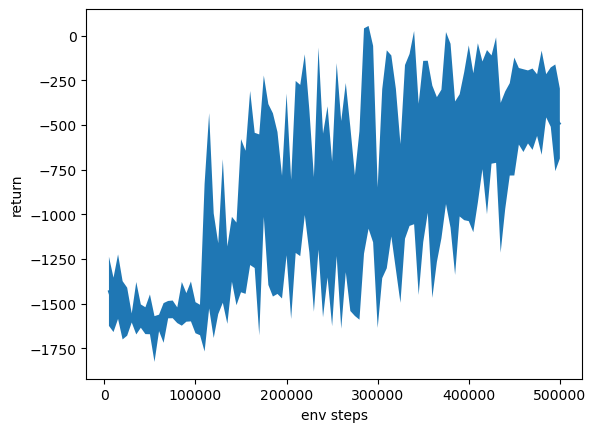

In [5]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [6]:
leaning_curve_ncde_64_rk4 = learning_curve

In [7]:
learning_curve


{'x': [5000,
  10000,
  15000,
  20000,
  25000,
  30000,
  35000,
  40000,
  45000,
  50000,
  55000,
  60000,
  65000,
  70000,
  75000,
  80000,
  85000,
  90000,
  95000,
  100000,
  105000,
  110000,
  115000,
  120000,
  125000,
  130000,
  135000,
  140000,
  145000,
  150000,
  155000,
  160000,
  165000,
  170000,
  175000,
  180000,
  185000,
  190000,
  195000,
  200000,
  205000,
  210000,
  215000,
  220000,
  225000,
  230000,
  235000,
  240000,
  245000,
  250000,
  255000,
  260000,
  265000,
  270000,
  275000,
  280000,
  285000,
  290000,
  295000,
  300000,
  305000,
  310000,
  315000,
  320000,
  325000,
  330000,
  335000,
  340000,
  345000,
  350000,
  355000,
  360000,
  365000,
  370000,
  375000,
  380000,
  385000,
  390000,
  395000,
  400000,
  405000,
  410000,
  415000,
  420000,
  425000,
  430000,
  435000,
  440000,
  445000,
  450000,
  455000,
  460000,
  465000,
  470000,
  475000,
  480000,
  485000,
  490000,
  495000,
  500000],
 'y': [-1430.8

In [8]:
timess=torch.linspace(0, 65-1, 65)

In [9]:
file1 = open('config.txt', 'w')
file1.write(str(conf))

file1.close()
file2 = open('results.txt', 'w')
file2.write(str(learning_curve))
file2.close()